In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=20000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]))[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    # return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    return sigma_clipped_stats(bin_colors, sigma=5)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            (source_nums, [obs1_mask, obs1_specs, obs1_bgs],
             [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
                obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            src_names, obs_specs, obs_bgs = load_chandraspec_obs(
                obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


833:80: E501 line too long (85 > 79 characters)
834:80: E501 line too long (99 > 79 characters)


In [4]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_deep_GB_sources/chandra_deep_combined_spec/2CXOJ174525.2-290632_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/chandra_msp_sim_highNH/'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/sim_msps_highNH_PN_MOS/'
chandra_obs_path = '../data/chandra_obs/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data/Galactic_highNH_combinedXMM/'

1:80: E501 line too long (170 > 79 characters)
2:80: E501 line too long (115 > 79 characters)
3:80: E501 line too long (120 > 79 characters)
4:80: E501 line too long (100 > 79 characters)
5:80: E501 line too long (96 > 79 characters)


In [9]:
set_plotparams('notebook')

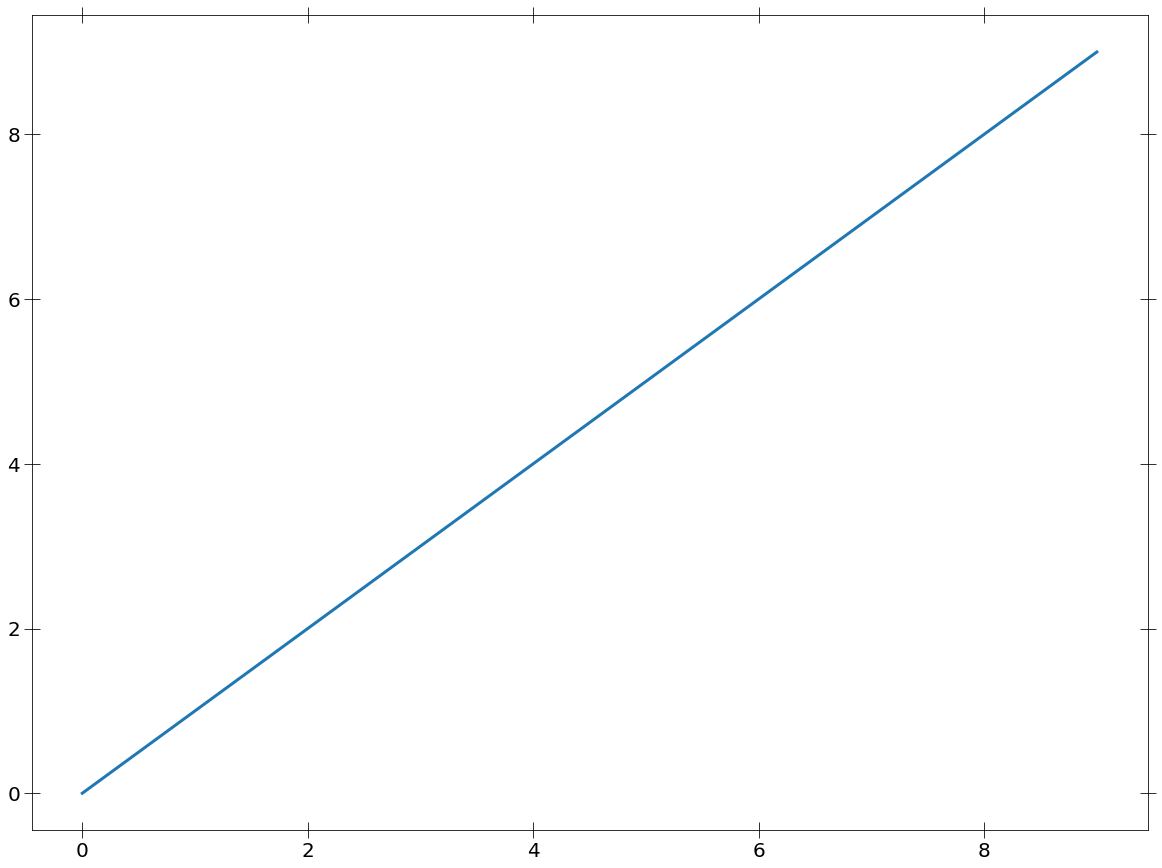

In [10]:
plt.plot(np.arange(10))

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:287: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


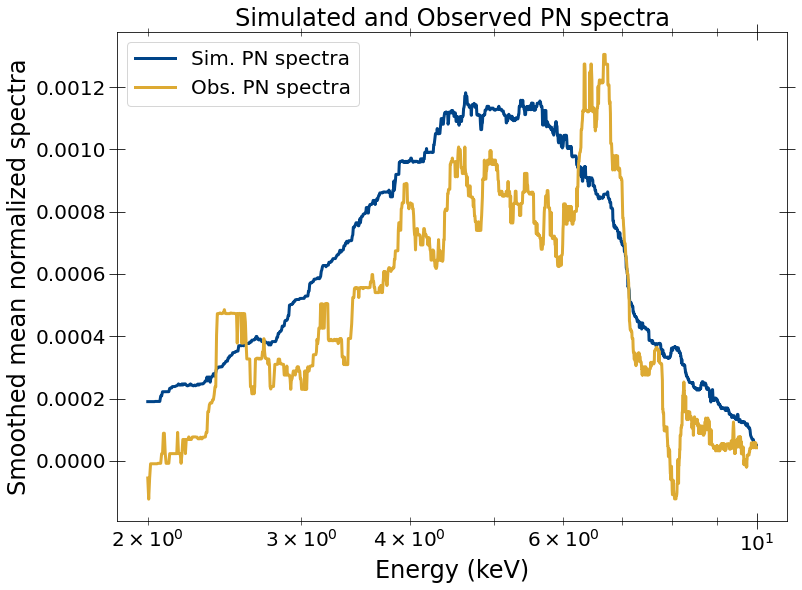

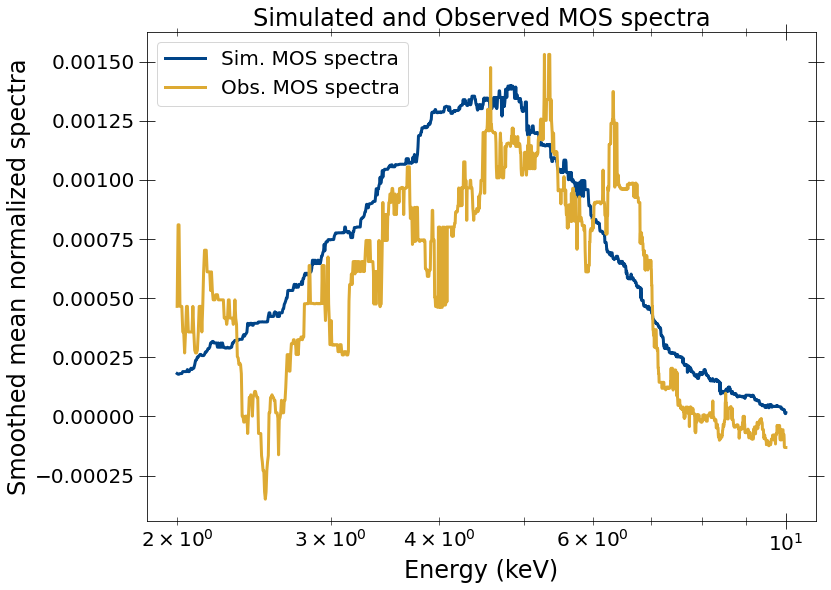

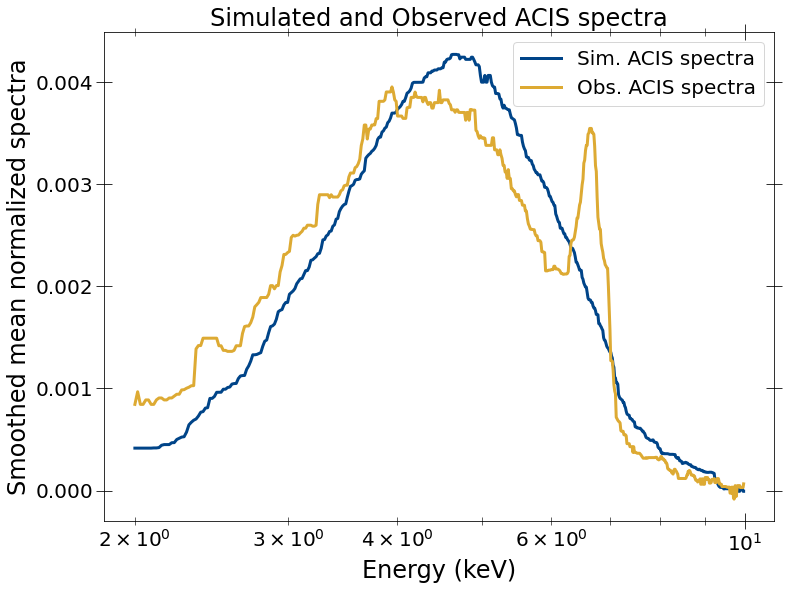

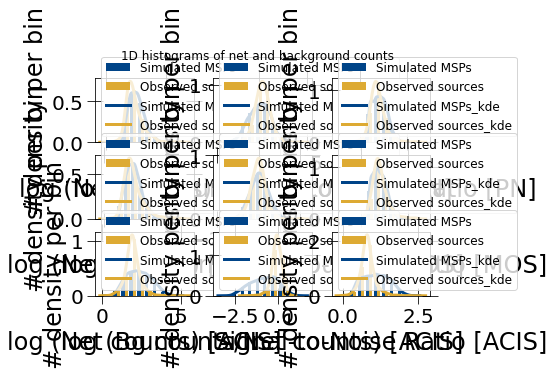

In [7]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

4488 4488 4488 4488
504 504 504 504


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
2358 2358 2358 2358
292 292 292 292
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


7337 7337 7337 7337
2064 2064 2064 2064


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:287: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


16.0
16.0


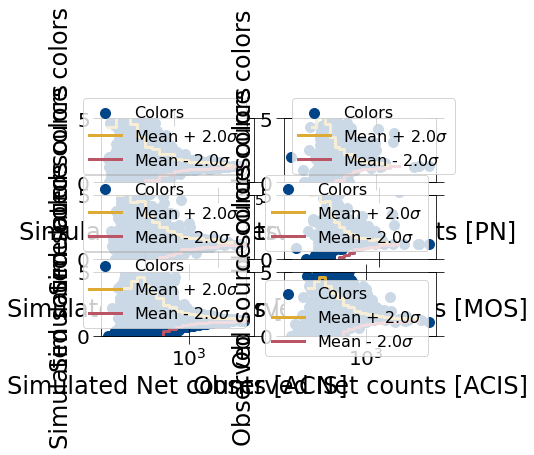

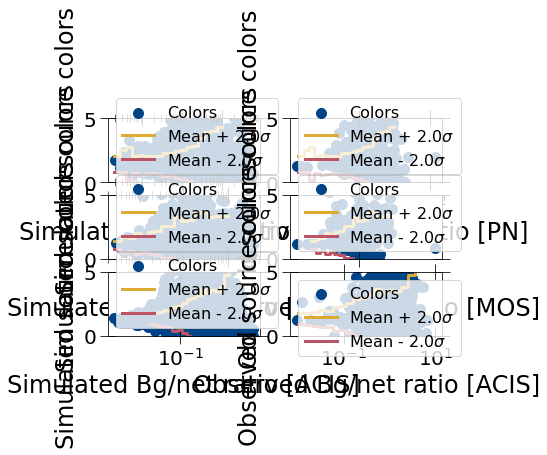

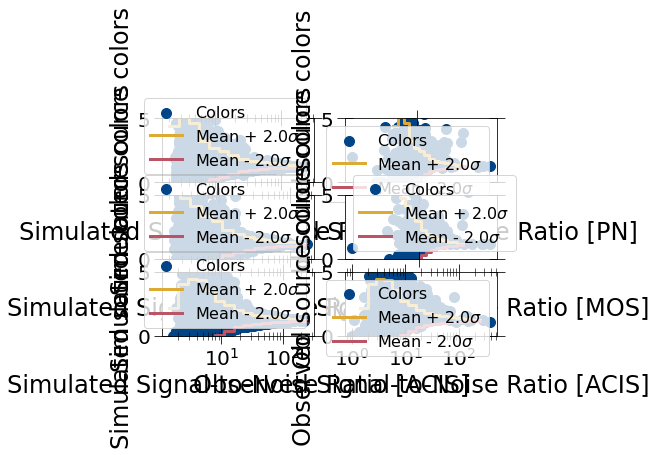

In [8]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary, compare_det=True)

4488 4488 4488 4488
504 504 504 504


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
2358 2358 2358 2358
292 292 292 292


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7337 7337 7337 7337
2064 2064 2064 2064
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: invalid value encountered in true_divide


16.0
16.0
16.0


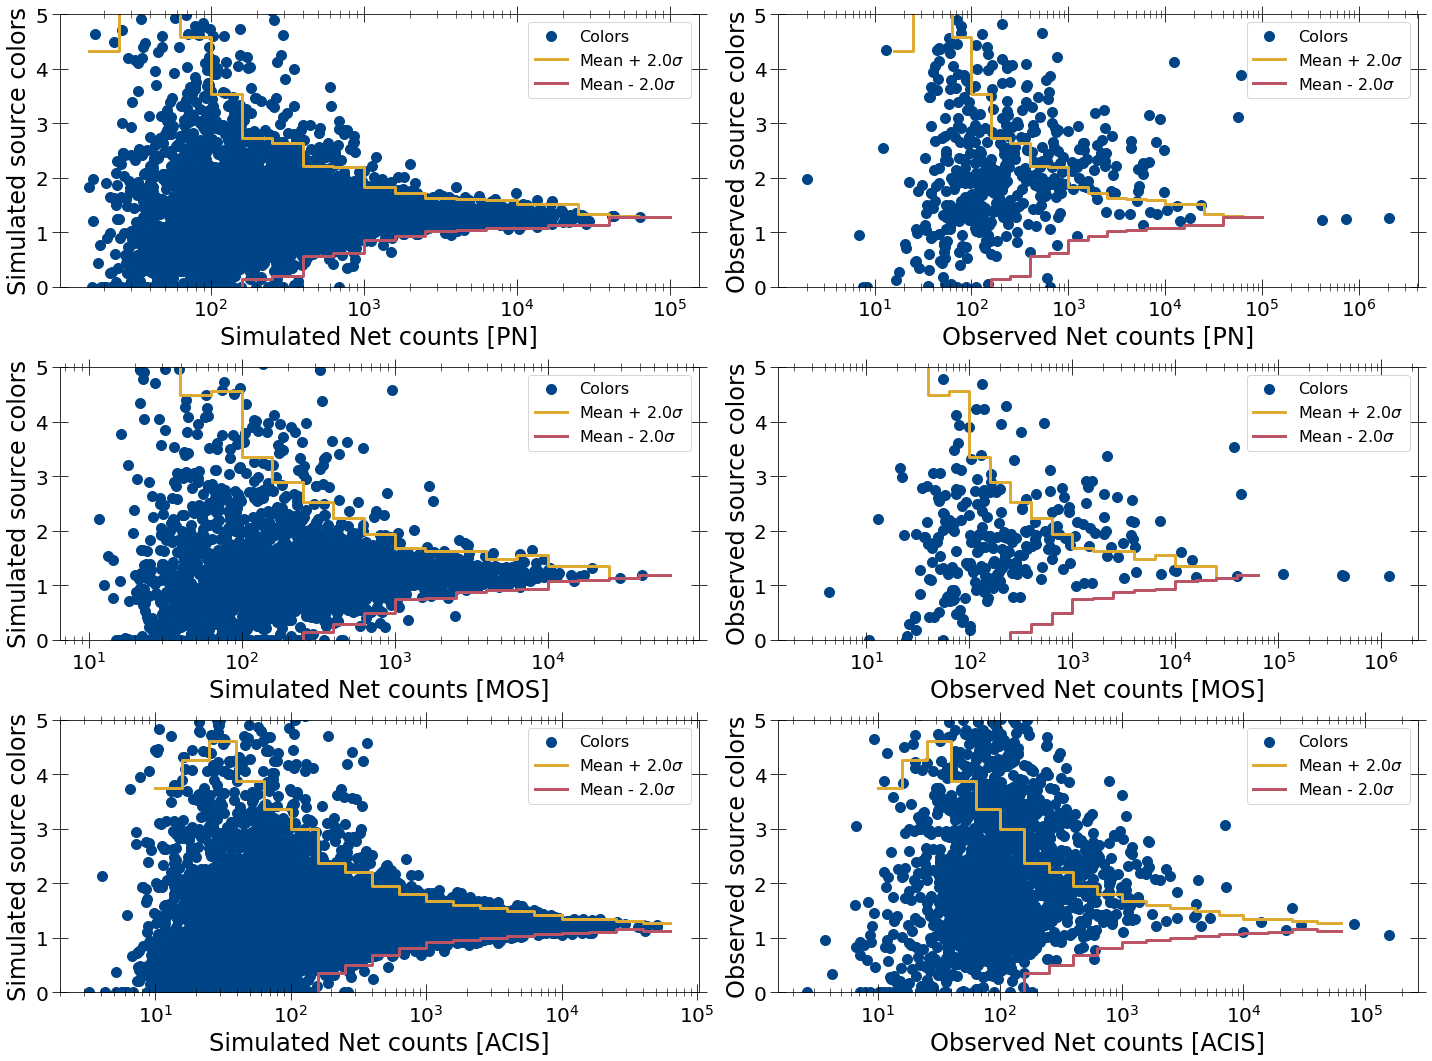

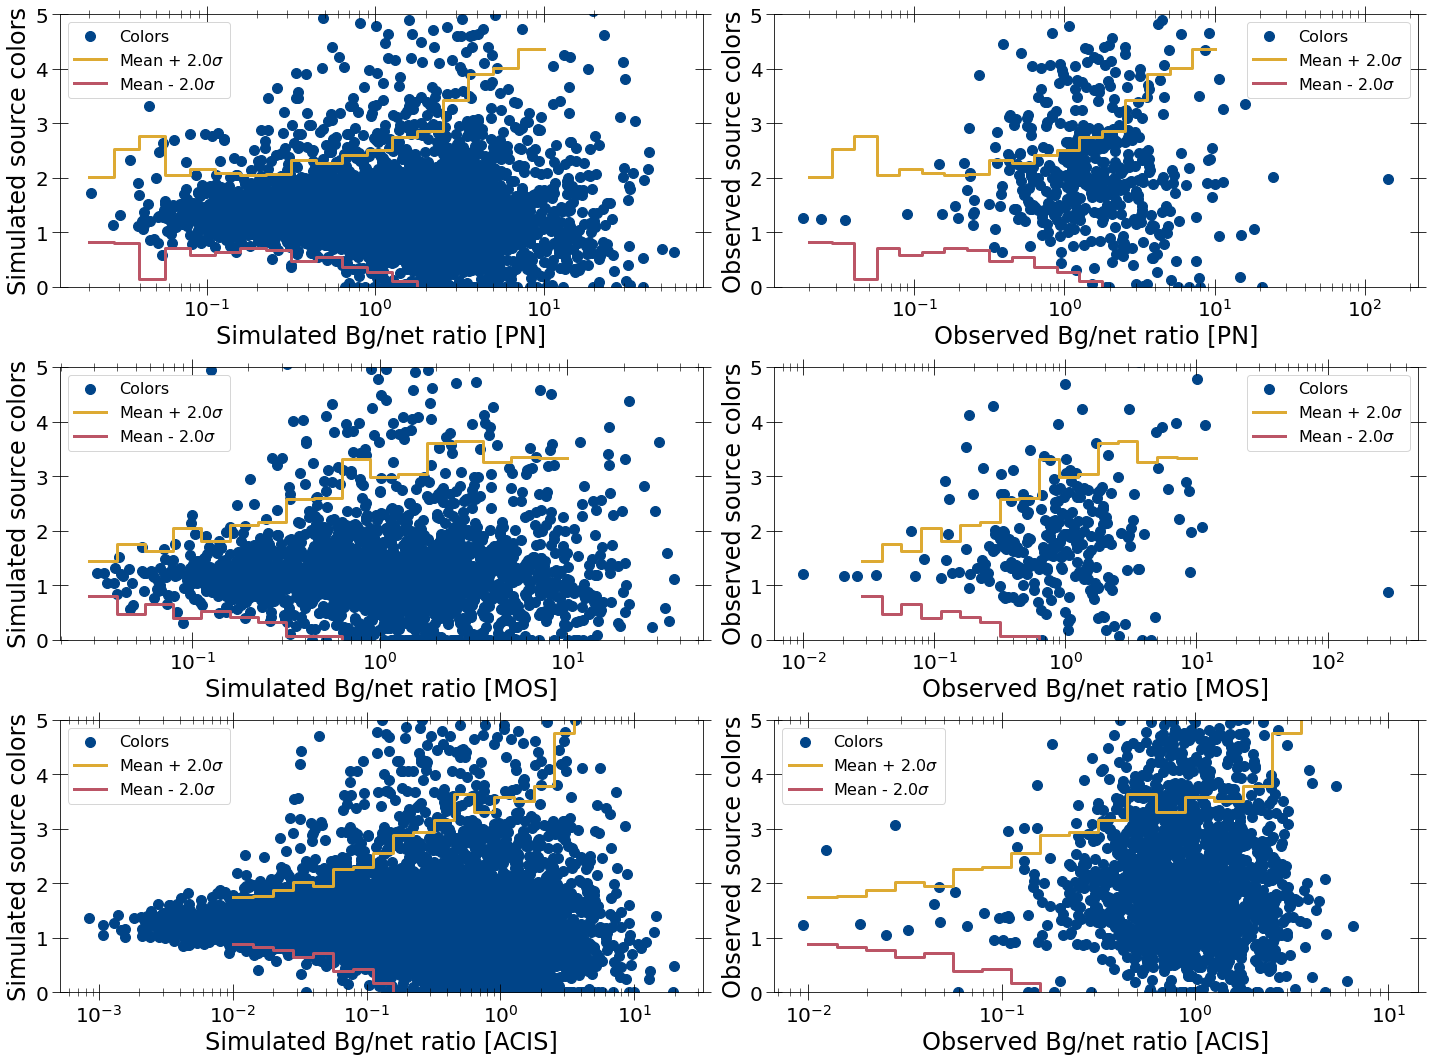

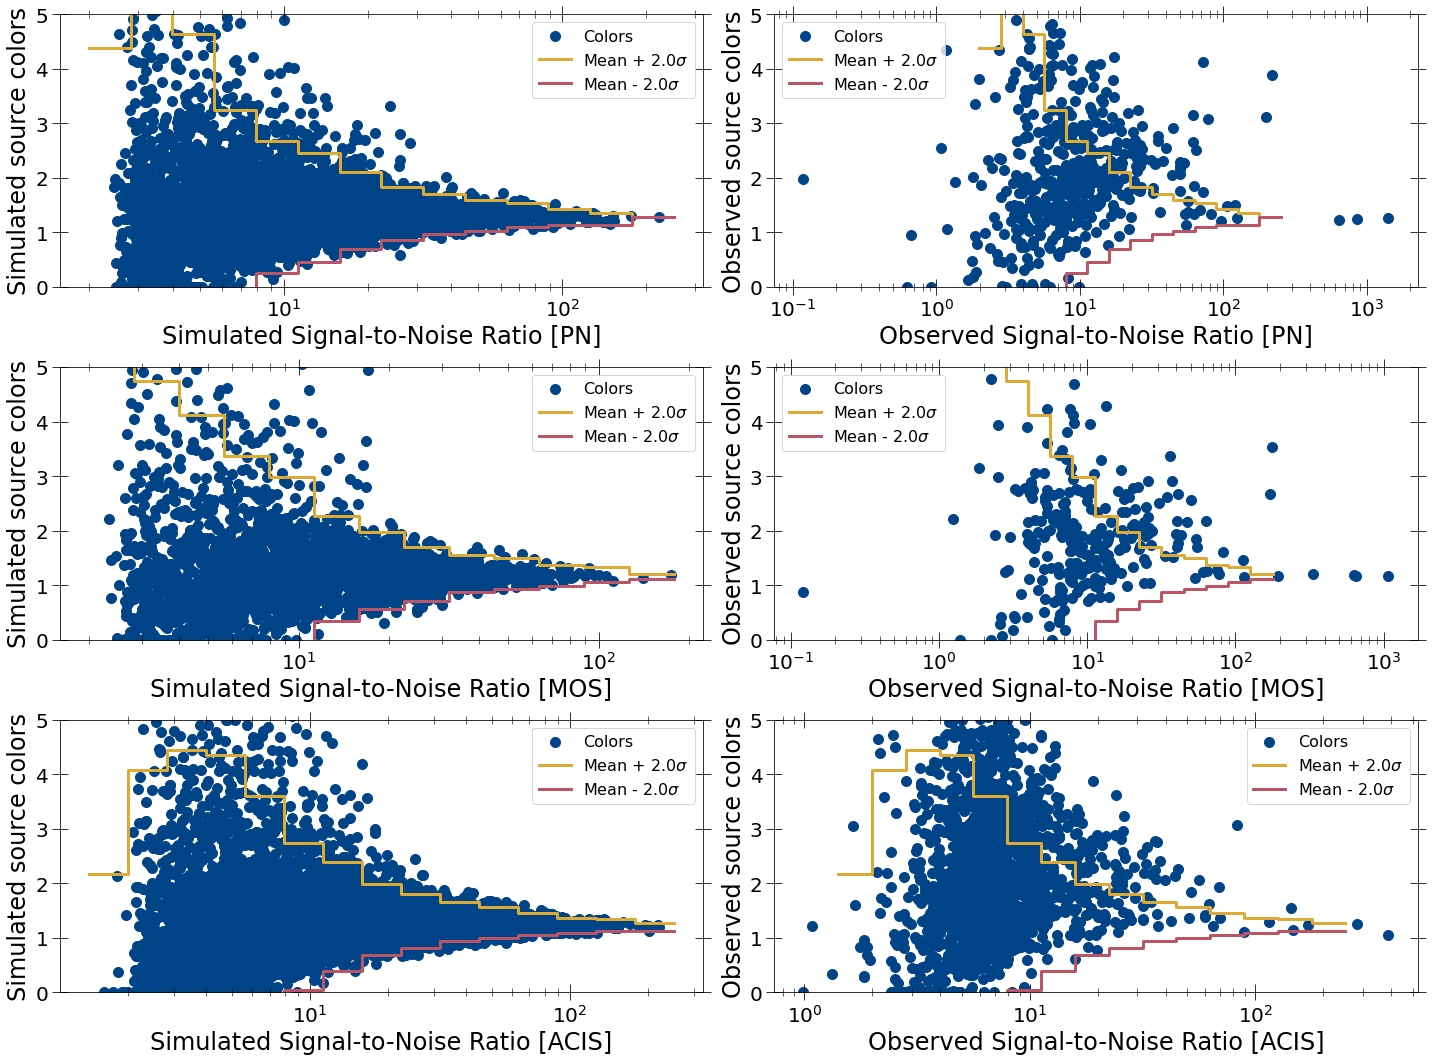

In [11]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


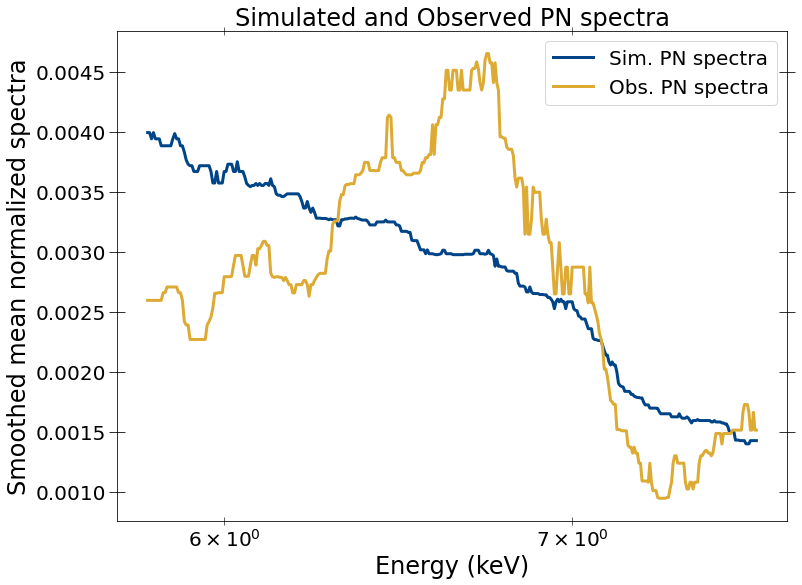

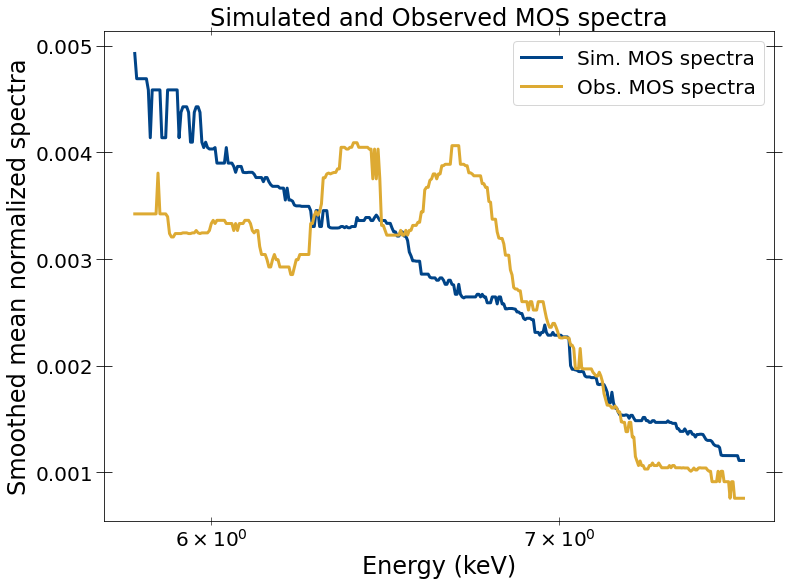

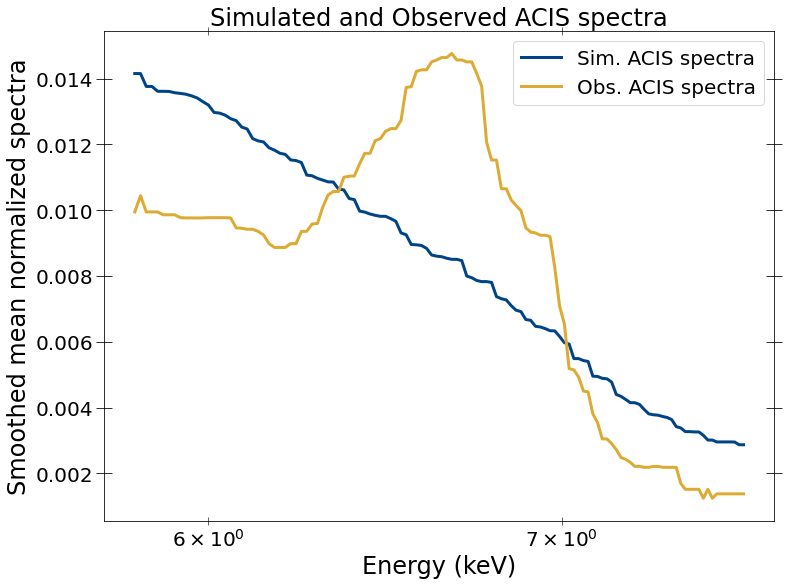

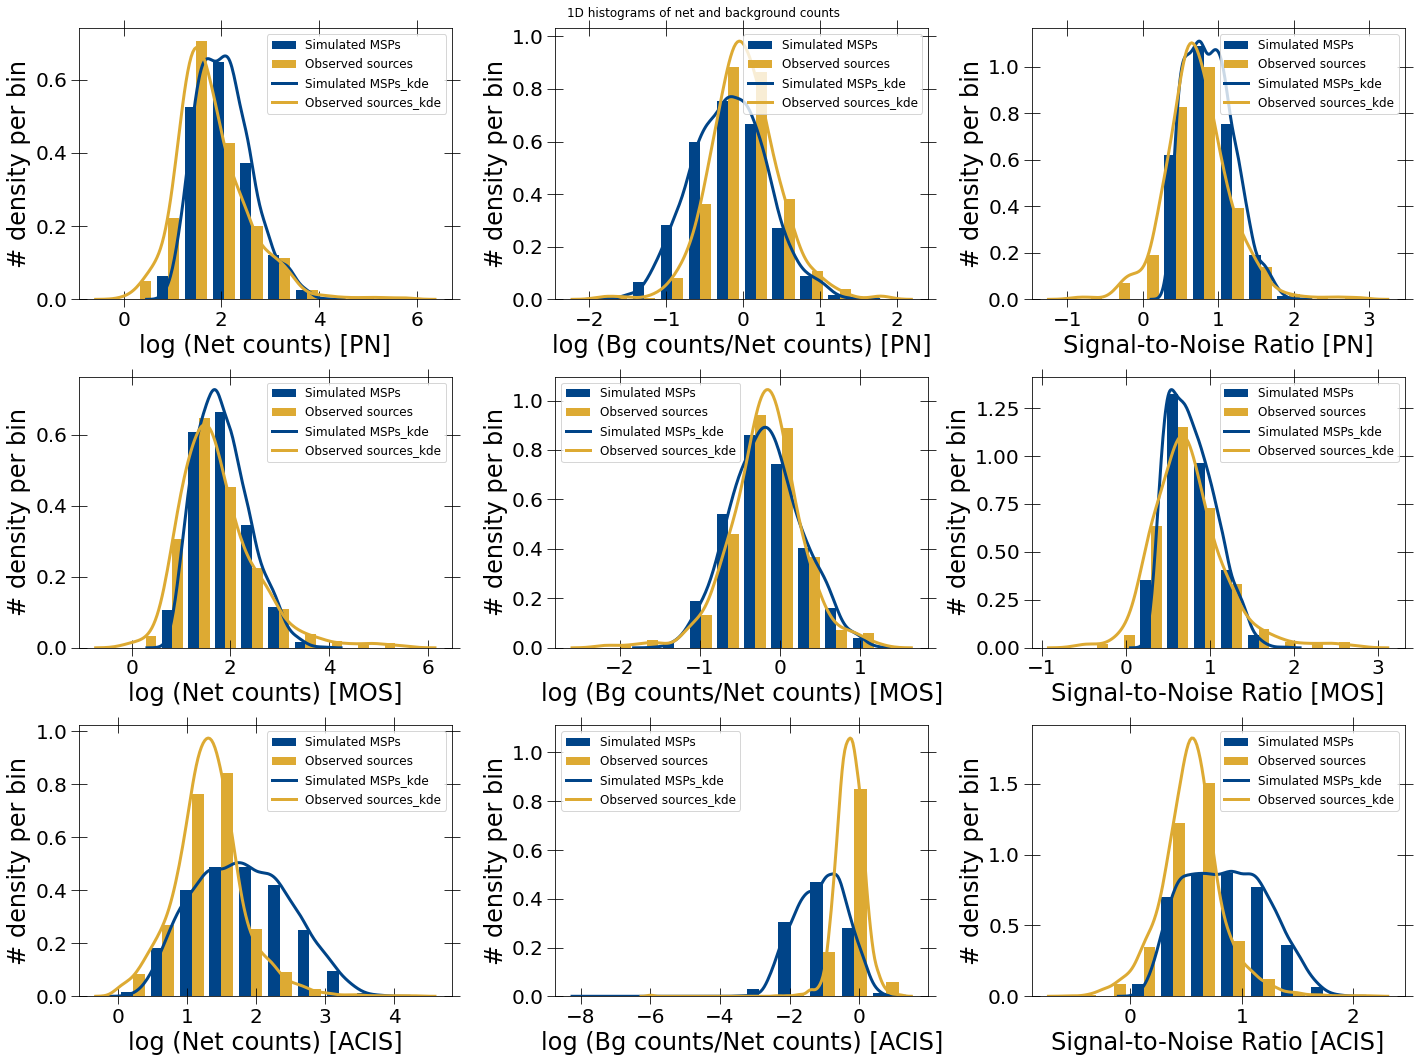

In [13]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[5.8, 7.6])

3870 3870 3870 3870
503 503 503 503
Calaculating mean and standard deviation in colors vs. Net counts


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide


Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
1825 1825 1825 1825
290 290 290 290
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide


6563 6563 6563 6563
2009 2009 2009 2009
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:668: RuntimeWarning: divide by zero encountered in true_divide


16.0
16.0
16.0


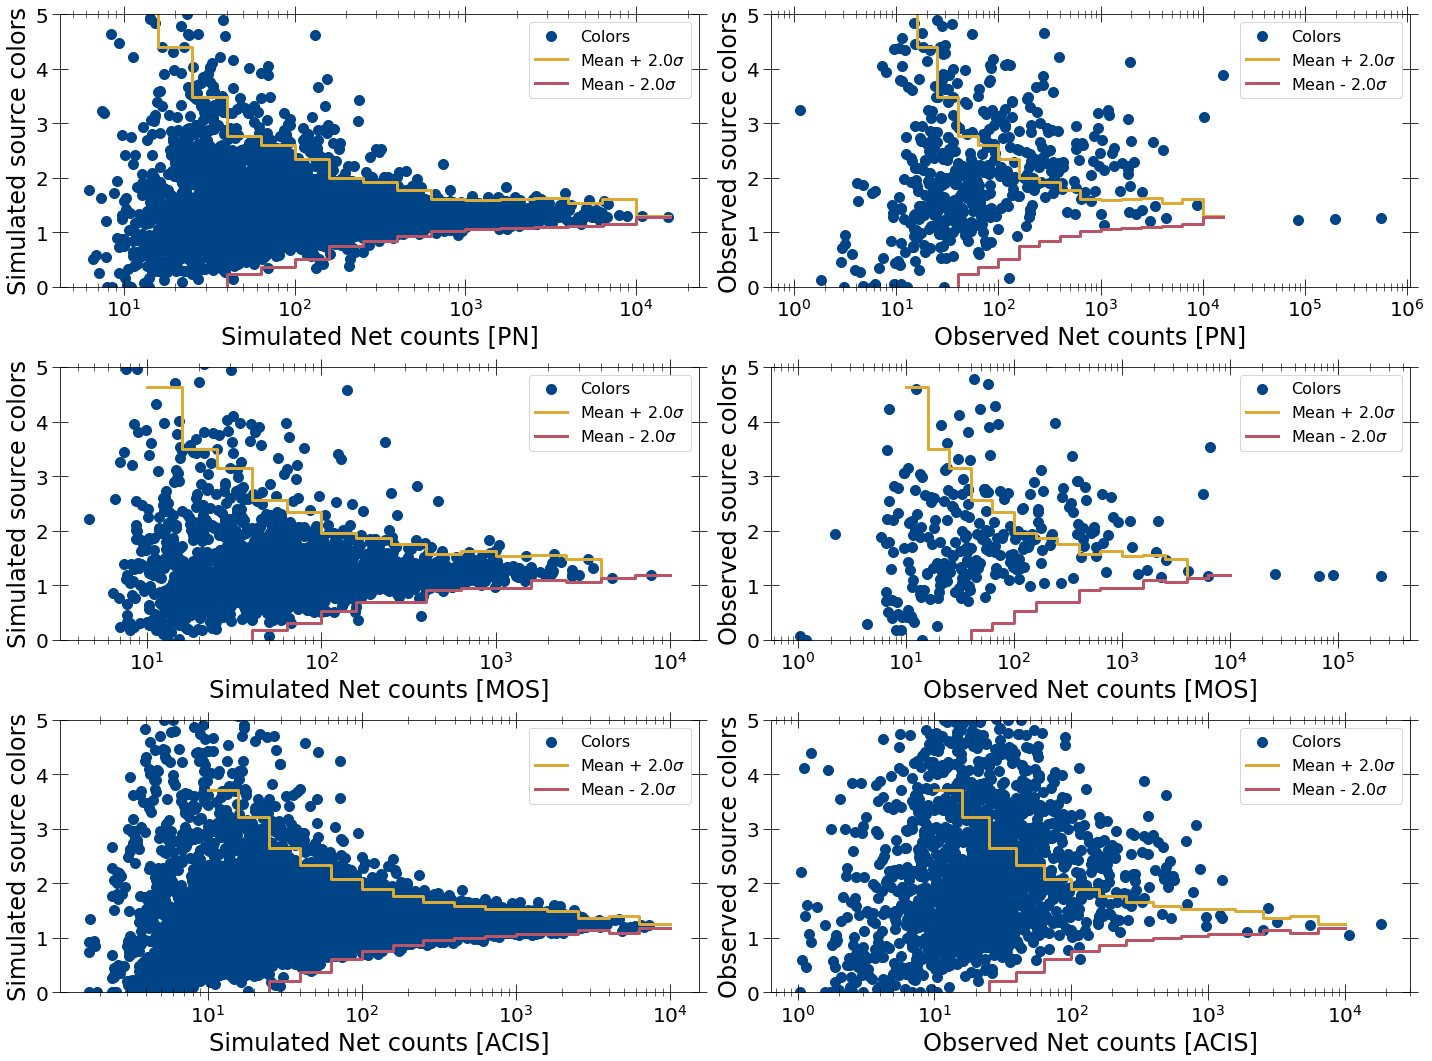

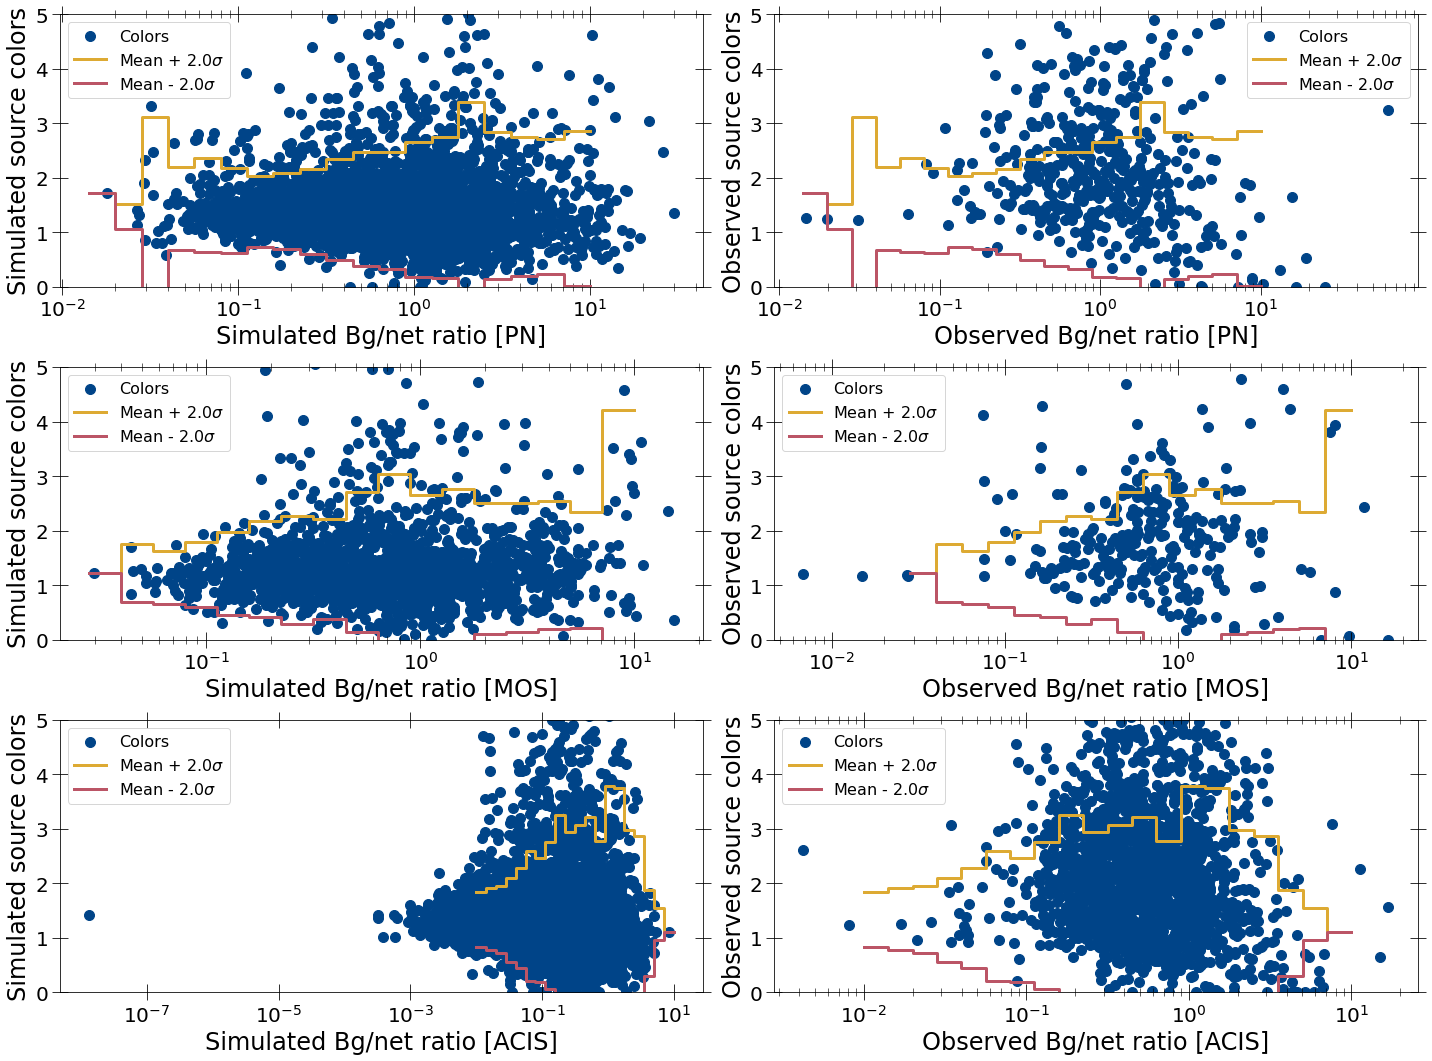

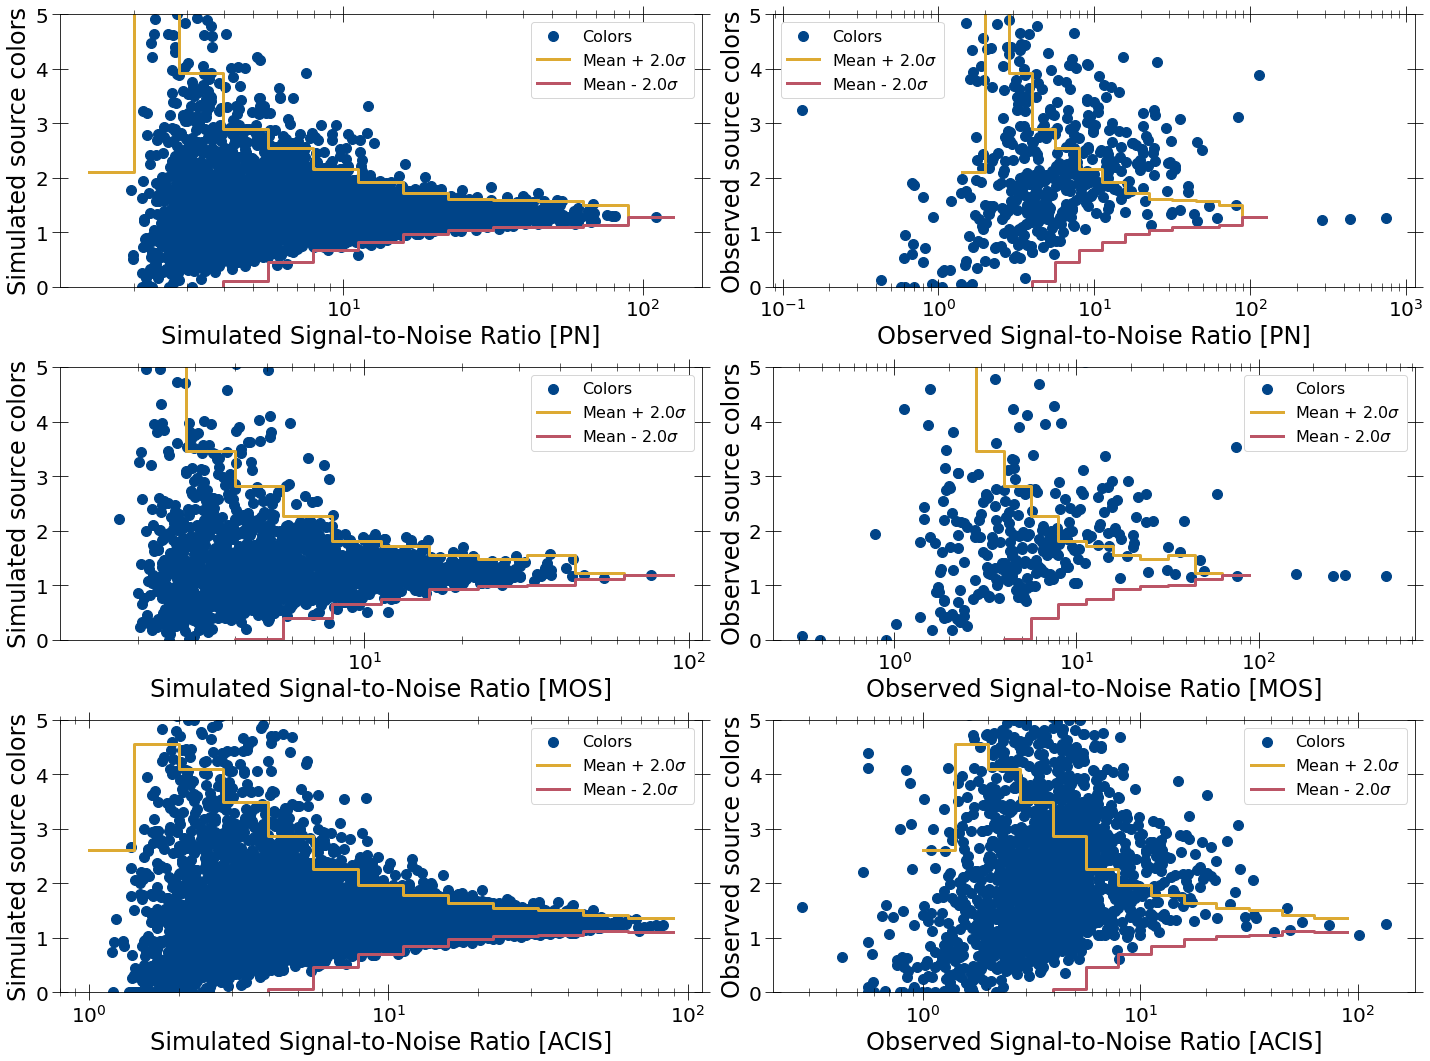

In [14]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(
    spec_summary2, compare_det=True)

In [15]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [16]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[39, 39, 24])

[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[2.00871979 1.7233524  1.5884483  1.49984145 1.47657724 1.42700144
 1.37002768 1.37766632 1.3549527  1.31473815 1.3277049  1.34477512
 1.36440991 1.32344936 1.38813392 1.29134765        nan        nan
        nan        nan]
[2.15764413 1.33454851 0.94985389 0.63579873 0.55878543 0.46227994
 0.31535606 0.2693783  0.20954657 0.15002738 0.13145494 0.13485116
 0.13204202 0.10544924 0.1155218  0.00488405        nan        nan
        nan        nan]
39.810717055349734 2.771438918519578
45
63.09573444801933 2.5941481083118716
39
100.0 2.3515613172342045
17
158.48931924611142 2.000739807953098
14
251.18864315095823 1.9164229169949565
6
398.1071705534973 1.774045843293957
2
63

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


In [17]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[150, 150, 150])

[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[       nan 1.2687122  1.57780052 1.70915961 1.72618644 1.55048851
 1.4340423  1.42124175 1.394855   1.40755973 1.34409077 1.31995169
 1.32216643 1.32350378 1.33359872 1.30127259 1.3196426  1.23300753
 1.2935751  1.2864636 ]
[       nan 1.53260585 1.86990841 1.81391648 1.43103604 0.9968727
 0.64695942 0.6082106  0.41238333 0.39253497 0.23961263 0.19736298
 0.15092732 0.13924128 0.13023717 0.10790615 0.09740043 0.04973127
 0.0026566  0.        ]
158.48931924611142 2.7279611457493704
44
251.18864315095823 2.637662941671821
24
398.1071705534973 2.2196216611557893
18
630.957344480193 2.192629679023936
15
1000.0 1.8233160286795935
2
1584.893192461114 1.7146776386488467
2
251

1:80: E501 line too long (112 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


In [24]:
print(len(np.sort(interested_srcs_alldet[0])))
print(len(np.sort(interested_srcs_alldet2[0])))

119
138


In [26]:
print(len(np.sort(interested_srcs_alldet[1])))
print(len(np.sort(interested_srcs_alldet2[1])))

89
70


In [25]:
print(len(np.sort(interested_srcs_alldet[2])))
print(len(np.sort(interested_srcs_alldet2[2])))

228
405


In [21]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(interested_args)
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))

11:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


(array([  0,   3,   5,   7,   9,  10,  19,  20,  22,  24,  29,  31,  33,
        34,  35,  38,  40,  43,  44,  49,  50,  57,  58,  60,  67,  71,
        75,  79,  83,  84,  86,  90,  91,  93,  98, 105, 108, 110, 111,
       117, 121, 122, 124, 125, 127, 129, 133, 134, 137, 138, 140, 144,
       147, 148, 150, 152, 153, 160, 161, 162, 169, 172, 173, 177, 182,
       186, 187, 190, 191, 192, 194, 195, 196, 197, 198, 203, 204, 206,
       213, 214, 223, 229, 231, 232, 240, 252, 259, 261, 265, 266, 267,
       272, 273, 274, 275, 278, 283, 296, 300, 304, 305, 308, 309, 311,
       320, 329, 330, 336, 339, 342, 354, 356, 357, 364, 374, 376, 389,
       394, 396, 398, 409, 432, 441, 442, 443, 444, 449, 451, 464, 465,
       467, 471, 481, 482, 483, 484, 485, 488]),)


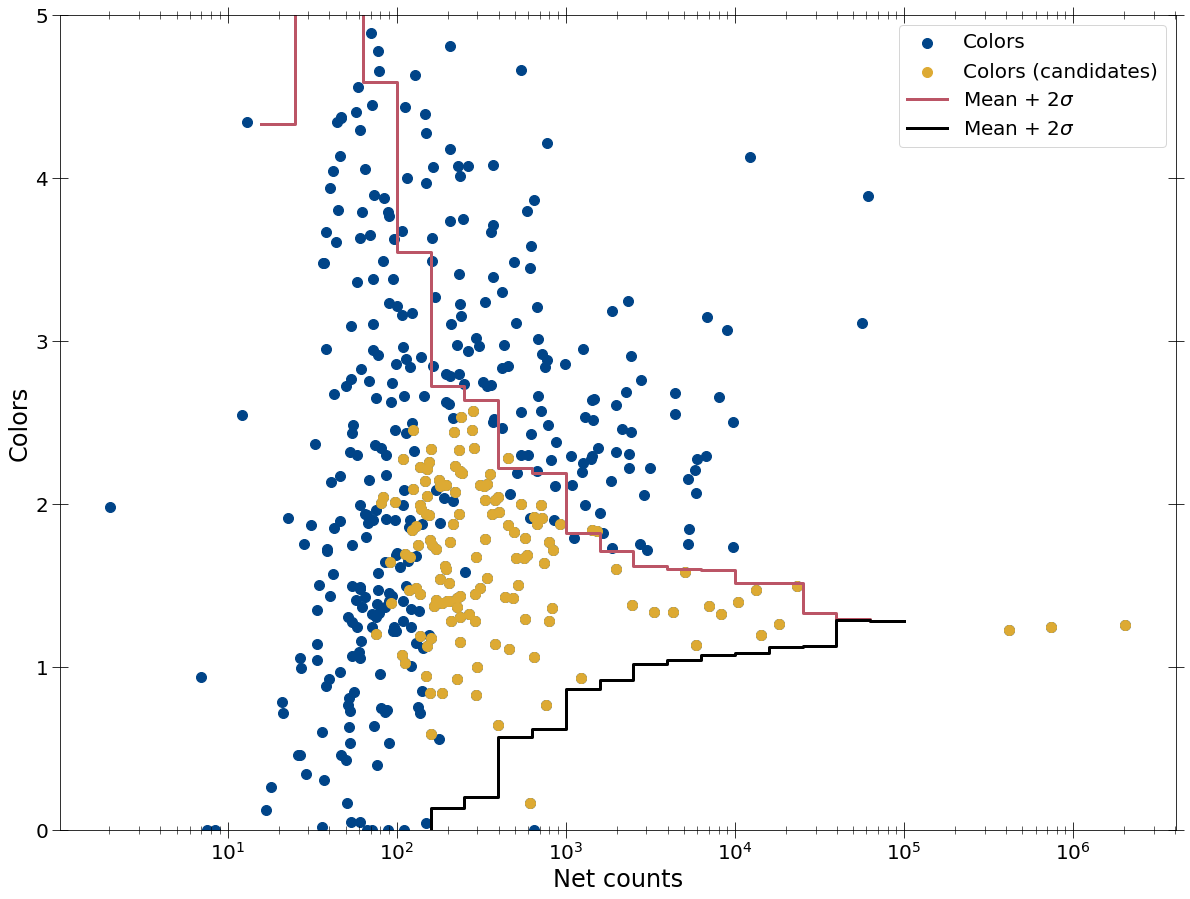

2:80: E501 line too long (83 > 79 characters)


In [22]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     interested_srcs_alldet2[0], 0)

(array([  2,   3,   6,  16,  21,  24,  29,  30,  33,  37,  44,  45,  51,
        53,  55,  56,  59,  66,  67,  72,  81,  84,  86,  93,  96, 103,
       110, 113, 122, 123, 125, 126, 130, 133, 136, 137, 139, 144, 146,
       151, 152, 154, 171, 181, 183, 185, 196, 198, 199, 200, 216, 220,
       221, 223, 224, 226, 229, 231, 234, 242, 243, 246, 253, 254, 261,
       272, 273, 280, 281, 287]),)


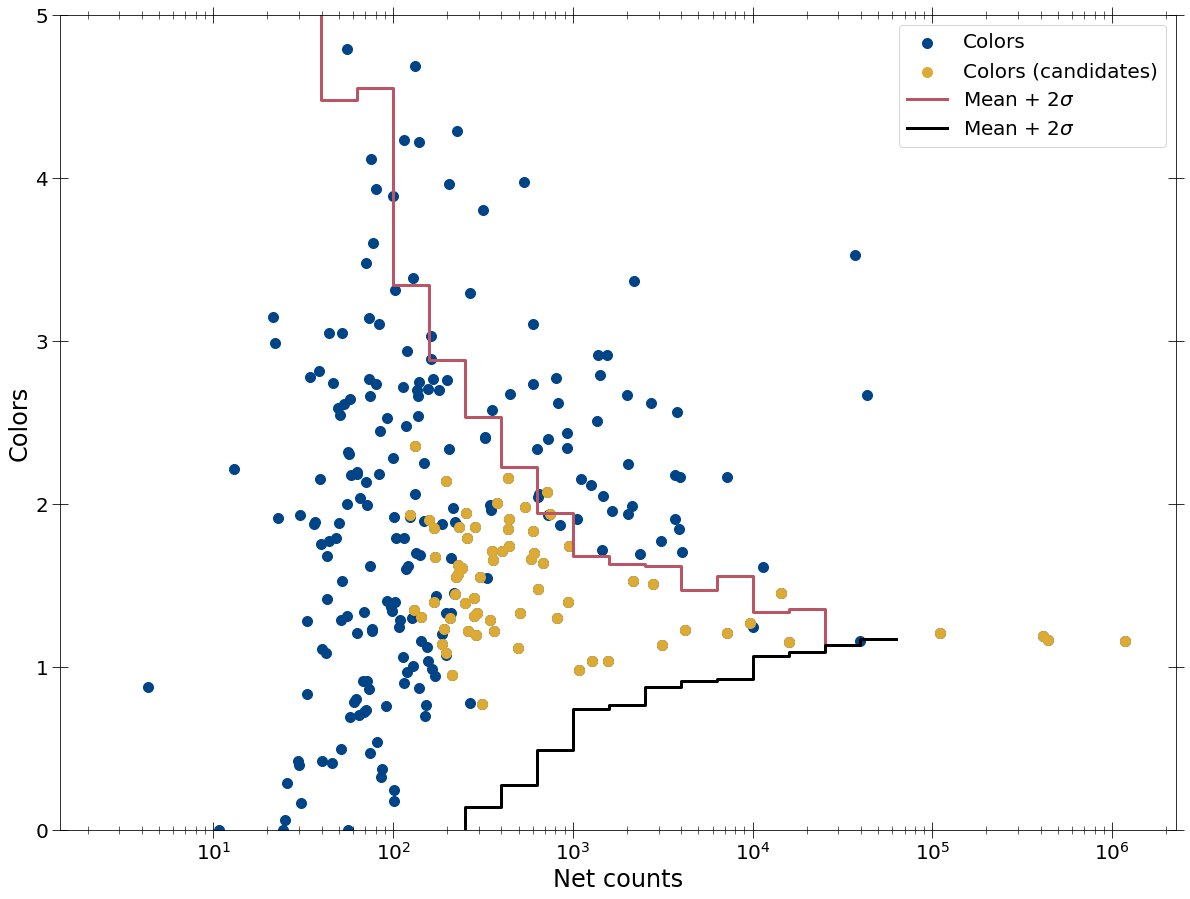

2:80: E501 line too long (83 > 79 characters)


In [27]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     interested_srcs_alldet2[1], 0)

(array([   0,    1,    2,    4,    7,    8,   18,   28,   31,   55,   63,
         74,   75,   77,   81,   82,   83,   94,  102,  110,  132,  133,
        136,  137,  147,  156,  157,  159,  162,  168,  170,  174,  189,
        190,  199,  204,  209,  211,  216,  234,  242,  247,  249,  258,
        260,  262,  264,  273,  278,  282,  284,  294,  296,  308,  318,
        321,  322,  323,  326,  330,  334,  349,  350,  358,  359,  361,
        372,  374,  375,  376,  377,  381,  384,  395,  396,  400,  401,
        402,  411,  414,  416,  417,  419,  420,  429,  433,  453,  454,
        457,  465,  470,  476,  478,  480,  482,  483,  486,  497,  500,
        503,  505,  512,  514,  518,  540,  543,  549,  551,  556,  558,
        563,  568,  572,  579,  582,  583,  586,  587,  607,  608,  613,
        614,  616,  618,  622,  623,  632,  638,  642,  661,  662,  666,
        674,  676,  678,  679,  685,  691,  709,  711,  722,  724,  731,
        733,  748,  750,  762,  763,  764,  765,  

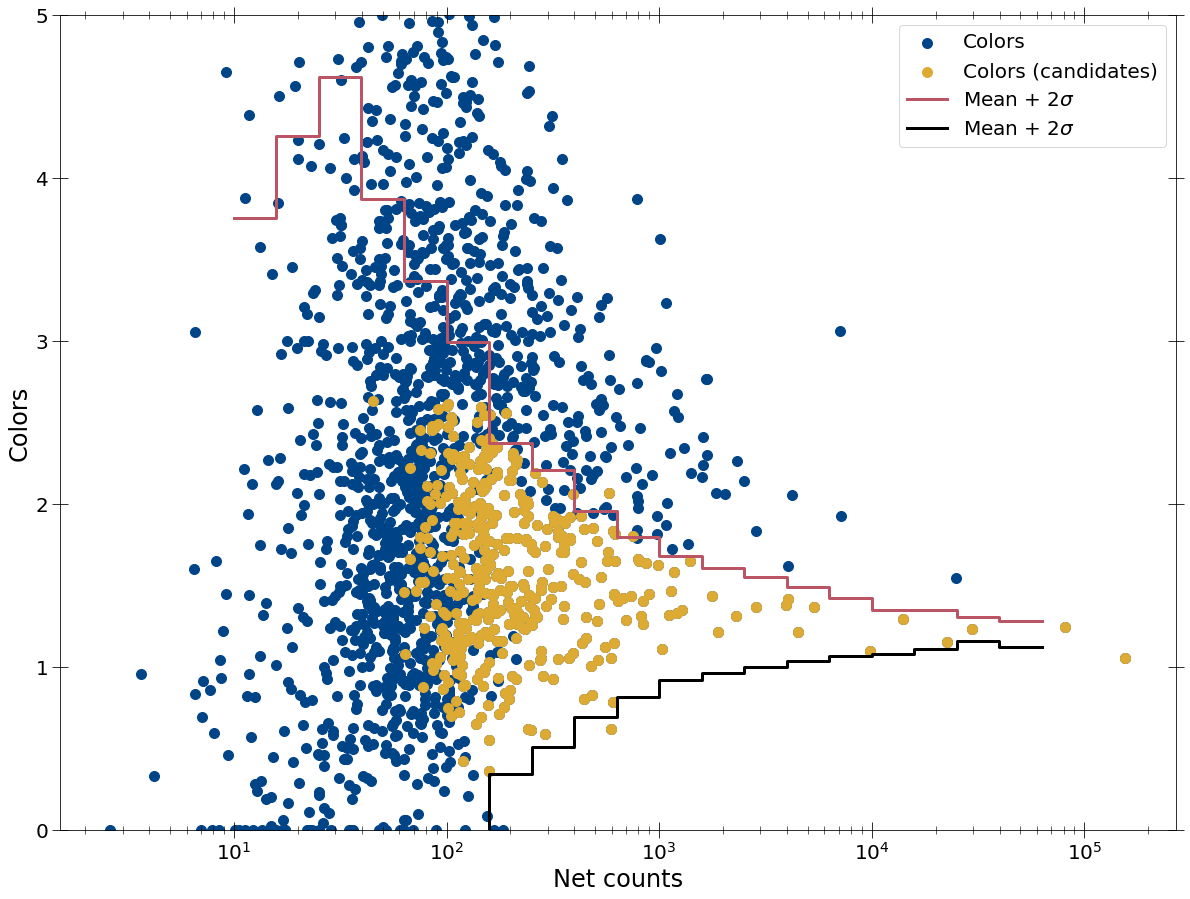

2:80: E501 line too long (83 > 79 characters)


In [28]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     interested_srcs_alldet2[2], 0)

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


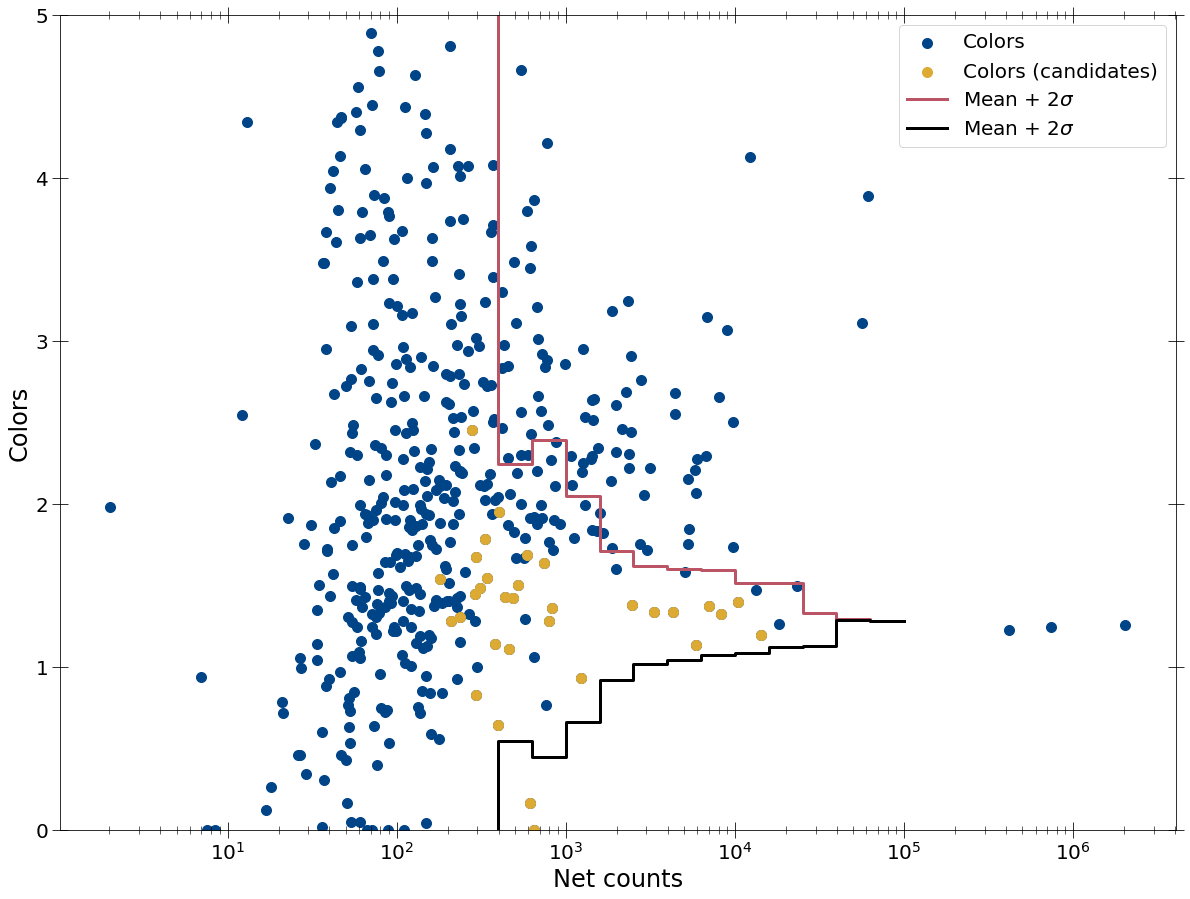

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


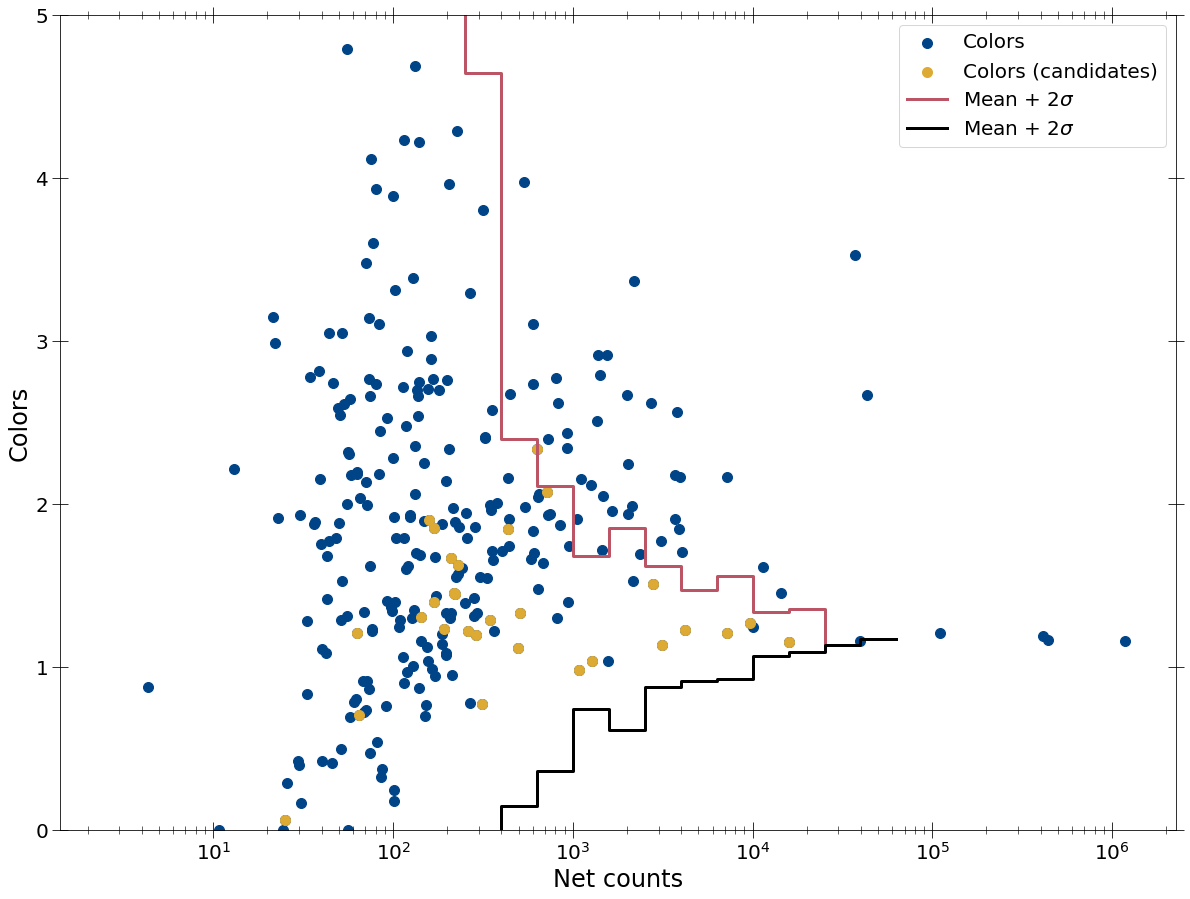

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


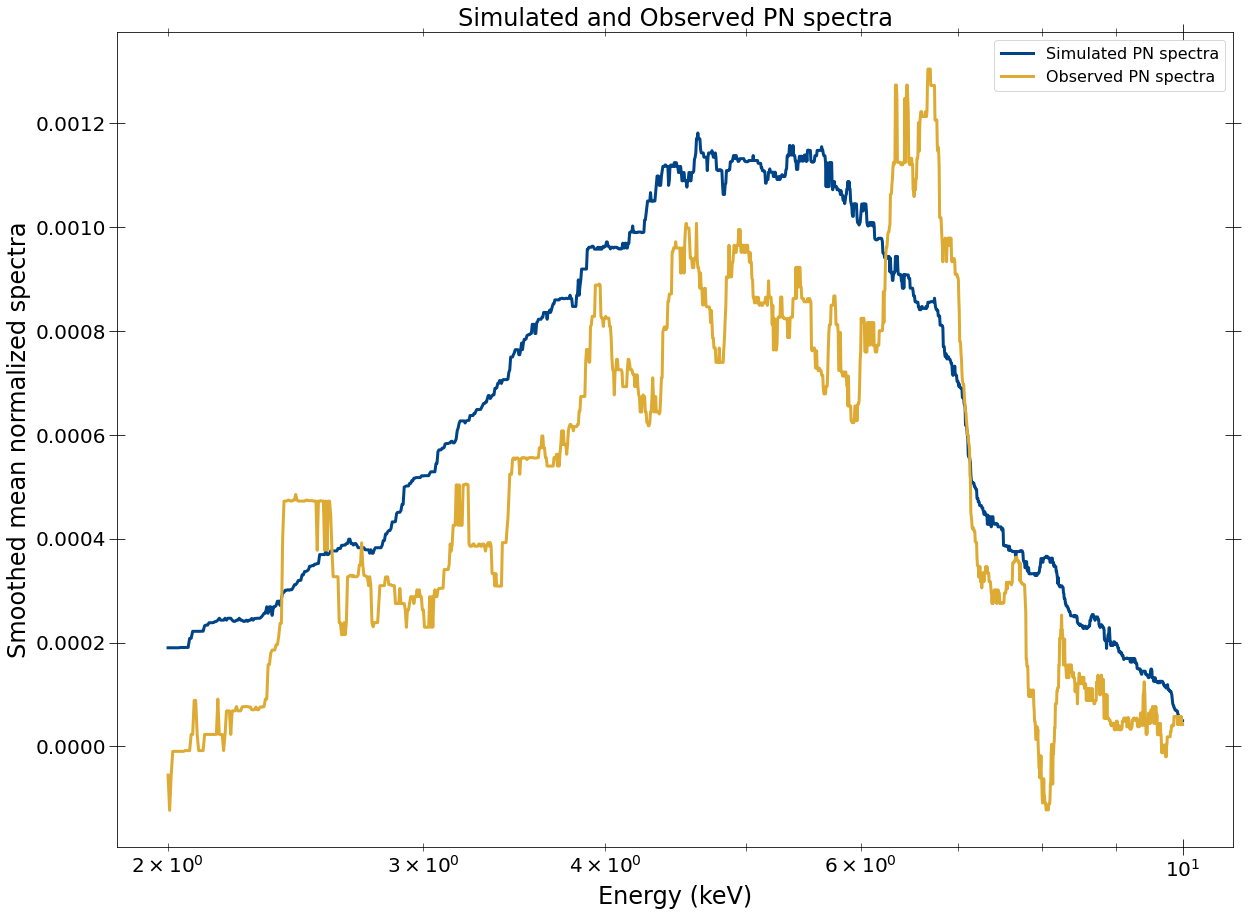

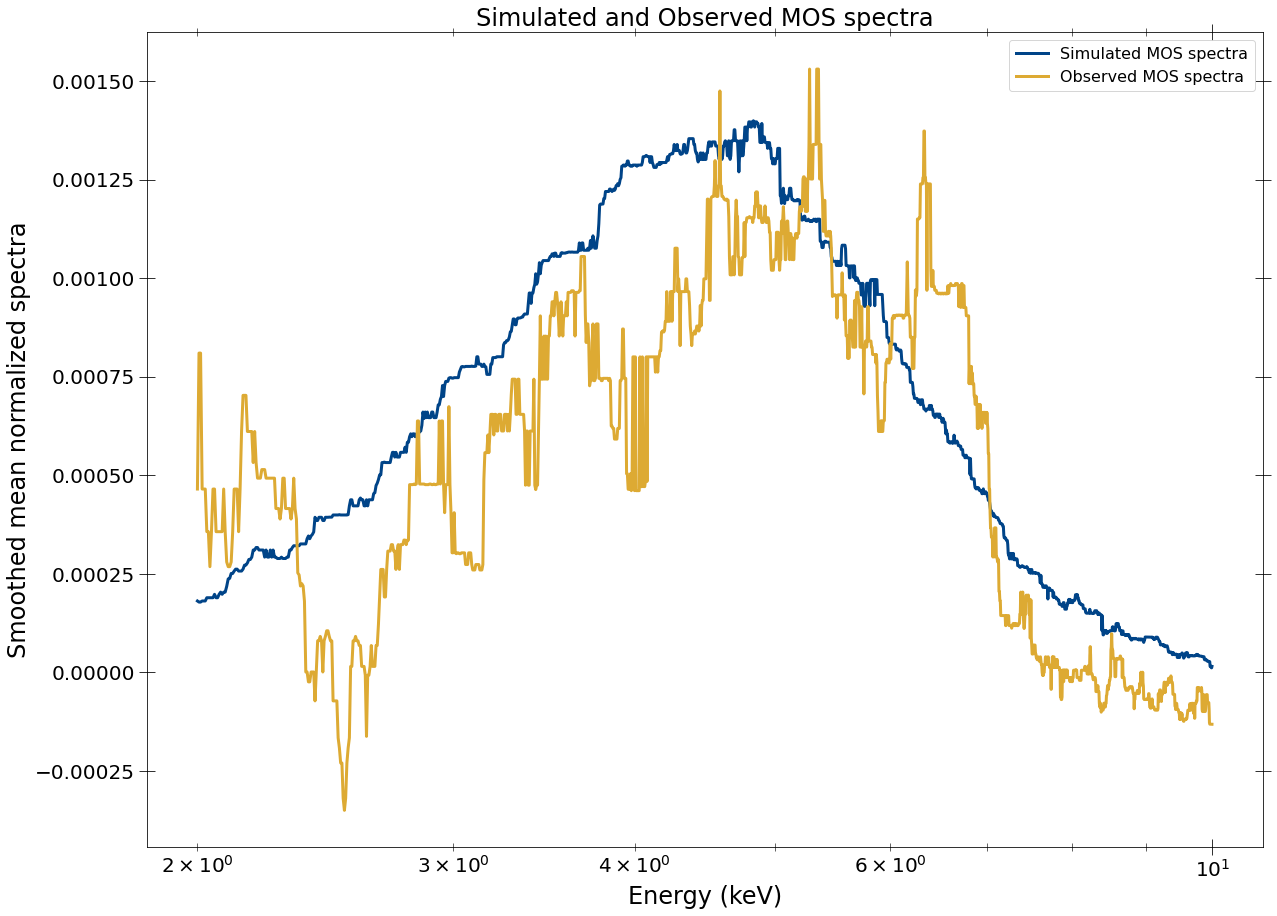

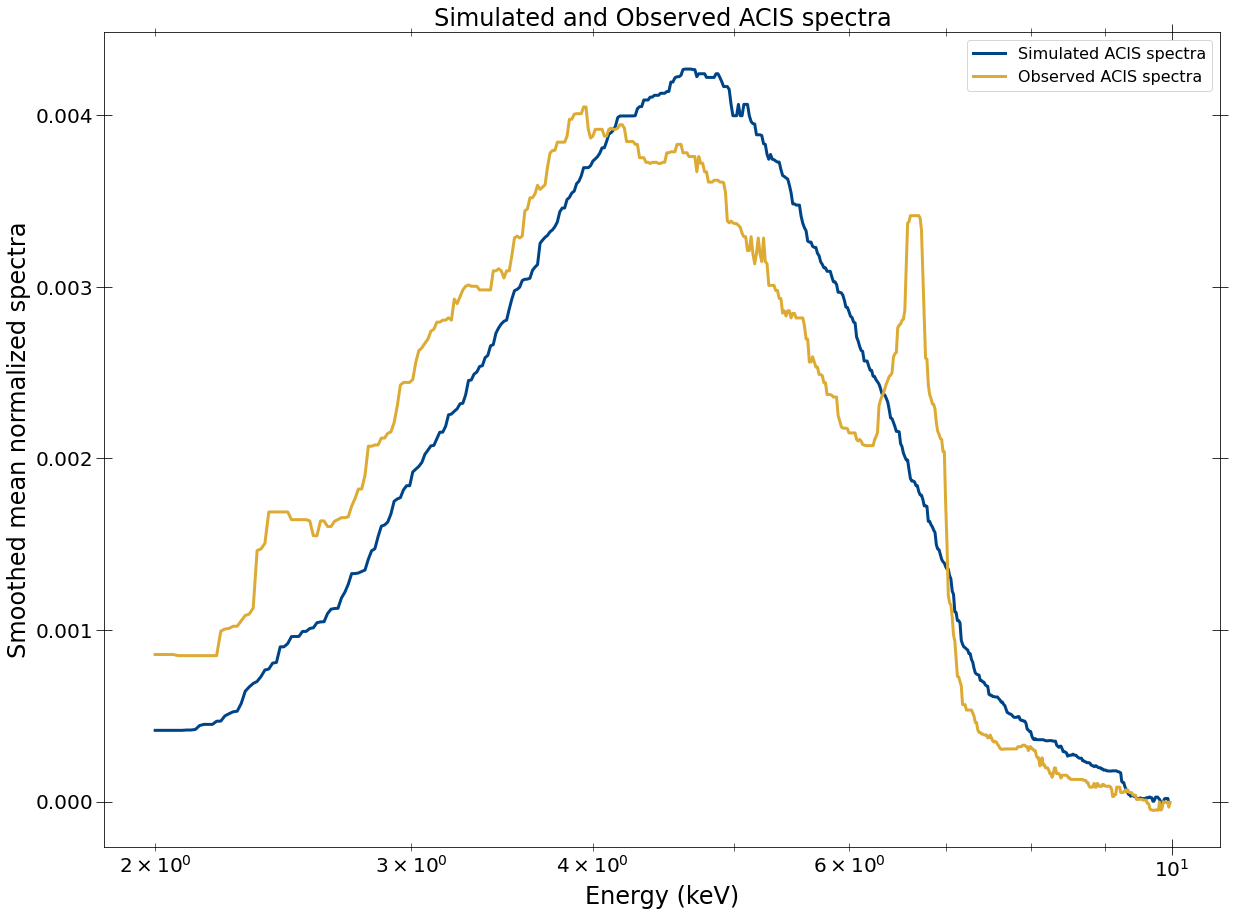

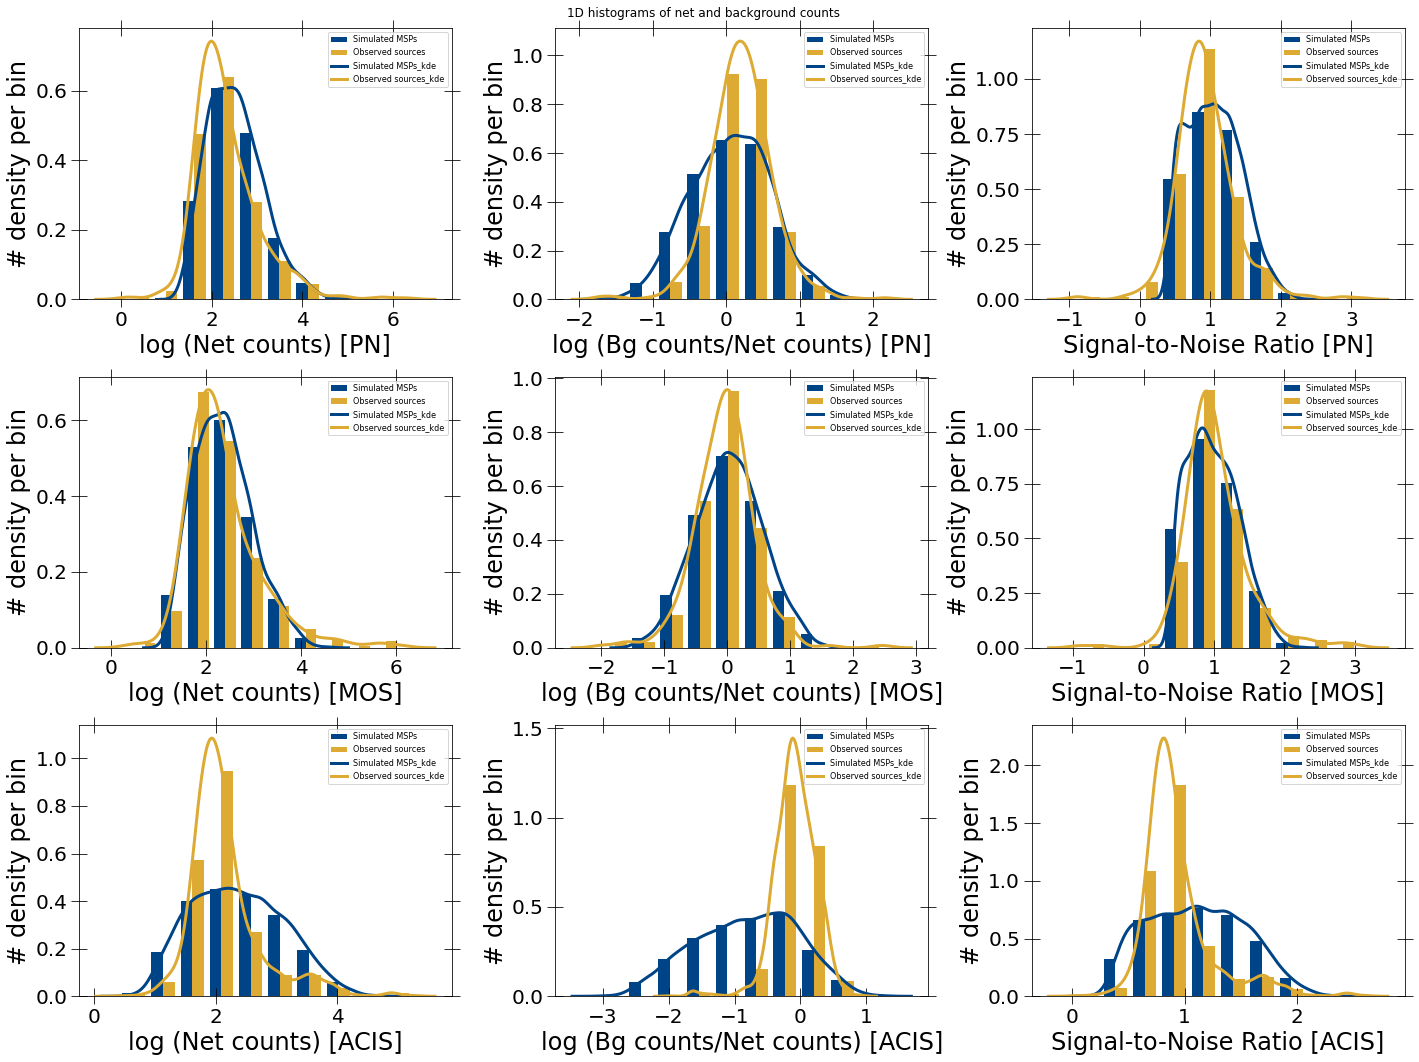

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [29]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    xspec.Xset.addModelString('LINECRITLEVEL', '1.0E-11')
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('1.0 6')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 8')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 6')
    xspec.Fit.error('1.0 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


25:1: W293 blank line contains whitespace
35:1: W293 blank line contains whitespace
47:5: E265 block comment should start with '# '
65:80: E501 line too long (80 > 79 characters)


In [30]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('1.0 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

35:5: E265 block comment should start with '# '
46:80: E501 line too long (80 > 79 characters)


In [32]:
fit_src_pl(interested_srcs_alldet[0][11])

Model params for 201129704010033: NH =  39.31615012136381  Gamma:  1.108668033822623  norm:  0.2644667587745829
Fit stats for 201129704010033:  667.5720375241511 -7.1247888522302505 50.0 759




(['201129704010033', 667.5720375241511, -7.1247888522302505, 50.0, 759],
 ['201129704010033', 39.31615012136381, 1.108668033822623, 0.2644667587745829])

In [31]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_Xrayclassify/data')

In [28]:
import xspec

In [35]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

200305401010008
Model params for 200305401010008: NH =  7.529959416563291  Gamma:  0.00015545439569978554  norm:  0.1705074002325298  Fe_pos: 6.625819853585894 6.542653918980184 6.712775297159159  Fe_norm: 5.314337128477041e-07 1.934771275543889e-07 9.408859723726095e-07
Fit stats for 200305401010008:  305.57046083670855 -7.707927735435329 50.0 374


Model params for 200305401010008: NH =  7.962597433801153  Gamma:  0.00014821992520889414  norm:  0.17493341795646422  Fe_norms: 7.265142311619051e-15 0.0 2.123434948919297e-07 3.8656127404655373e-07 9.589210246882251e-08 7.223651076523784e-07 4.594295440240561e-08 0.0 3.5933746874655177e-07
Fit stats for 200305401010008:  306.10006819464763 -7.707648851565125 50.0 373


200305401010017
Model params for 200305401010017: NH =  13.789402624339273  Gamma:  2.4996551023285564e-06  norm:  0.14401317361226024  Fe_pos: 6.7360798728968145 6.679923502866158 6.792657913798937  Fe_norm: 8.124974616540926e-07 5.161747521733355e-07 1.156135098765702e-0

Model params for 201129704010033: NH =  37.58376688435754  Gamma:  1.1153459504252852  norm:  0.24856734403946862  Fe_norms: 4.4429896275210224e-08 0.0 3.104073504837616e-07 3.1297496002610865e-07 4.0809581276505986e-08 6.149906689177296e-07 7.983042507277889e-13 0.0 2.710601220051383e-07
Fit stats for 201129704010033:  666.2322426833637 -7.151577104041813 50.0 756


201129704010053
Model params for 201129704010053: NH =  11.107361459682386  Gamma:  1.133585887484933  norm:  0.09814688972322785  Fe_pos: 6.437583848653975 6.367989630810763 6.505975372785069  Fe_norm: 6.84882826279951e-07 4.121832111838791e-07 9.909865749229537e-07
Fit stats for 201129704010053:  366.70318323280344 -6.174211303991682 50.0 451


Model params for 201129704010053: NH =  11.028148664139426  Gamma:  1.1059510983199525  norm:  0.0987580104858422  Fe_norms: 5.191094620427834e-07 2.6970752717725607e-07 7.865539367794672e-07 1.1908874007847244e-07 0.0 3.186506012182615e-07 5.0412999119367507e-20 0.0 5.70085379824

Model params for 202039301010053: NH =  11.283476778958185  Gamma:  1.18449503694554  norm:  0.044070648776737935  Fe_pos: 6.100000000174362 0.0 6.24298215520567  Fe_norm: 1.4899385180464308e-07 3.955759665376419e-08 2.7289083716194483e-07
Fit stats for 202039301010053:  452.198044993222 -7.345716840965842 50.0 484


Model params for 202039301010053: NH =  12.20798807564753  Gamma:  1.2867416065641524  norm:  0.0458514988595753  Fe_norms: 1.7923467954460397e-08 0.0 1.3524554826561338e-07 1.771358296311487e-07 6.460922269094026e-08 3.059176628998855e-07 3.133629211482407e-13 0.0 1.05513627161705e-07
Fit stats for 202039301010053:  451.42371854607893 -7.19440378289415 50.0 483


203017301010002
Model params for 203017301010002: NH =  21.03611019537469  Gamma:  1.2785592670274544  norm:  0.18108985765538754  Fe_pos: 7.3 0.0 0.0  Fe_norm: 3.0990562558664076e-08 0.0 3.5307826298540343e-07
Fit stats for 203017301010002:  350.99047517095084 -6.245682056314438 50.0 364


Model params for 20301

Model params for 206946408010009: NH =  8.658791268289063  Gamma:  2.425323011978568  norm:  0.1369195858002111  Fe_pos: 6.833865150877963 6.7876426718292295 6.879995990921024  Fe_norm: 8.344751968200019e-07 5.782273751828656e-07 1.1250482937963958e-06
Fit stats for 206946408010009:  347.6190941949128 -6.7974296821809626 50.0 384


Model params for 206946408010009: NH =  8.295780900878187  Gamma:  2.324887161662011  norm:  0.13526651637997267  Fe_norms: 2.5888163540189718e-15 0.0 5.896019267843861e-08 4.3031699281556964e-07 2.2880439743895862e-07 6.618697835544158e-07 2.5318890842223535e-07 8.037719119180845e-08 4.6297704166815843e-07
Fit stats for 206946408010009:  354.56780115483593 -6.796442167082577 50.0 383


206946410010178
Model params for 206946410010178: NH =  8.112237796619047  Gamma:  1.0135782672268228  norm:  0.0733678381669605  Fe_pos: 7.01851158379199 0.0 0.0  Fe_norm: 1.4267691773048827e-07 0.0 3.8033412548614344e-07
Fit stats for 206946410010178:  340.5650905323132 -6.

Model params for 201129702010049: NH =  9.824607900892318  Gamma:  1.6182643792496983e-05  norm:  0.07725240854676757  Fe_norms: 1.599183128456682e-07 5.895336846945099e-08 3.2271967315007147e-07 2.783391378671223e-07 1.4515537835037497e-07 4.4326961514627894e-07 1.3037641308262864e-07 1.4650012323614489e-08 3.0656440467855354e-07
Fit stats for 201129702010049:  459.67357551630016 -6.4432557061238835 50.0 632


201129704010049
Model params for 201129704010049: NH =  2.5637051122312355  Gamma:  0.00017854407958240126  norm:  0.05433919835911901  Fe_pos: 6.706222309592349 6.639583559170528 6.7735444826640885  Fe_norm: 2.9413149972100523e-07 1.4448811746808366e-07 4.6325225130951164e-07
Fit stats for 201129704010049:  731.7387918681802 -4.9116221564889 50.0 919


Model params for 201129704010049: NH =  2.608257288033979  Gamma:  0.0030671123832647293  norm:  0.05404424702598721  Fe_norms: 8.807296099173085e-20 0.0 2.564679699245394e-08 2.856223047469379e-07 1.530607422115837e-07 4.2622165

Model params for 201129721010136: NH =  12.411402612318474  Gamma:  0.8053105198644518  norm:  0.09340156377061792  Fe_pos: 6.740949546784319 6.6234735947354855 6.9009353197834296  Fe_norm: 3.938093040470374e-07 1.7511058782741762e-07 6.344853945690086e-07
Fit stats for 201129721010136:  478.1084536743565 -8.018571963455564 50.0 641


Model params for 201129721010136: NH =  12.77738428996764  Gamma:  0.919220362381796  norm:  0.09122419240047108  Fe_norms: 1.050294169860906e-07 0.0 2.664402660843423e-07 3.011559987925848e-07 1.3193368774053917e-07 4.912209134132421e-07 1.8663462281682223e-07 3.1012532195729605e-08 3.649429002498693e-07
Fit stats for 201129721010136:  476.6524223940321 -7.982794962801702 50.0 640


202026707015303
Model params for 202026707015303: NH =  13.790500106806522  Gamma:  2.115894744682629  norm:  0.13846168930108874  Fe_pos: 6.380618617355434 0.0 0.0  Fe_norm: 8.964760777056947e-08 0.0 4.191567328587849e-07
Fit stats for 202026707015303:  441.5042822828071 -7.

Model params for 201113501010154: NH =  12.43463921471214  Gamma:  1.9925650942333157e-05  norm:  0.1173694435337349  Fe_norms: 3.440569565532842e-07 2.1188705129744136e-07 5.004091302087432e-07 2.2127256592676018e-15 0.0 9.070241198442345e-08 2.495487322022283e-07 1.0223551912964818e-07 4.1028606868402837e-07
Fit stats for 201113501010154:  894.4630260041358 -8.422982674201208 50.0 1149


201129701010015
Model params for 201129701010015: NH =  3.091093891671018  Gamma:  0.732602913507503  norm:  0.07196327107042913  Fe_pos: 6.877789594552623 6.796099199849457 6.956412979356493  Fe_norm: 2.8218586676884974e-07 1.313796083596765e-07 4.488076435114487e-07
Fit stats for 201129701010015:  726.1681135030569 -6.949428921476738 50.0 881


Model params for 201129701010015: NH =  2.9039982755069853  Gamma:  0.6783917508025055  norm:  0.07283451542145428  Fe_norms: 5.074717774929587e-09 0.0 1.0668722193418887e-07 5.382618486098156e-08 0.0 1.73759066245318e-07 1.5708779904107085e-07 3.64251291809

Model params for 204105804010005: NH =  17.056263491669444  Gamma:  2.1502924422323137  norm:  0.5064359211053844  Fe_pos: 6.336033061446367 6.277245081339846 6.39600828178221  Fe_norm: 9.95739615714502e-07 5.981110484027338e-07 1.4185143727373215e-06
Fit stats for 204105804010005:  1491.1449667886968 -6.476909117675025 50.0 1832


Model params for 204105804010005: NH =  17.004490011516747  Gamma:  2.121765900245676  norm:  0.5078292186703774  Fe_norms: 6.009515610119523e-07 2.4037342314373493e-07 9.54787789255098e-07 2.696301242714227e-13 0.0 7.243040768864377e-08 2.703526674203671e-07 0.0 5.972451486985494e-07
Fit stats for 204105804010005:  1493.4508079709653 -6.4804709343373155 50.0 1831


206556701010012
Model params for 206556701010012: NH =  9.977468383924611  Gamma:  0.4156699978400575  norm:  0.13365135170452472  Fe_pos: 6.664569728060816 6.632718207716993 6.699165801832023  Fe_norm: 9.879735797029093e-07 7.79074702919143e-07 1.2123069003132943e-06
Fit stats for 20655670101001

Model params for 201129705015062: NH =  9.579996383768373  Gamma:  0.5812718428753155  norm:  0.0776952503847957  Fe_norms: 2.3203001650860776e-07 1.4819922989086005e-07 3.196574752297973e-07 3.289299053955354e-07 2.38342583972654e-07 4.2390192391713484e-07 1.5976827296612113e-07 7.556006320321035e-08 2.4828485348798974e-07
Fit stats for 201129705015062:  2445.211386007545 -2.7805451472063862 50.0 2466


201129721010022
Model params for 201129721010022: NH =  41.54774464007167  Gamma:  1.6367841451241043  norm:  0.5632132542225722  Fe_pos: 6.584877573039899 6.512898302914252 6.6546385020058265  Fe_norm: 9.611296493791731e-07 6.929632957946089e-07 1.2393929845604206e-06
Fit stats for 201129721010022:  2368.0908857051827 -4.3089243460143045 50.0 2390


Model params for 201129721010022: NH =  41.351073052078156  Gamma:  1.6907222183601893  norm:  0.5568705581932148  Fe_norms: 4.933026109328448e-07 3.034984838849845e-07 6.912858186212941e-07 6.001120864963417e-07 3.96777629584023e-07 8.130

Model params for 201129721010060: NH =  14.060780504095886  Gamma:  1.555649364905103  norm:  0.1610510959138451  Fe_pos: 7.029631769534964 6.406394809586425 0.0  Fe_norm: 4.218845146937734e-08 0.0 1.3512756764776647e-07
Fit stats for 201129721010060:  2253.948512113507 -9.02831860328976 50.0 2437


Model params for 201129721010060: NH =  14.045747394762735  Gamma:  1.552750236412086  norm:  0.16103311450212174  Fe_norms: 2.0354144465934056e-15 0.0 2.061922961565254e-08 1.2340912792778225e-14 0.0 5.0711273191519934e-08 5.241756381005687e-08 0.0 1.2345667886233842e-07
Fit stats for 201129721010060:  2253.5971870878084 -9.023067498679849 50.0 2436


201129719010010
Model params for 201129719010010: NH =  13.543028953015474  Gamma:  2.498318883536298  norm:  1.5736935825036962  Fe_pos: 6.443062081470674 6.305221023674445 6.584459688459906  Fe_norm: 5.751013850673173e-07 1.7030713944701342e-07 9.951167041653775e-07
Fit stats for 201129719010010:  2197.9056108935047 -8.766233135599535 50.0 

Model params for 201113501010010: NH =  30.94922469956478  Gamma:  2.391315902435195  norm:  67.35764075969647  Fe_pos: 6.100000000000067 0.0 6.106672464692175  Fe_norm: 1.3515134703743863e-05 1.2582748676627164e-05 1.4451443533927668e-05
Fit stats for 201113501010010:  31350.31575924214 -6.362232228996806 50.0 3193


Model params for 201113501010010: NH =  31.056844647061038  Gamma:  2.395442834474534  norm:  67.79746049560106  Fe_norms: 6.298851423868799e-06 5.568904602349944e-06 7.032726290492135e-06 2.2470499601460943e-21 0.5 0.0 8.582564229020048e-21 0.5 0.0
Fit stats for 201113501010010:  31460.665366819067 -6.362079287442947 50.0 3192


201113503010004
Model params for 201113503010004: NH =  17.496371845738885  Gamma:  1.9535147163827822  norm:  90.81938208381547  Fe_pos: 6.6021805700938225 6.513292260758825 6.6967067827337186  Fe_norm: 4.930279031924435e-06 2.866925299274961e-06 7.004329634227083e-06
Fit stats for 201113503010004:  12523.297331585845 -7.054528515605391 50.0 319

In [36]:
pn_fit_stats_table2_pl_g = []
pn_model_params_table2_pl_g = []
pn_fit_stats_table2_pl_g2 = []
pn_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table2_pl_g.append(fit_stats)
    pn_model_params_table2_pl_g.append(model_params)
    pn_fit_stats_table2_pl_g2.append(fit_stats2)
    pn_model_params_table2_pl_g2.append(model_params2)

201113501010175
Model params for 201113501010175: NH =  8.311598712609237  Gamma:  1.6715004270135076e-06  norm:  0.06969146721766324  Fe_pos: 7.068544490407699 6.959108008966674 7.1939268783368355  Fe_norm: 2.1236817301931352e-07 4.006686756390613e-08 4.200727467634343e-07
Fit stats for 201113501010175:  709.022533326985 -5.017014378231509 50.0 873


Model params for 201113501010175: NH =  8.40495489507823  Gamma:  0.000996916882302617  norm:  0.06972761426796356  Fe_norms: 6.596399384026322e-13 0.0 6.878980974777607e-08 4.91499281729763e-08 0.0 2.0080594254090016e-07 2.1271597630514698e-07 7.158757273442137e-08 3.727541273982378e-07
Fit stats for 201113501010175:  708.0069053741938 -5.0330009254128685 50.0 872


201113501015104
Model params for 201113501015104: NH =  23.619469183270173  Gamma:  1.5769067274678563  norm:  0.1276157729485161  Fe_pos: 6.300169239560074 6.181134182216118 6.462755318666752  Fe_norm: 2.9576155505145024e-07 4.4047762850048764e-08 5.961715647038989e-07
Fit s

Model params for 201129707015101: NH =  66.85808397300217  Gamma:  2.8207660188950947  norm:  0.4465963186531958  Fe_pos: 6.832691095931036 6.777064199315527 6.889281056159614  Fe_norm: 1.990315398057801e-06 1.198743408856817e-06 3.2594287374887342e-06
Fit stats for 201129707015101:  219.91594636167503 -5.839624835505672 50.0 240


Model params for 201129707015101: NH =  70.56358818036232  Gamma:  2.864885160579997  norm:  0.4997735605812714  Fe_norms: 9.877037870545037e-17 0.0 2.9944299099943787e-07 1.0197784411693039e-06 4.716795197244873e-07 1.8261018506107323e-06 7.840060320698054e-07 2.7246399854284837e-07 1.5089856438129161e-06
Fit stats for 201129707015101:  223.60997300551588 -5.74622459215169 50.0 239


201129708010014
Model params for 201129708010014: NH =  15.17413592631552  Gamma:  6.002136565330931e-07  norm:  0.1473306977343084  Fe_pos: 6.840421204505164 6.7635816779238525 6.921185142513127  Fe_norm: 9.855930308315107e-07 5.257013003691717e-07 1.4969806071532944e-06
Fit s

Model params for 202039301010067: NH =  5.657631515704136  Gamma:  1.169079295409394e-05  norm:  0.03238621090015639  Fe_norms: 3.942196332504925e-16 0.0 4.009017917235027e-08 4.62665177373847e-07 3.28211091363251e-07 6.178083378440293e-07 1.3980110843336497e-07 3.752455893646824e-08 2.599051482003918e-07
Fit stats for 202039301010067:  400.0813169911261 -6.287157971821095 50.0 428


202039301010123
Model params for 202039301010123: NH =  30.876673768515985  Gamma:  0.9272782555115425  norm:  0.17943477794862261  Fe_pos: 6.903203646844106 6.828473997449597 6.977241775339031  Fe_norm: 1.3895032992141481e-06 8.127094176460792e-07 2.1222600471019527e-06
Fit stats for 202039301010123:  377.9316422151503 -5.397275248948831 50.0 387


Model params for 202039301010123: NH =  31.713008051428464  Gamma:  0.8425175587931122  norm:  0.18880355000011387  Fe_norms: 3.405857543801886e-11 0.0 2.970112636891888e-07 3.4845818115050167e-07 0.0 8.219664996579431e-07 7.952431423306222e-07 3.41488869569894

Model params for 206946405010061: NH =  1.2117755550928335  Gamma:  0.0358743261259328  norm:  0.044740772380883254  Fe_pos: 6.191761470995097 6.117430072873979 6.265629035163114  Fe_norm: 6.409062166447031e-07 4.120208674221571e-07 9.069015565052447e-07
Fit stats for 206946405010061:  378.7689737472437 -7.311215664522854 50.0 483


Model params for 206946405010061: NH =  2.2116299200547274  Gamma:  0.006121986490475958  norm:  0.05171998697445348  Fe_norms: 3.140604936512354e-07 1.268859184504656e-07 5.319027374974417e-07 1.2722385004551083e-07 0.0 3.333038924259142e-07 5.2316693598966665e-15 0.0 1.8239995200846234e-07
Fit stats for 206946405010061:  384.6188515279545 -6.3098706716940525 50.0 482


206946405010094
Model params for 206946405010094: NH =  4.424550192869015  Gamma:  0.5123313810198009  norm:  0.07485180096500793  Fe_pos: 6.242734202809259 0.0 6.4094388328187994  Fe_norm: 3.4332252187836763e-07 6.077202517031167e-08 6.654958771739553e-07
Fit stats for 206946405010094:  28

Model params for 200305401010017: NH =  13.825627087679335  Gamma:  8.256206973626074e-08  norm:  0.14503580018926854  Fe_norms: 0.0 0.0 1.2189206042040762e-07 7.166463008174594e-07 4.585394866369958e-07 1.0001780189000668e-06 1.1908276781993848e-07 0.0 3.6085847928071975e-07
Fit stats for 200305401010017:  329.29551650753314 -7.3591482515697635 50.0 366


200305401015015
Model params for 200305401015015: NH =  6.10212423173776  Gamma:  0.7141327554371063  norm:  0.1789171845977299  Fe_pos: 6.472152762167251 6.297567741426893 0.0  Fe_norm: 3.9330846594926745e-07 3.6717992128001815e-08 7.901229112112862e-07
Fit stats for 200305401015015:  501.31167014510504 -7.651884855338589 50.0 640


Model params for 200305401015015: NH =  6.429024337387809  Gamma:  0.7945053270672161  norm:  0.17665077429030326  Fe_norms: 2.9731295600544286e-07 3.525551833082524e-08 5.972849224074646e-07 1.4903775326507075e-07 0.0 4.759393857886041e-07 1.5297087700968577e-07 0.0 4.899287198258649e-07
Fit stats for 2

Model params for 201129707010030: NH =  10.792068357499382  Gamma:  0.25573702673274656  norm:  0.09950969746669464  Fe_pos: 6.622501033558181 6.543661454133058 6.704141373362303  Fe_norm: 5.61342026470012e-07 3.082172480887612e-07 8.447723932748192e-07
Fit stats for 201129707010030:  296.8022018918875 -8.608424764320183 50.0 360


Model params for 201129707010030: NH =  11.024083522749024  Gamma:  0.4133159685632388  norm:  0.09359260100010908  Fe_norms: 1.7851415060903794e-07 1.0796211168390399e-08 3.7128887420351177e-07 4.294487945229552e-07 2.231259255091684e-07 6.670682346408512e-07 3.188337495708764e-07 1.2088668825899046e-07 5.499999664047507e-07
Fit stats for 201129707010030:  294.01976077666154 -8.788057899608775 50.0 359


201129707010042
Model params for 201129707010042: NH =  10.283070241852066  Gamma:  0.7544422585739848  norm:  0.10245969844932032  Fe_pos: 7.29999999218857 0.0 0.0  Fe_norm: 1.751709438917508e-15 0.0 1.3283869926558002e-07
Fit stats for 201129707010042:  3

Model params for 203028828010021: NH =  53.28218183504821  Gamma:  1.4713239072154314  norm:  0.35474483254739775  Fe_norms: 1.001034586689822e-06 4.8510290136158e-07 1.6225048848817724e-06 1.1430319277145189e-15 0.0 2.9457084956950295e-07 4.2550994765514496e-07 0.0 9.131521168902108e-07
Fit stats for 203028828010021:  193.34787070561907 -8.561102977527026 50.0 236


203028831010028
Model params for 203028831010028: NH =  12.405476180042815  Gamma:  0.08592941798183373  norm:  0.09673154881894028  Fe_pos: 6.478511974905916 6.362387773478287 6.594233078441943  Fe_norm: 4.986967129191333e-07 2.492681593983428e-07 7.800560766589265e-07
Fit stats for 203028831010028:  229.97001232350632 -8.423117865266118 50.0 244


Model params for 203028831010028: NH =  11.91722607394263  Gamma:  0.09706527207756527  norm:  0.09357449915648126  Fe_norms: 3.6437691537912445e-07 1.7329746576141455e-07 5.86307824608345e-07 2.671206657523987e-07 6.883760795423545e-08 4.969571083981314e-07 1.8166533859715447e

Model params for 208251401010016: NH =  6.363134987119218  Gamma:  4.699495933146527e-05  norm:  0.11513548855860074  Fe_pos: 6.902347327555568 6.851256778372383 6.947743944910381  Fe_norm: 7.540119450683226e-07 5.163838207131746e-07 1.0336086494875378e-06
Fit stats for 208251401010016:  493.5480401093795 -7.375184657788171 50.0 644


Model params for 208251401010016: NH =  6.196051571671946  Gamma:  2.890659290282429e-06  norm:  0.11123453698753343  Fe_norms: 3.0320415345514785e-07 1.5112309616768478e-07 4.7359775742546097e-07 1.2768028617833023e-07 0.0 2.97770689063942e-07 4.823727007613434e-07 2.8423984675539063e-07 7.039136041057518e-07
Fit stats for 208251401010016:  493.82063357039726 -7.284727690086875 50.0 643


208251401010018
Model params for 208251401010018: NH =  8.657330606996567  Gamma:  0.3372334410514948  norm:  0.10964716397698462  Fe_pos: 6.745533517554759 6.685606666077551 6.801947378453552  Fe_norm: 5.66069671851239e-07 3.5024668374065216e-07 8.165678293950259e-07
F

Model params for 201129707010048: NH =  8.582870350386967  Gamma:  0.3074003646453211  norm:  0.11311312078185401  Fe_norms: 2.169680181233794e-08 0.0 1.7204268029774384e-07 5.90163229082155e-07 3.9173255375155e-07 8.099090541868523e-07 3.6169511473030065e-14 0.0 1.0967759989419168e-07
Fit stats for 201129707010048:  333.1915136503007 -9.045810660449746 50.0 425


201129715010042
Model params for 201129715010042: NH =  33.35286370192546  Gamma:  1.6078935402356118  norm:  0.18176827230995637  Fe_pos: 6.808526836556209 6.723976027788346 6.8937825438539875  Fe_norm: 4.035868141168188e-07 1.813901025593182e-07 6.468692759012084e-07
Fit stats for 201129715010042:  481.7182233773507 -4.871137264663207 50.0 555


Model params for 201129715010042: NH =  33.787710382144496  Gamma:  1.5895228971654312  norm:  0.18535417673523227  Fe_norms: 6.793955713592092e-15 0.0 1.0253044715417457e-07 2.222745865419777e-07 4.324839165767911e-08 4.190297657907907e-07 6.694690207722917e-08 0.0 2.41576202521761

Model params for 201129701010027: NH =  9.81971767481874  Gamma:  1.1038556644845623  norm:  0.1677518735813132  Fe_pos: 6.384073037923815 6.320444581306135 6.4503568565372715  Fe_norm: 2.6866407628595953e-07 1.1568336630363725e-07 4.3221045536538374e-07
Fit stats for 201129701010027:  841.8818006776814 -8.665394783152774 50.0 1043


Model params for 201129701010027: NH =  10.0926877825381  Gamma:  1.1712645622711444  norm:  0.16673469499491544  Fe_norms: 2.880125435841834e-07 1.5862940557624554e-07 4.291556464461707e-07 5.760894113250644e-12 0.0 7.55924438779624e-08 1.5577976887676093e-07 2.670016457525968e-08 2.9844219014703753e-07
Fit stats for 201129701010027:  838.6227508932285 -8.656965662701412 50.0 1042


201129704010019
Model params for 201129704010019: NH =  22.078586453317104  Gamma:  0.4700378089175669  norm:  0.1907272082268017  Fe_pos: 6.4453958047083235 6.333140748934645 6.572604917537793  Fe_norm: 4.926938212399565e-07 2.4246286260717166e-07 7.550334138673471e-07
Fit st

Model params for 201113501010035: NH =  10.688332730523198  Gamma:  1.7040299717683234  norm:  0.18415474151811928  Fe_norms: 1.3110677474091645e-17 0.0 5.567693138467805e-08 9.550701116777778e-07 7.818718429691448e-07 1.1341038070019012e-06 3.3284156123252425e-08 0.0 1.6615955430063724e-07
Fit stats for 201113501010035:  1103.5676180230637 -9.17506533008695 50.0 1262


201129705010038
Model params for 201129705010038: NH =  57.47974773674815  Gamma:  2.345740109818195  norm:  0.7141999641785943  Fe_pos: 6.8340910602933995 6.749661522107599 6.920129910766948  Fe_norm: 1.1514996076882897e-06 6.736827320996797e-07 1.6672063236469041e-06
Fit stats for 201129705010038:  1744.283936151312 -6.022559049020532 50.0 2074


Model params for 201129705010038: NH =  57.94615496449896  Gamma:  2.357992031118995  norm:  0.7255466488497463  Fe_norms: 2.7842380845256475e-14 0.0 3.602737637292073e-07 5.710606466374183e-07 2.013660540496591e-07 9.690219037192969e-07 5.734264368993931e-07 2.24324574762534

Model params for 201129702010002: NH =  22.91735201628121  Gamma:  1.8161649698501459  norm:  3.2126360994955876  Fe_pos: 7.299999997793316 7.266258596634567 0.0  Fe_norm: 1.2046883230518856e-06 5.716900052371149e-07 1.8641411245284488e-06
Fit stats for 201129702010002:  2891.7185085009905 -7.184362592163714 50.0 2961


Model params for 201129702010002: NH =  22.700335269293372  Gamma:  1.7943637908820669  norm:  3.1857837592969367  Fe_norms: 1.661302225197068e-11 0.0 4.0676698592037256e-07 2.9774861374976246e-07 0.0 7.194104998465418e-07 4.771599809778291e-07 6.910040496540399e-08 8.996392795850471e-07
Fit stats for 201129702010002:  2893.5695843853364 -7.182191159989736 50.0 2960


201129721010044
Model params for 201129721010044: NH =  14.4627851463177  Gamma:  1.0009010538902654  norm:  0.28840566367775994  Fe_pos: 6.6353821426450725 6.582865393329332 6.6867417311912  Fe_norm: 4.150212827100314e-07 3.029541498706365e-07 5.303663629889425e-07
Fit stats for 201129721010044:  2365.927

In [45]:
len(pn_fit_stats_table2_pl)

NameError: name 'pn_fit_stats_table2_pl' is not defined

In [37]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in interested_srcs_alldet[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

200305401010008
Model params for 200305401010008: NH =  8.609671845856257  Gamma:  5.9247765179925336e-06  norm:  0.18293136318952102
Fit stats for 200305401010008:  307.89924050591105 -7.45970645374718 50.0 376


200305401010017
Model params for 200305401010017: NH =  17.66178023514366  Gamma:  1.1209482410490107e-06  norm:  0.17104815611223634
Fit stats for 200305401010017:  339.6800276062975 -7.4789393609606 50.0 369


201113501010117
Model params for 201113501010117: NH =  14.446896370816338  Gamma:  1.017319189512604e-06  norm:  0.16215905755592722
Fit stats for 201113501010117:  824.450776600158 -6.056201255710245 50.0 1058


201113501010162
Model params for 201113501010162: NH =  8.938022683331221  Gamma:  0.5931951690825678  norm:  0.2374113311193738
Fit stats for 201113501010162:  423.01493186449494 -5.384308073078314 50.0 497


201113501015104
Model params for 201113501015104: NH =  24.74647151081266  Gamma:  1.521053969179662  norm:  0.13694739174043127
Fit stats for 2011135

Model params for 207641901010010: NH =  5.70956644543002  Gamma:  3.3816658668118555e-06  norm:  0.21409401535793238
Fit stats for 207641901010010:  360.6951997166889 -7.309471356252626 50.0 437


207641901010014
Model params for 207641901010014: NH =  16.399784374757594  Gamma:  1.1954644201451874  norm:  0.2087811858766189
Fit stats for 207641901010014:  276.4001930024582 -6.573318989492837 50.0 329


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208251401010018
Model params for 208251401010018: NH =  7.87888266121239  Gamma:  0.06766072443125885  norm:  0.11989755402194871
Fit stats for 208251401010018:  606.0231609599599 -7.2871193894937 50.0 664


208251401010021
Model params for 208251401010021: NH =  7.453691219275281  Gamma:  0.33812091786534676  norm:  0.07220272975876856
Fit stats for 208251401010021:  624.7326700

Model params for 201129721010070: NH =  33.32292797274534  Gamma:  2.98801367753995e-06  norm:  0.13143590538734068
Fit stats for 201129721010070:  1368.7909668927011 -6.014811375310737 50.0 1539


201129721010126
Model params for 201129721010126: NH =  47.6788758829545  Gamma:  3.1094815746060975  norm:  0.11756899849573617
Fit stats for 201129721010126:  2056.1101220958135 -1.9547763150709794 50.0 2250


204003401010007
Model params for 204003401010007: NH =  5.472578325357658  Gamma:  0.8424586889428248  norm:  0.0967887822840139
Fit stats for 204003401010007:  1141.6552412391381 -8.166210822379103 50.0 1387


204105804010005
Model params for 204105804010005: NH =  16.159276330839546  Gamma:  1.932627588478275  norm:  0.4974085271190189
Fit stats for 204105804010005:  1497.955651820031 -6.488017813588674 50.0 1834


206556701010012
Model params for 206556701010012: NH =  9.429567876195971  Gamma:  0.0910212907828966  norm:  0.15238332866896276
Fit stats for 206556701010012:  1186.55

Model params for 201113503010004: NH =  17.482352841070277  Gamma:  1.9494358417010464  norm:  90.81526581665877
Fit stats for 201113503010004:  12529.034509943202 -7.054555444688077 50.0 3195


201129721010034
Model params for 201129721010034: NH =  33.81787432898886  Gamma:  2.592385547225015  norm:  147.4373756930205
Fit stats for 201129721010034:  52718.17133415656 -6.899455331897195 50.0 3195




In [38]:
pn_fit_stats_table2_pl = []
pn_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table2_pl.append(fit_stats)
    pn_model_params_table2_pl.append(model_params)

201113501010175
Model params for 201113501010175: NH =  9.172422008479945  Gamma:  3.882806487446845e-06  norm:  0.07355385339297234
Fit stats for 201113501010175:  710.4682524591094 -5.009397449254651 50.0 875


201113501015104
Model params for 201113501015104: NH =  24.74647151081266  Gamma:  1.521053969179662  norm:  0.13694739174043127
Fit stats for 201113501015104:  338.08617617225764 -6.931833839735165 50.0 362


201129701010051
Model params for 201129701010051: NH =  0.43201730131312205  Gamma:  7.463879676030254e-06  norm:  0.1466287081116996
Fit stats for 201129701010051:  310.75854886357934 -6.081222052127955 50.0 317


201129702010034
Model params for 201129702010034: NH =  0.10000000260292653  Gamma:  6.679972261147413e-07  norm:  0.019928961834708908
Fit stats for 201129702010034:  439.56401140801813 -4.928706114724412 50.0 527


201129704010041
Model params for 201129704010041: NH =  10.611039158171966  Gamma:  0.3067599355345301  norm:  0.2244129493697962
Fit stats for 2

Model params for 207641901010010: NH =  5.70956644543002  Gamma:  3.3816658668118555e-06  norm:  0.21409401535793238
Fit stats for 207641901010010:  360.6951997166889 -7.309471356252626 50.0 437


207641901010014
Model params for 207641901010014: NH =  16.399784374757594  Gamma:  1.1954644201451874  norm:  0.2087811858766189
Fit stats for 207641901010014:  276.4001930024582 -6.573318989492837 50.0 329


207641901010015
Model params for 207641901010015: NH =  6.070262880742853  Gamma:  3.853686359079104e-06  norm:  0.2015038319378513
Fit stats for 207641901010015:  239.59628624774822 -5.965285875633566 50.0 209


207641903010010
Model params for 207641903010010: NH =  11.344645773241973  Gamma:  0.5768803041232395  norm:  0.1573057470649496
Fit stats for 207641903010010:  133.14542843255165 -6.216125374294365 50.0 132


208251401010021
Model params for 208251401010021: NH =  7.453691219275281  Gamma:  0.33812091786534676  norm:  0.07220272975876856
Fit stats for 208251401010021:  624.73

Model params for 208016803010003: NH =  6.185355381703184  Gamma:  1.222260426169147  norm:  0.3198136926262305
Fit stats for 208016803010003:  628.9378982866099 -6.627109769538901 50.0 773


208016813010003
Model params for 208016813010003: NH =  6.628568658343826  Gamma:  1.762801904733762  norm:  0.2506705496106544
Fit stats for 208016813010003:  609.6442782716246 -5.657308286493724 50.0 763


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208251401010016
Model params for 208251401010016: NH =  8.498412325429088  Gamma:  1.1796254430378177e-06  norm:  0.13148582008628226
Fit stats for 208251401010016:  504.55476415611827 -7.135025746657915 50.0 646


208251401010018
Model params for 208251401010018: NH =  7.87888266121239  Gamma:  0.06766072443125885  norm:  0.11989755402194871
Fit stats for 208251401010018:  606.02316095

Model params for 201129705010067: NH =  35.10247310158324  Gamma:  1.5156601544467625  norm:  0.266865896906199
Fit stats for 201129705010067:  2182.2143701257646 -3.4802542262868488 50.0 2426


201129705015062
Model params for 201129705015062: NH =  10.545789506959265  Gamma:  0.36931618982872605  norm:  0.09023210481702262
Fit stats for 201129705015062:  2469.949331638987 -2.775961284069425 50.0 2469


201129721010063
Model params for 201129721010063: NH =  11.033747519547642  Gamma:  1.5012332688136443  norm:  0.13417512397707235
Fit stats for 201129721010063:  1167.9615856920984 -8.751214938038842 50.0 1306


205547504010092
Model params for 205547504010092: NH =  51.83509045470862  Gamma:  1.8654054818546757  norm:  0.3207648435244197
Fit stats for 205547504010092:  1509.6778840514935 -7.510500424745965 50.0 1693


201129719010010
Model params for 201129719010010: NH =  13.443049053479205  Gamma:  2.4673724240736092  norm:  1.5693253156605629
Fit stats for 201129719010010:  2199.9

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [39]:
mos_fit_stats_table2_pl_g = []
mos_model_params_table2_pl_g = []
mos_fit_stats_table2_pl_g2 = []
mos_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table2_pl_g.append(fit_stats)
    mos_model_params_table2_pl_g.append(model_params)
    mos_fit_stats_table2_pl_g2.append(fit_stats2)
    mos_model_params_table2_pl_g2.append(model_params2)

201113501010154
Model params for 201113501010154: NH =  13.647200492310365  Gamma:  3.088510895005741e-07  norm:  0.12298142133137213  Fe_pos: 6.416690598239318 6.353370856776671 6.480722953714626  Fe_norm: 3.657184116675731e-07 1.8776208433334404e-07 5.528448653347572e-07
Fit stats for 201113501010154:  898.9897342407919 -8.359309404150869 50.0 1150


Model params for 201113501010154: NH =  12.43463921471214  Gamma:  1.9925650942333157e-05  norm:  0.1173694435337349  Fe_norms: 3.440569565532842e-07 2.1188705129744136e-07 5.004091302087432e-07 2.2127256592676018e-15 0.0 9.070241198442345e-08 2.495487322022283e-07 1.0223551912964818e-07 4.1028606868402837e-07
Fit stats for 201113501010154:  894.4630260041358 -8.422982674201208 50.0 1149


201129701010027
Model params for 201129701010027: NH =  9.81971767481874  Gamma:  1.1038556644845623  norm:  0.1677518735813132  Fe_pos: 6.384073037923815 6.320444581306135 6.4503568565372715  Fe_norm: 2.6866407628595953e-07 1.1568336630363725e-07 4.32

Model params for 207641901010009: NH =  15.55754144500307  Gamma:  0.661875783411486  norm:  0.2932411963290199  Fe_norms: 1.0482233077522147e-06 6.066434878890403e-07 1.5560189091401576e-06 6.177324199323796e-07 1.9940916985120036e-07 1.103011022467476e-06 5.877947340162587e-13 0.0 4.085824149614523e-07
Fit stats for 207641901010009:  394.72734804757005 -6.886646022595833 50.0 425


207641901010010
Model params for 207641901010010: NH =  5.582516927028605  Gamma:  0.06298224789127523  norm:  0.20370541940849107  Fe_pos: 6.844937321900692 6.7352348635763395 6.979982226212611  Fe_norm: 5.696958007440303e-07 2.149515204049265e-07 1.004515776261804e-06
Fit stats for 207641901010010:  358.01132322124664 -7.3041216432119835 50.0 435


Model params for 207641901010010: NH =  5.584923667551076  Gamma:  0.07124772805274578  norm:  0.20246397208911823  Fe_norms: 1.0936700637223285e-07 0.0 3.858067515842896e-07 2.6672803681815725e-07 0.0 5.869821958349864e-07 2.6634039825366583e-07 0.0 6.1045599

Model params for 201129701010030: NH =  44.226156836058856  Gamma:  1.832624563536215  norm:  0.22107419218253033  Fe_pos: 6.714916074546499 6.636263118335247 6.797193958057606  Fe_norm: 7.072902490784372e-07 4.8118186220277e-07 9.538816411152652e-07
Fit stats for 201129701010030:  1062.3516188056335 -4.571672952342799 50.0 1355


Model params for 201129701010030: NH =  42.6939430600108  Gamma:  2.034878823281099  norm:  0.2075056956367795  Fe_norms: 4.398685354138022e-07 2.771577873484421e-07 6.21967623093241e-07 5.311774273618172e-07 3.5883741195450495e-07 7.241444904330024e-07 3.530747752833091e-07 1.8688934929869004e-07 5.378357306012872e-07
Fit stats for 201129701010030:  1052.9033571013042 -4.519619468722113 50.0 1354


201129702010014
Model params for 201129702010014: NH =  31.378926277564933  Gamma:  0.9159926971032396  norm:  0.23850970852917713  Fe_pos: 6.891608629247132 6.857268914756303 6.92906601398869  Fe_norm: 1.2638959921832706e-06 9.53979047879728e-07 1.601375058482366

Model params for 208016803010001: NH =  5.478850392068513  Gamma:  0.7912763606445281  norm:  0.6113095515545517  Fe_pos: 6.475029954132985 6.405231692483611 6.548107945496912  Fe_norm: 1.3475775881025848e-06 7.448226846185138e-07 2.0145329382985374e-06
Fit stats for 208016803010001:  986.3284929074101 -7.282091681866498 50.0 1131


Model params for 208016803010001: NH =  5.48781604753007  Gamma:  0.7931337480959886  norm:  0.6112456636763275  Fe_norms: 1.0077959637487782e-06 5.073285468845056e-07 1.5472145852127387e-06 3.574266168295753e-07 0.0 8.634330621490121e-07 1.108762402275001e-15 0.0 3.238145559048126e-07
Fit stats for 208016803010001:  986.6303378164473 -7.280170326033662 50.0 1130


201129708010046
Model params for 201129708010046: NH =  5.447475023526862  Gamma:  2.640842989820533e-06  norm:  0.17868986283283578  Fe_pos: 6.662124139866831 6.494350941135379 6.765923401328338  Fe_norm: 8.401092404254892e-07 2.957580702315838e-07 1.452008497018074e-06
Fit stats for 20112970801

Model params for 201129721010057: NH =  14.124099839223673  Gamma:  3.022123486539761  norm:  0.09109979007087837  Fe_norms: 6.322744464947602e-14 0.0 2.8830988899883348e-08 1.1635104408761359e-19 0.0 2.4642504863804486e-08 1.0006855117660785e-17 0.0 3.7294366796125196e-08
Fit stats for 201129721010057:  2511.948557760672 -4.322788535193114 50.0 2671


201129721010075
Model params for 201129721010075: NH =  15.549859680640699  Gamma:  1.9993392603161946  norm:  0.19414074225732486  Fe_pos: 6.465954793589985 6.399107161600594 6.53477018828757  Fe_norm: 6.982856249263673e-07 4.5888547762912536e-07 9.485724042223554e-07
Fit stats for 201129721010075:  2656.3184264483198 -5.939471047951702 50.0 2823


Model params for 201129721010075: NH =  16.855241836828338  Gamma:  2.2391231694855303  norm:  0.20331022000579052  Fe_norms: 5.050003129607513e-07 3.1895930636205557e-07 7.014568360993324e-07 2.5838166801536494e-07 5.7352367079825474e-08 4.6951502202811554e-07 4.56583560333997e-07 2.37489571

Model params for 201129721010138: NH =  5.760964821637514  Gamma:  0.7433311029942241  norm:  0.15226819750113696  Fe_pos: 6.7892333324926515 6.660272288073641 6.884686298767133  Fe_norm: 2.556536584217309e-07 1.427240451725775e-07 3.714638864623912e-07
Fit stats for 201129721010138:  2768.0795835641316 -6.587413293175733 50.0 2878


Model params for 201129721010138: NH =  5.87648644623227  Gamma:  0.7829166952095444  norm:  0.15056105217206633  Fe_norms: 1.2488004483304009e-07 5.035841716073072e-08 2.0212599626708278e-07 1.505059856468933e-07 6.69218386832228e-08 2.3716275747882046e-07 1.0018359730255372e-07 1.7649849280310583e-08 1.8617245123284298e-07
Fit stats for 201129721010138:  2766.5184285540035 -6.57869970917914 50.0 2877


201129705010011
Model params for 201129705010011: NH =  7.630517406872651  Gamma:  1.2498638770320436  norm:  0.47190505928687354  Fe_pos: 7.206868586672477 0.0 0.0  Fe_norm: 2.6313580848370927e-08 0.0 2.2926029114879026e-07
Fit stats for 201129705010011: 

Model params for 201113503010004: NH =  17.499897027787494  Gamma:  1.9541801646132297  norm:  90.82990224743483  Fe_norms: 1.492442920335241e-06 0.0 3.045145398771224e-06 2.5260008296405907e-06 9.543623971412917e-07 4.110440312116293e-06 1.466641449346786e-06 0.0 3.0873994744369156e-06
Fit stats for 201113503010004:  12525.074324654095 -7.054470360463772 50.0 3192


201129721010034
Model params for 201129721010034: NH =  33.69974766186252  Gamma:  2.5919808236264954  norm:  146.39535942325995  Fe_pos: 6.1768556891632125 6.140911939669546 6.2047323536486765  Fe_norm: 2.148859042547317e-05 2.0337728953319468e-05 2.2653485794146136e-05
Fit stats for 201129721010034:  52371.28109945261 -6.900943952976155 50.0 3193


Model params for 201129721010034: NH =  33.77735606157371  Gamma:  2.5943163254490327  norm:  147.0838747560431  Fe_norms: 1.0754183963783825e-05 9.88752195336163e-06 1.1622564262804282e-05 1.6706169422576104e-20 0.5 0.0 8.225622187690742e-21 0.5 0.0
Fit stats for 201129721010

In [40]:
mos_fit_stats_table2_pl = []
mos_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table2_pl.append(fit_stats)
    mos_model_params_table2_pl.append(model_params)

201113501010154
Model params for 201113501010154: NH =  15.993393673135401  Gamma:  5.873779352462729e-05  norm:  0.1360911048936591
Fit stats for 201113501010154:  903.3608054015875 -7.9889327474572935 50.0 1152


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129704010027
Model params for 201129704010027: NH =  44.39880849974752  Gamma:  1.2401345386008342  norm:  0.4023523674453735
Fit stats for 201129704010027:  785.9195607248512 -7.299622810407817 50.0 1013


201129709010018
Model params for 201129709010018: NH =  8.040866776035127  Gamma:  1.0274785764202767  norm:  0.32120961613408416
Fit stats for 201129709010018:  494.54723774945256 -3.674875881220442 50.0 457


201129721010130
Model params for 201129721010130: NH =  43.20461746392677  Gamma:  1.5327250398577243  norm:  0.12773026239932017
Fit stats for 20112972101

Model params for 201129704010012: NH =  91.25326545471623  Gamma:  2.3979080807814617  norm:  0.7218731327232614
Fit stats for 201129704010012:  1170.9839941807534 -6.309766803446694 50.0 1455


201129705010014
Model params for 201129705010014: NH =  5.584993694401494  Gamma:  0.17866456445596005  norm:  0.3195350386161304
Fit stats for 201129705010014:  1838.6315286875965 -8.242586123281855 50.0 2043


201129705010038
Model params for 201129705010038: NH =  59.05083331613379  Gamma:  2.198862301599937  norm:  0.736990714467476
Fit stats for 201129705010038:  1750.4485461496538 -5.979054694517373 50.0 2076


201129705010095
Model params for 201129705010095: NH =  16.17548024513693  Gamma:  0.45086831302989494  norm:  0.1282611608480652
Fit stats for 201129705010095:  2161.409346521828 -8.301528319760006 50.0 2430


201129707010063
Model params for 201129707010063: NH =  39.546320825282926  Gamma:  1.8118136579422774  norm:  0.45568380335765596
Fit stats for 201129707010063:  1603.58062

In [41]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

201113501010072
Model params for 201113501010072: NH =  17.604294639522895  Gamma:  2.3747087253427816e-07  norm:  0.2230716310574511
Fit stats for 201113501010072:  998.1681129679789 -7.024260759302704 50.0 1179


201113501010093
Model params for 201113501010093: NH =  0.10077349257103119  Gamma:  0.7765298157929444  norm:  0.030204374583331393
Fit stats for 201113501010093:  1034.8537883969298 -4.474766892153214 50.0 1314


201113501010131
Model params for 201113501010131: NH =  18.435724233564173  Gamma:  2.9710325437133522  norm:  0.28436067788337366
Fit stats for 201113501010131:  548.1552164320973 -2.923861294318052 50.0 610


201113501010154
Model params for 201113501010154: NH =  15.993393673135401  Gamma:  5.873779352462729e-05  norm:  0.1360911048936591
Fit stats for 201113501010154:  903.3608054015875 -7.9889327474572935 50.0 1152


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 2

Model params for 201129707010017: NH =  31.7747856043358  Gamma:  0.7830322534995174  norm:  0.4185460142183195
Fit stats for 201129707010017:  1004.2115291098596 -7.957087168972243 50.0 1058


201129709010018
Model params for 201129709010018: NH =  8.040866776035127  Gamma:  1.0274785764202767  norm:  0.32120961613408416
Fit stats for 201129709010018:  494.54723774945256 -3.674875881220442 50.0 457


201129715010017
Model params for 201129715010017: NH =  9.265284440950781  Gamma:  1.0582421133490545  norm:  0.23883337833777518
Fit stats for 201129715010017:  422.04520424635166 -6.528761937454078 50.0 479


201129715010047
Model params for 201129715010047: NH =  24.91396938561505  Gamma:  6.417202236215809e-05  norm:  0.24026186140014863
Fit stats for 201129715010047:  857.2922959014869 -6.6795181643007835 50.0 972


201129719010007
Model params for 201129719010007: NH =  6.602032854251495  Gamma:  7.221055895790494e-06  norm:  0.4972249272113047
Fit stats for 201129719010007:  628.77

Model params for 201129719010010: NH =  13.443049053479205  Gamma:  2.4673724240736092  norm:  1.5693253156605629
Fit stats for 201129719010010:  2199.9548261971568 -8.76805391003477 50.0 2328


201129705010079
Model params for 201129705010079: NH =  13.537728248809993  Gamma:  1.236871482965438  norm:  13.167906395842255
Fit stats for 201129705010079:  2498.3710570952508 -6.996623535641844 50.0 2599


201129702010002
Model params for 201129702010002: NH =  22.633930223758657  Gamma:  1.7757562204643884  norm:  3.18514517268081
Fit stats for 201129702010002:  2895.3997524677925 -7.181849182309015 50.0 2963


201129706010014
Model params for 201129706010014: NH =  13.312680243891005  Gamma:  1.158161842645984  norm:  0.423490739766449
Fit stats for 201129706010014:  3520.864063718219 -5.843367273656462 50.0 3162


201129721010014
Model params for 201129721010014: NH =  56.864801484152366  Gamma:  1.3629025034775881  norm:  1.1314592656065332
Fit stats for 201129721010014:  3851.02523839

In [42]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

201113501010072
Model params for 201113501010072: NH =  10.972349642925572  Gamma:  1.309283019065605e-06  norm:  0.1706940263689439  Fe_pos: 6.716895922758613 6.672472698633065 6.774347208478547  Fe_norm: 1.5098088336448075e-06 1.1930283313553388e-06 1.8405382934494184e-06
Fit stats for 201113501010072:  971.1793820581449 -7.702725485517851 50.0 1177


Model params for 201113501010072: NH =  9.086127917334602  Gamma:  1.4164086749186788e-05  norm:  0.1559632883707364  Fe_norms: 5.70118288011894e-07 3.82993397142327e-07 7.656786363575265e-07 9.832518284179787e-07 7.460156996593324e-07 1.2336651768173042e-06 3.8494629275884434e-07 1.8722256483345492e-07 6.133339318210458e-07
Fit stats for 201113501010072:  967.1082602046213 -7.956645541132275 50.0 1176


201113501010093
Model params for 201113501010093: NH =  0.1000077249582943  Gamma:  0.9966103706231457  norm:  0.02634172725071854  Fe_pos: 6.682298308434319 6.60513297782757 6.7568257323569725  Fe_norm: 4.1162397841290623e-07 2.6956811

Model params for 201129705010043: NH =  57.37525311050525  Gamma:  3.7335779137833707  norm:  1.5898082459682654  Fe_norms: 2.9011383929692107e-06 1.875397700627991e-06 4.332169470188505e-06 2.8408538290572453e-06 1.8755231941571688e-06 4.226940900829712e-06 1.055128829284603e-06 2.8794426354330787e-07 2.004281937910364e-06
Fit stats for 201129705010043:  734.6011260119665 -5.821062990968307 50.0 895


201129721010108
Model params for 201129721010108: NH =  101.15277249738386  Gamma:  3.1106203088944198  norm:  0.8218766165346955  Fe_pos: 6.690775946135873 6.66162050405474 6.721766575232327  Fe_norm: 1.285146734141928e-06 1.0361318196831768e-06 1.559930738971823e-06
Fit stats for 201129721010108:  2472.041448637831 -5.520550951666658 50.0 2627


Model params for 201129721010108: NH =  97.85533247880758  Gamma:  3.074569182352151  norm:  0.7491711463671106  Fe_norms: 2.805740871709561e-07 8.181195269197478e-08 4.78978957022946e-07 1.0309259273063888e-06 8.369662404482718e-07 1.250395114

Model params for 206946408010009: NH =  8.658791268289063  Gamma:  2.425323011978568  norm:  0.1369195858002111  Fe_pos: 6.833865150877963 6.7876426718292295 6.879995990921024  Fe_norm: 8.344751968200019e-07 5.782273751828656e-07 1.1250482937963958e-06
Fit stats for 206946408010009:  347.6190941949128 -6.7974296821809626 50.0 384


Model params for 206946408010009: NH =  8.295780900878187  Gamma:  2.324887161662011  norm:  0.13526651637997267  Fe_norms: 2.5888163540189718e-15 0.0 5.896019267843861e-08 4.3031699281556964e-07 2.288041057098296e-07 6.618697841185237e-07 2.5318890842223535e-07 8.037719119180845e-08 4.6297704166815843e-07
Fit stats for 206946408010009:  354.56780115483593 -6.796442167082577 50.0 383


206946408010115
Model params for 206946408010115: NH =  9.053799917866655  Gamma:  2.4600280438722923  norm:  0.059754627308566885  Fe_pos: 6.505244213859313 6.436011877466898 6.57166695414901  Fe_norm: 2.8753334887312416e-07 1.7157741808048519e-07 4.1542661771831186e-07
Fit s

Model params for 201129704010012: NH =  41.32565063970108  Gamma:  1.3876909380921074  norm:  0.19053872433769983  Fe_norms: 3.9915122574754074e-07 2.1032167033032585e-07 6.118673266172226e-07 9.251452215526807e-07 6.918644265794972e-07 1.2153838902398315e-06 5.2362140662611e-07 3.2634103269984555e-07 7.52773302404814e-07
Fit stats for 201129704010012:  1147.5826887081444 -6.528649738800875 50.0 1452


201129704010040
Model params for 201129704010040: NH =  16.967735816619932  Gamma:  1.0096092927204332  norm:  0.17574315074898889  Fe_pos: 6.463751478015201 6.417277521994696 6.504172100250574  Fe_norm: 1.2084539067164836e-06 8.950111797067193e-07 1.5219409479651822e-06
Fit stats for 201129704010040:  852.3903385672611 -5.0416111250254385 50.0 1092


Model params for 201129704010040: NH =  17.388514696348594  Gamma:  1.1852858468517713  norm:  0.16984855970276136  Fe_norms: 9.54332276900227e-07 7.022178463686285e-07 1.2303557410501356e-06 3.9223215543332416e-07 1.692123252428385e-07 6.3

Model params for 202026708010061: NH =  13.610479227734135  Gamma:  3.693545533178168  norm:  0.16275145922598508  Fe_pos: 7.077983900886001 6.740940332501364 7.194963727479353  Fe_norm: 3.946778956213915e-07 1.9081430956389685e-07 6.141663102783378e-07
Fit stats for 202026708010061:  782.4735162196694 -6.3339557343150625 50.0 1082


Model params for 202026708010061: NH =  13.383145955052694  Gamma:  3.6381751237295146  norm:  0.1590275589414452  Fe_norms: 5.241466480361348e-16 0.0 4.7294567421634147e-08 2.3281911611286263e-07 7.802144828956927e-08 4.0190125349647874e-07 1.3324433709959668e-07 0.0 2.9553874014161374e-07
Fit stats for 202026708010061:  783.7765002636002 -6.353012588812573 50.0 1081


204003401010007
Model params for 204003401010007: NH =  5.70868832205245  Gamma:  0.8941731756657558  norm:  0.09636051436933761  Fe_pos: 7.3 6.347392609589701 0.0  Fe_norm: 7.397264687559376e-08 0.0 2.83531984429115e-07
Fit stats for 204003401010007:  1141.505235326772 -8.16340015083817 50

Model params for 201129708010036: NH =  6.843742670762566  Gamma:  0.47112329204782305  norm:  0.23815425771685406  Fe_norms: 6.901798447369697e-14 0.0 2.3698987103137925e-07 6.578495659022165e-07 2.7827605772826116e-07 1.0964789734543864e-06 1.7018275949719985e-14 0.0 3.3992120750524507e-07
Fit stats for 201129708010036:  979.7375731851787 -6.993479612685296 50.0 1180


201129721010053
Model params for 201129721010053: NH =  25.27274264094723  Gamma:  0.9587724812306714  norm:  0.14792051500070852  Fe_pos: 6.723712847606891 6.654012169283512 6.801679157657857  Fe_norm: 7.253982033447316e-07 5.400487430687824e-07 9.22196742745725e-07
Fit stats for 201129721010053:  1979.3291091617757 -4.8050776321018684 50.0 2284


Model params for 201129721010053: NH =  22.87893118643299  Gamma:  1.1582523026600127  norm:  0.12671237737024282  Fe_norms: 6.020490720906182e-07 4.712699328799074e-07 7.452876736858062e-07 5.280480191886703e-07 3.8601024561225605e-07 6.812784237592476e-07 3.605288772590763

Model params for 201129705015062: NH =  9.727148608769985  Gamma:  0.4723380342713052  norm:  0.0824569469789338  Fe_pos: 6.696636090233411 6.638380884012969 6.752982707001906  Fe_norm: 4.1837097266862164e-07 3.039930065918043e-07 5.372810878815191e-07
Fit stats for 201129705015062:  2455.474698276533 -2.7789549300151086 50.0 2467


Model params for 201129705015062: NH =  9.579996383768373  Gamma:  0.5812718428753155  norm:  0.0776952503847957  Fe_norms: 2.3203001650860776e-07 1.4819922989086005e-07 3.196574752297973e-07 3.289299053955354e-07 2.38342583972654e-07 4.2390192391713484e-07 1.5976827296612113e-07 7.556006320321035e-08 2.4828485348798974e-07
Fit stats for 201129705015062:  2445.211386007545 -2.7805451472063862 50.0 2466


201129721010075
Model params for 201129721010075: NH =  15.549859680640699  Gamma:  1.9993392603161946  norm:  0.19414074225732486  Fe_pos: 6.465954793589985 6.399107161600594 6.53477018828757  Fe_norm: 6.982856249263673e-07 4.5888547762912536e-07 9.4857240

Model params for 201129706010014: NH =  13.501627948647144  Gamma:  1.2202211550903508  norm:  0.4189050074818675  Fe_pos: 6.3847160698045595 6.342280979172747 6.429830359162135  Fe_norm: 3.985906029821783e-07 2.976911843935003e-07 5.012993490411334e-07
Fit stats for 201129706010014:  3504.602022113272 -5.836972406400868 50.0 3160


Model params for 201129706010014: NH =  13.517591591183717  Gamma:  1.217083767845844  norm:  0.4200071446040194  Fe_norms: 3.006561005738473e-07 2.167183142794578e-07 3.831085661393752e-07 7.315253282864217e-16 0.0 3.453243776066108e-08 6.2103366443831e-08 0.0 1.4816637520214697e-07
Fit stats for 201129706010014:  3505.8295695774254 -5.838806745762254 50.0 3159


201129721010014
Model params for 201129721010014: NH =  57.168768320388416  Gamma:  1.382537455427162  norm:  1.1390706357248361  Fe_pos: 7.3 7.210207183355169 0.0  Fe_norm: 1.731498847850874e-07 1.9130893540389626e-08 3.308429167437774e-07
Fit stats for 201129721010014:  3849.759336689668 -6.7495

In [43]:
os.chdir('/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data/')
os.getcwd()

'/Users/pavanrh/Documents/UofA_projects/GalacticBulge/data'

In [44]:
acis_fit_stats_table2_pl_g = []
acis_model_params_table2_pl_g = []
acis_fit_stats_table2_pl_g2 = []
acis_model_params_table2_pl_g2 = []
acis_fit_stats_table2_pl = []
acis_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats3, model_params3 = fit_src_pl(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table2_pl_g.append(fit_stats)
    acis_model_params_table2_pl_g.append(model_params)
    acis_fit_stats_table2_pl_g2.append(fit_stats2)
    acis_model_params_table2_pl_g2.append(model_params2)
    acis_fit_stats_table2_pl.append(fit_stats3)
    acis_model_params_table2_pl.append(model_params3)

2CXOJ174532.6-285923
Model params for 2CXOJ174532.6-285923: NH =  0.10000000782863397  Gamma:  0.2772231848180633  norm:  0.005996492215757134  Fe_pos: 6.628070663158741 6.566229283775631 6.68422808756768  Fe_norm: 2.1403886053410027e-07 1.4688465251674546e-07 3.01008205883671e-07
Fit stats for 2CXOJ174532.6-285923:  94.57683887941685 -6.6249470470298695 50.0 105


Model params for 2CXOJ174532.6-285923: NH =  0.10000000000586458  Gamma:  0.33055209638417576  norm:  0.006190536072450196  Fe_norms: 4.676926461341502e-08 6.443357317139675e-09 1.0190414858342485e-07 1.6415148319880287e-07 9.729089899945226e-08 2.3121676094029914e-07 2.4920188827836793e-20 0.0 3.398350196389049e-08
Fit stats for 2CXOJ174532.6-285923:  97.97616165067913 -6.97017717944886 50.0 104


Model params for 2CXOJ174532.6-285923: NH =  0.6138562073441867  Gamma:  2.3585449400766666e-05  norm:  0.008927177101235348
Fit stats for 2CXOJ174532.6-285923:  112.24531932286513 -5.625910692923852 50.0 107


2CXOJ174527.7-29020

Model params for 2CXOJ174526.9-285438: NH =  27.08274638794492  Gamma:  1.7117096371641387  norm:  0.016175421659939557
Fit stats for 2CXOJ174526.9-285438:  185.29715373667602 -5.5958019083878225 50.0 262


2CXOJ174600.8-285608
Model params for 2CXOJ174600.8-285608: NH =  14.251824625316027  Gamma:  2.3258573442174044  norm:  0.017106187203305454  Fe_pos: 6.58772764368328 6.485195327995918 6.694121888230882  Fe_norm: 1.5028731916104584e-07 7.324906313449812e-08 2.438795397401574e-07
Fit stats for 2CXOJ174600.8-285608:  200.23098929227953 -7.380124908019294 50.0 277


Model params for 2CXOJ174600.8-285608: NH =  16.745920967308802  Gamma:  2.794801213298569  norm:  0.0195254898180878  Fe_norms: 7.542709712994209e-08 1.2385886925814422e-08 1.5336339085411558e-07 9.873708455213197e-08 3.985450403042025e-08 1.739433928951124e-07 4.75073418607363e-08 0.0 1.198016786896239e-07
Fit stats for 2CXOJ174600.8-285608:  199.60371919868345 -7.64758302224035 50.0 276


Model params for 2CXOJ174600.8-

Model params for 2CXOJ174546.8-285928: NH =  8.554441664162589  Gamma:  0.5855238445720135  norm:  0.007267539931008034
Fit stats for 2CXOJ174546.8-285928:  149.1380643272485 -6.625764110136092 50.0 189


2CXOJ174535.8-290103
Model params for 2CXOJ174535.8-290103: NH =  19.55547743881955  Gamma:  0.5788177364015864  norm:  0.010031460647843812  Fe_pos: 6.212697422090109 0.0 6.3236115750974555  Fe_norm: 4.948798031835944e-08 1.5896045223318552e-08 9.059853428585597e-08
Fit stats for 2CXOJ174535.8-290103:  102.57090032430898 -6.217664548888559 50.0 105


Model params for 2CXOJ174535.8-290103: NH =  21.257570992649665  Gamma:  0.675629054565988  norm:  0.010695633556905018  Fe_norms: 1.4011976502856937e-08 0.0 4.8102499423677145e-08 2.0111051608141188e-08 0.0 5.737728896110419e-08 1.360372155088349e-09 0.0 4.662702895151141e-08
Fit stats for 2CXOJ174535.8-290103:  104.21062237088934 -6.280763714350153 50.0 104


Model params for 2CXOJ174535.8-290103: NH =  21.095422859616868  Gamma:  0.48

Model params for 2CXOJ174518.8-290601: NH =  5.96021535114477  Gamma:  6.500723256120916e-07  norm:  0.011265246305770278
Fit stats for 2CXOJ174518.8-290601:  225.66781273124116 -5.926367294119614 50.0 266


2CXOJ174527.9-290205
Model params for 2CXOJ174527.9-290205: NH =  10.179874633224006  Gamma:  1.5885002023123282  norm:  0.008326541142333554  Fe_pos: 7.1979372882500225 7.116048958067832 7.283400436140034  Fe_norm: 1.217719904255879e-07 6.99749069833545e-08 1.8504645940730341e-07
Fit stats for 2CXOJ174527.9-290205:  209.98375861942236 -8.673077142087394 50.0 280


Model params for 2CXOJ174527.9-290205: NH =  7.522675322467094  Gamma:  1.0567629215478558  norm:  0.008246611564437314  Fe_norms: 4.0922161852583174e-17 0.0 1.3265132322050684e-08 9.641541998514812e-18 0.0 2.3334179323609718e-08 5.299927110630968e-08 1.7711233970055315e-08 9.347898891001061e-08
Fit stats for 2CXOJ174527.9-290205:  214.82843384897586 -8.70449825487619 50.0 279


Model params for 2CXOJ174527.9-290205: NH 

Model params for 2CXOJ174541.7-285936: NH =  15.537247927285314  Gamma:  0.6813974066120229  norm:  0.010432883126641519
Fit stats for 2CXOJ174541.7-285936:  111.6685141956264 -7.960615515510591 50.0 148


2CXOJ174533.1-290020
Model params for 2CXOJ174533.1-290020: NH =  16.272940244751393  Gamma:  1.8295887724164546  norm:  0.008277754857242291  Fe_pos: 6.43912677757873 6.361660219831572 6.51577974432022  Fe_norm: 8.048210280964066e-08 4.8857978675722743e-08 1.1795270833133255e-07
Fit stats for 2CXOJ174533.1-290020:  104.78325867183847 -8.154063253610092 50.0 166


Model params for 2CXOJ174533.1-290020: NH =  17.912895028046997  Gamma:  2.1281126735559805  norm:  0.008726389767323395  Fe_norms: 6.846444903060123e-08 4.0168921997036274e-08 1.0290374719843707e-07 1.231992180262129e-08 0.0 4.102954576934354e-08 2.3478831407170548e-08 0.0 5.636926590569324e-08
Fit stats for 2CXOJ174533.1-290020:  104.24656065629404 -8.136800761817653 50.0 165


Model params for 2CXOJ174533.1-290020: NH = 

Model params for 2CXOJ174600.5-290651: NH =  4.059785620895021  Gamma:  0.2502946042522967  norm:  0.013591196409309562
Fit stats for 2CXOJ174600.5-290651:  180.17983403761258 -7.658547651641176 50.0 208


2CXOJ174544.9-290255
Model params for 2CXOJ174544.9-290255: NH =  102.46682178191497  Gamma:  2.449953455078816  norm:  0.0692421259773591  Fe_pos: 6.8046576889831325 6.648605485652111 6.999142408847145  Fe_norm: 2.3636244405428478e-07 8.156233745460703e-08 5.524794334863606e-07
Fit stats for 2CXOJ174544.9-290255:  134.61130519817476 -5.319450004633003 50.0 166


Model params for 2CXOJ174544.9-290255: NH =  46.586577373424724  Gamma:  3.664076740306736e-07  norm:  0.01899614176628795  Fe_norms: 1.9415133500357232e-15 0.0 4.556907924431012e-08 1.0009595015730183e-07 3.53950690891473e-08 1.7835762847019052e-07 7.049250826064823e-08 7.757919517489372e-09 1.4578398918605814e-07
Fit stats for 2CXOJ174544.9-290255:  135.03076902185109 -5.546770999249746 50.0 165


Model params for 2CXOJ174

Model params for 2CXOJ174554.7-285705: NH =  29.194735904844766  Gamma:  1.914520426169672  norm:  0.011799419763322038  Fe_norms: 1.0986700511755286e-09 0.0 3.489595097593517e-08 2.015475383597965e-08 0.0 5.777252435043616e-08 1.2413071645559741e-08 0.0 4.4108958410292855e-08
Fit stats for 2CXOJ174554.7-285705:  108.11334919678934 -5.906035770809381 50.0 156


Model params for 2CXOJ174554.7-285705: NH =  27.999352265668602  Gamma:  1.5841789168586553  norm:  0.011594829008750125
Fit stats for 2CXOJ174554.7-285705:  108.9674028323295 -5.897244147598822 50.0 159


2CXOJ174601.0-290043
Model params for 2CXOJ174601.0-290043: NH =  16.899658060123592  Gamma:  2.0608412283599757  norm:  0.010337979244136215  Fe_pos: 6.7092132966754265 6.652241415842544 6.766812147141898  Fe_norm: 1.5854960283955448e-07 1.0172128918081965e-07 2.2922663585913286e-07
Fit stats for 2CXOJ174601.0-290043:  137.020480303154 -7.084763496768981 50.0 177


Model params for 2CXOJ174601.0-290043: NH =  16.8019560746644

Model params for 2CXOJ174524.2-290036: NH =  8.784823562651802  Gamma:  0.00011643654988078832  norm:  0.008637618997774446  Fe_pos: 6.756201548175383 6.616337085505825 6.896095081238175  Fe_norm: 3.847324235453703e-08 5.219855208615169e-09 8.329423910583406e-08
Fit stats for 2CXOJ174524.2-290036:  104.49017085920597 -7.821083495649033 50.0 140


Model params for 2CXOJ174524.2-290036: NH =  8.720202502007172  Gamma:  9.433619246499132e-07  norm:  0.008493476142571612  Fe_norms: 1.863567119411172e-09 0.0 2.8803799487160322e-08 4.596461425940618e-08 1.3450400263099319e-08 8.453198804859848e-08 1.252107194406174e-10 0.0 3.7280316359351844e-08
Fit stats for 2CXOJ174524.2-290036:  103.44103863393816 -7.98771673964341 50.0 139


Model params for 2CXOJ174524.2-290036: NH =  10.20623051994789  Gamma:  3.132113768888968e-05  norm:  0.009357471706329966
Fit stats for 2CXOJ174524.2-290036:  105.70230942431081 -7.3990213167932595 50.0 142


2CXOJ174538.9-290010
Model params for 2CXOJ174538.9-29001

Model params for 2CXOJ174539.6-290158: NH =  14.270590955206414  Gamma:  0.0011089968915602268  norm:  0.007774665802905246
Fit stats for 2CXOJ174539.6-290158:  123.26914012186546 -6.201025621823321 50.0 138


2CXOJ174526.4-290011
Model params for 2CXOJ174526.4-290011: NH =  13.679607975961135  Gamma:  2.080584880225733  norm:  0.008991991165174055  Fe_pos: 6.733782068583786 6.631178279379182 6.843417459098855  Fe_norm: 7.51822931341168e-08 3.850866974923044e-08 1.1877580785994752e-07
Fit stats for 2CXOJ174526.4-290011:  121.23923431549328 -8.288760425202558 50.0 186


Model params for 2CXOJ174526.4-290011: NH =  14.101724989758653  Gamma:  2.1611863386628283  norm:  0.009139663607697761  Fe_norms: 2.6781947156317607e-09 0.0 2.7627972666975354e-08 5.664968616548008e-08 2.46881180184984e-08 9.555620185005834e-08 2.2432771683462107e-08 0.0 5.853775797920442e-08
Fit stats for 2CXOJ174526.4-290011:  121.26578403876589 -8.305249064122316 50.0 185


Model params for 2CXOJ174526.4-290011: NH 

Model params for 2CXOJ174533.2-285659: NH =  18.739038490762102  Gamma:  1.587912378528944  norm:  0.007649134750851846  Fe_norms: 4.5667623951805356e-08 1.9026124161977056e-08 8.970109471818059e-08 3.8217491396841815e-14 0.0 2.9498699381154296e-08 4.3880541944388006e-08 7.0750717584219206e-09 9.392056355393492e-08
Fit stats for 2CXOJ174533.2-285659:  166.84423237721163 -6.595549741933932 50.0 168


Model params for 2CXOJ174533.2-285659: NH =  14.107017101006987  Gamma:  0.5866745587451698  norm:  0.008176265118701948
Fit stats for 2CXOJ174533.2-285659:  171.40425695589013 -6.638702634450125 50.0 171


2CXOJ174540.3-285738
Model params for 2CXOJ174540.3-285738: NH =  2.3976236438309146  Gamma:  2.0878123905808274e-06  norm:  0.0052776352202791475  Fe_pos: 6.323219581460827 6.195649023576952 6.45735518110941  Fe_norm: 2.0571507120329135e-08 3.99326656800207e-09 4.0655400874061766e-08
Fit stats for 2CXOJ174540.3-285738:  126.84658346097251 -7.628191920286919 50.0 147


Model params for 2

Model params for 2CXOJ174540.5-290055: NH =  10.801905093192289  Gamma:  1.251958204114714  norm:  0.010977259405818233  Fe_pos: 6.236000393529762 6.1648945015035315 6.305608460960926  Fe_norm: 8.102822811559311e-08 4.685723283505728e-08 1.2023230195256366e-07
Fit stats for 2CXOJ174540.5-290055:  168.3562656942762 -7.5777738728976525 50.0 229


Model params for 2CXOJ174540.5-290055: NH =  9.942323466919143  Gamma:  0.9393839877531162  norm:  0.011838684028873597  Fe_norms: 1.9507492797019204e-08 0.0 5.204746700475779e-08 4.223090596526774e-09 0.0 3.14761336406205e-08 6.510101110639105e-25 0.0 1.0165497789592806e-08
Fit stats for 2CXOJ174540.5-290055:  174.8531879651899 -7.316327082034453 50.0 228


Model params for 2CXOJ174540.5-290055: NH =  9.601124199119928  Gamma:  0.8290718894889975  norm:  0.012148920936464563
Fit stats for 2CXOJ174540.5-290055:  175.31898630346856 -7.212663014528307 50.0 231


2CXOJ174551.9-290134
Model params for 2CXOJ174551.9-290134: NH =  10.258995031296894  

Model params for 2CXOJ174553.9-290222: NH =  49.225648598122795  Gamma:  2.5412927117028774  norm:  0.02566149956560391
Fit stats for 2CXOJ174553.9-290222:  139.15166199718283 -4.993033831265451 50.0 150


2CXOJ174557.3-285352
Model params for 2CXOJ174557.3-285352: NH =  12.754150740295204  Gamma:  2.946235540403607  norm:  0.012877623260452957  Fe_pos: 6.795582315964648 6.676010671190699 0.0  Fe_norm: 9.681969900329861e-08 3.375805655423794e-08 1.6939482564584443e-07
Fit stats for 2CXOJ174557.3-285352:  326.44397891745473 -7.362446343113725 50.0 380


Model params for 2CXOJ174557.3-285352: NH =  14.469876523142354  Gamma:  3.357115866821128  norm:  0.014693812217133392  Fe_norms: 9.334757717666585e-09 0.0 5.984876613600093e-08 8.910994471321135e-08 3.83662684980378e-08 1.4634654326198913e-07 6.049806832441728e-08 1.2623370147660639e-08 1.1831995556882777e-07
Fit stats for 2CXOJ174557.3-285352:  323.935160740102 -7.378769219625789 50.0 379


Model params for 2CXOJ174557.3-285352: NH = 

Model params for 2CXOJ174525.8-290002: NH =  11.984222490664035  Gamma:  0.28604191410223745  norm:  0.011567390938607385
Fit stats for 2CXOJ174525.8-290002:  182.75192783242755 -7.591519456350598 50.0 172


2CXOJ174530.4-290605
Model params for 2CXOJ174530.4-290605: NH =  28.404725369405362  Gamma:  1.6900312452130386  norm:  0.020717419369272662  Fe_pos: 6.6880490700228235 0.0 0.0  Fe_norm: 6.870192303828568e-08 0.0 1.6435572592140046e-07
Fit stats for 2CXOJ174530.4-290605:  228.83723230158313 -6.202028874017064 50.0 304


Model params for 2CXOJ174530.4-290605: NH =  34.65819622237298  Gamma:  2.507720452375914  norm:  0.0265094578947492  Fe_norms: 3.190043414003254e-08 0.0 9.645606125340057e-08 6.576733743510835e-08 5.030919175250903e-09 1.332108151452155e-07 4.283796622225226e-08 0.0 1.2128131325348455e-07
Fit stats for 2CXOJ174530.4-290605:  227.92223409759458 -6.113521504473271 50.0 303


Model params for 2CXOJ174530.4-290605: NH =  24.431822004482246  Gamma:  1.125649712537852  

Model params for 2CXOJ174534.1-290118: NH =  18.40351287140822  Gamma:  1.7308234190009644  norm:  0.011040730017222734
Fit stats for 2CXOJ174534.1-290118:  130.1548965773252 -6.661618256877154 50.0 142


2CXOJ174552.8-290654
Model params for 2CXOJ174552.8-290654: NH =  20.792731278039437  Gamma:  2.541733818325254  norm:  0.01576827471178435  Fe_pos: 6.805987546372269 6.759015318276808 6.852666290773155  Fe_norm: 2.3176114719145286e-07 1.5389201370909946e-07 3.3112560185072596e-07
Fit stats for 2CXOJ174552.8-290654:  207.48984032557553 -7.395302112864236 50.0 286


Model params for 2CXOJ174552.8-290654: NH =  18.998087457567266  Gamma:  2.2485789949854995  norm:  0.014500464073979381  Fe_norms: 5.889329378457536e-17 0.0 7.97033434877471e-09 1.4558523353479698e-07 8.894900580631311e-08 2.088003228342231e-07 4.883776546214646e-08 0.0 1.0725416719774941e-07
Fit stats for 2CXOJ174552.8-290654:  211.8941774967718 -7.214552958139469 50.0 285


Model params for 2CXOJ174552.8-290654: NH =  11

Model params for 2CXOJ174550.4-290347: NH =  4.710399481650729  Gamma:  6.292514857545718e-06  norm:  0.0105848024079891
Fit stats for 2CXOJ174550.4-290347:  143.06165018587353 -5.5531700838502935 50.0 155


2CXOJ174545.2-285531
Model params for 2CXOJ174545.2-285531: NH =  79.48527928750529  Gamma:  4.999323746224682  norm:  0.1855363559030615  Fe_pos: 6.997660626128472 6.891026532116651 7.115814922970112  Fe_norm: 1.73501635251207e-07 7.225132005106747e-08 2.854493045839677e-07
Fit stats for 2CXOJ174545.2-285531:  175.0786028147867 -5.296138573478448 50.0 208


Model params for 2CXOJ174545.2-285531: NH =  79.26141399010329  Gamma:  4.9872262517359625  norm:  0.18296961294587935  Fe_norms: 3.20183804991255e-22 0.0 8.38137072264361e-08 2.521228353683286e-08 0.0 1.1067509462588297e-07 1.4344747089173795e-07 5.4433129876238656e-08 2.402746669677412e-07
Fit stats for 2CXOJ174545.2-285531:  174.95131572445496 -5.274760953779855 50.0 207


Model params for 2CXOJ174545.2-285531: NH =  55.4881

Model params for 2CXOJ174508.6-285939: NH =  10.708385362576287  Gamma:  1.121492487551378  norm:  0.0179561115722381  Fe_norms: 1.8650447018724204e-08 0.0 6.67399292562463e-08 3.823162131996274e-08 0.0 9.765268776372242e-08 1.9855720678680777e-24 0.0 2.714570218900762e-08
Fit stats for 2CXOJ174508.6-285939:  268.9805153430533 -8.192861831686333 50.0 312


Model params for 2CXOJ174508.6-285939: NH =  9.388734053743164  Gamma:  0.8478564886462979  norm:  0.018340726883325865
Fit stats for 2CXOJ174508.6-285939:  269.6864775779637 -8.129367074948899 50.0 315


2CXOJ174600.7-285652
Model params for 2CXOJ174600.7-285652: NH =  25.995477860691352  Gamma:  2.5224597292139133  norm:  0.014990953252400303  Fe_pos: 6.399955551394647 6.337339100091412 6.463193795085479  Fe_norm: 1.3694687040218609e-07 6.904811063242777e-08 2.2394328278885544e-07
Fit stats for 2CXOJ174600.7-285652:  183.68737760774655 -6.602499198995589 50.0 212


Model params for 2CXOJ174600.7-285652: NH =  26.530547245453093  Ga

Model params for 2CXOJ174527.7-285853: NH =  9.223450961271732  Gamma:  4.683993742387292e-05  norm:  0.016399508737110574  Fe_norms: 5.2834530047977315e-08 6.142756933914479e-09 1.1212312145854128e-07 1.541392430985749e-08 0.0 7.651090944688039e-08 4.047540626200355e-13 0.0 6.252278399953193e-08
Fit stats for 2CXOJ174527.7-285853:  92.80226611965304 -6.021174440365039 50.0 109


Model params for 2CXOJ174527.7-285853: NH =  10.303443806303557  Gamma:  1.7543442172346235e-07  norm:  0.017773733977267458
Fit stats for 2CXOJ174527.7-285853:  94.25504160511153 -5.636421830489888 50.0 112


2CXOJ174545.0-285903
Model params for 2CXOJ174545.0-285903: NH =  9.448182312606777  Gamma:  1.2818366787782667  norm:  0.009586602014149926  Fe_pos: 6.675670936232164 6.602026414077579 6.756242787791497  Fe_norm: 9.230568665843941e-08 4.2048720155877235e-08 1.5553609217415626e-07
Fit stats for 2CXOJ174545.0-285903:  179.3368321030946 -6.032786040847906 50.0 201


Model params for 2CXOJ174545.0-285903: N

Model params for 2CXOJ174557.1-290207: NH =  12.779955298001887  Gamma:  1.5366443140767174  norm:  0.006459522070362002  Fe_pos: 6.656873741101837 6.591032075941125 6.715307659066123  Fe_norm: 1.4801704178081293e-07 9.073151089262013e-08 2.2080867655929288e-07
Fit stats for 2CXOJ174557.1-290207:  139.00604979644595 -6.036106593649977 50.0 204


Model params for 2CXOJ174557.1-290207: NH =  14.216491207046152  Gamma:  1.7418103862714536  norm:  0.0067567748132110125  Fe_norms: 1.257587781461799e-08 0.0 4.809562024315687e-08 1.127155101208798e-07 6.339926722069457e-08 1.7471784800645417e-07 3.130164550476008e-08 0.0 7.54746087554177e-08
Fit stats for 2CXOJ174557.1-290207:  140.36886628479158 -6.099397076192534 50.0 203


Model params for 2CXOJ174557.1-290207: NH =  7.742706716295988  Gamma:  4.7211137363066525e-06  norm:  0.008471939595576877
Fit stats for 2CXOJ174557.1-290207:  149.1796985426741 -5.622625650912059 50.0 206


2CXOJ174540.4-290301
Model params for 2CXOJ174540.4-290301: NH

Model params for 2CXOJ174538.0-285911: NH =  16.95928363107605  Gamma:  2.117178555051498  norm:  0.012021961395026298
Fit stats for 2CXOJ174538.0-285911:  225.08675083993913 -7.494218192181764 50.0 252


2CXOJ174541.3-285702
Model params for 2CXOJ174541.3-285702: NH =  79.55842780220664  Gamma:  4.430788891839707  norm:  0.13141081299115417  Fe_pos: 7.299999999624372 0.0 0.0  Fe_norm: 8.613566226816206e-08 0.0 2.5922723995426225e-07
Fit stats for 2CXOJ174541.3-285702:  93.4506248690662 -7.726713004046511 50.0 124


Model params for 2CXOJ174541.3-285702: NH =  65.43881113247035  Gamma:  3.591062250728102  norm:  0.05929046608745833  Fe_norms: 3.62694412648899e-08 0.0 1.0834628643793482e-07 8.660929277561767e-20 0.0 2.8326652296346323e-08 6.174209867217645e-09 0.0 6.881397578736243e-08
Fit stats for 2CXOJ174541.3-285702:  93.31135511713913 -7.906126454943775 50.0 123


Model params for 2CXOJ174541.3-285702: NH =  66.59371753029785  Gamma:  3.4582966966866686  norm:  0.059185202904121374

Model params for 2CXOJ174544.5-285556: NH =  8.465011627456654  Gamma:  3.1209326231873606e-06  norm:  0.010720940515688098
Fit stats for 2CXOJ174544.5-285556:  124.65278847313934 -6.225212777584733 50.0 152


2CXOJ174537.8-290127
Model params for 2CXOJ174537.8-290127: NH =  25.49385948854835  Gamma:  2.8178259762000577  norm:  0.009307758997068462  Fe_pos: 6.818102713280513 6.752684392239982 6.891719997504914  Fe_norm: 1.2649670790877105e-07 7.788479582850738e-08 1.8660011563872312e-07
Fit stats for 2CXOJ174537.8-290127:  87.56761786979293 -5.8988859646969445 50.0 104


Model params for 2CXOJ174537.8-290127: NH =  29.18960126595032  Gamma:  3.6064113814560717  norm:  0.012374751748238278  Fe_norms: 4.48351613965236e-08 1.3360000078291787e-08 8.708425257274371e-08 5.9154589462262574e-08 2.298628791522397e-08 1.0764197931128462e-07 6.840234206312913e-08 2.81025734843885e-08 1.2131642981403558e-07
Fit stats for 2CXOJ174537.8-290127:  87.38115712938139 -6.107690379592592 50.0 103


Model 

Model params for 2CXOJ174552.7-285739: NH =  4.202234695833518  Gamma:  0.0005362247029073109  norm:  0.010638035138224351
Fit stats for 2CXOJ174552.7-285739:  196.13041246011738 -6.717924107536801 50.0 220


2CXOJ174539.3-290119
Model params for 2CXOJ174539.3-290119: NH =  41.209270546927975  Gamma:  0.9161693552158492  norm:  0.01706473306791086  Fe_pos: 6.606527182170986 6.496678164052798 6.713336519663707  Fe_norm: 7.984320547921126e-08 2.7599846812316428e-08 1.488509452190678e-07
Fit stats for 2CXOJ174539.3-290119:  138.60035810010623 -7.168980473613509 50.0 173


Model params for 2CXOJ174539.3-290119: NH =  43.58405454958557  Gamma:  0.8891201913268036  norm:  0.018658907932356396  Fe_norms: 1.124003906464229e-23 0.0 4.6362150010132615e-08 4.7026454696243334e-08 5.229299700924329e-10 1.0606617692140156e-07 1.1922299180224729e-23 0.5 0.0
Fit stats for 2CXOJ174539.3-290119:  140.0498307631713 -7.292223645016193 50.0 172


Model params for 2CXOJ174539.3-290119: NH =  45.836715735674

Model params for 2CXOJ174527.2-285803: NH =  12.684899351375346  Gamma:  1.2276843155122068  norm:  0.013265608872187622  Fe_norms: 6.52248451548416e-16 0.0 2.095898692040527e-08 2.010854616295111e-08 0.0 5.8329128887671186e-08 7.855384070722782e-08 3.7830963068957125e-08 1.281367320893463e-07
Fit stats for 2CXOJ174527.2-285803:  176.69294747669338 -7.4316198967479945 50.0 206


Model params for 2CXOJ174527.2-285803: NH =  10.11515627536252  Gamma:  0.665240209893736  norm:  0.013943958151239466
Fit stats for 2CXOJ174527.2-285803:  182.1459728849368 -7.832262409315019 50.0 209


2CXOJ174605.9-285659
Model params for 2CXOJ174605.9-285659: NH =  25.710648223548482  Gamma:  2.633832068460676  norm:  0.037503915080108474  Fe_pos: 6.669154716188038 6.519712805817828 6.844037616372807  Fe_norm: 9.747470359313385e-08 1.7397307710145444e-08 1.9877385035138168e-07
Fit stats for 2CXOJ174605.9-285659:  220.23056119304968 -6.5792358135018745 50.0 248


Model params for 2CXOJ174605.9-285659: NH =  

Model params for 2CXOJ174537.9-290636: NH =  19.61988791754919  Gamma:  0.00022128169432119826  norm:  0.021609451884081945  Fe_pos: 6.659663174951925 6.606151704735382 6.711343855645703  Fe_norm: 1.968168197826172e-07 1.226281869370962e-07 3.123373323239831e-07
Fit stats for 2CXOJ174537.9-290636:  164.54400701505972 -5.903896095278055 50.0 190


Model params for 2CXOJ174537.9-290636: NH =  20.07418676485165  Gamma:  8.522210205724953e-07  norm:  0.022168782857770148  Fe_norms: 9.543020556219829e-20 0.0 1.8747702706045644e-08 1.675873986966302e-07 1.0069328753223394e-07 2.427395663538111e-07 2.4869743483994823e-24 0.0 2.3299361749842403e-08
Fit stats for 2CXOJ174537.9-290636:  164.43761924606974 -5.975951444063913 50.0 189


Model params for 2CXOJ174537.9-290636: NH =  30.444442714629528  Gamma:  7.819676819016457e-07  norm:  0.031194967371484233
Fit stats for 2CXOJ174537.9-290636:  172.64062169491865 -5.541281265840125 50.0 192


2CXOJ174548.3-290046
Model params for 2CXOJ174548.3-290

Model params for 2CXOJ174531.9-290427: NH =  30.24128770628197  Gamma:  0.20021310546988466  norm:  0.021172292634399015
Fit stats for 2CXOJ174531.9-290427:  99.86186759383112 -7.596538635422857 50.0 125


2CXOJ174540.8-285923
Model params for 2CXOJ174540.8-285923: NH =  57.110357419029185  Gamma:  3.266071021457592  norm:  0.03373642397551671  Fe_pos: 6.860515139610525 6.778942009616381 6.947750926140782  Fe_norm: 8.528801452341242e-08 3.7256752894032835e-08 1.6489280721356227e-07
Fit stats for 2CXOJ174540.8-285923:  152.30676204118936 -7.501876486432232 50.0 173


Model params for 2CXOJ174540.8-285923: NH =  56.55602257858908  Gamma:  3.1291247346692677  norm:  0.03196387969292689  Fe_norms: 7.73900032606582e-17 0.0 1.8703640393806334e-08 3.261301339619936e-08 0.0 8.266110750398767e-08 3.8758184027183836e-08 2.8898123784077086e-09 9.161268142966241e-08
Fit stats for 2CXOJ174540.8-285923:  153.82043797416753 -7.526664778476134 50.0 172


Model params for 2CXOJ174540.8-285923: NH =  50

Model params for 2CXOJ174621.3-285537: NH =  29.68046609473705  Gamma:  0.6546414235995374  norm:  0.08301953135347591  Fe_norms: 7.923190627331201e-07 4.45566353998574e-07 1.1867265431315036e-06 4.0393563760463187e-07 1.0250113467699289e-07 8.012476830048911e-07 1.9343987482738972e-20 0.0 2.7452603396246085e-07
Fit stats for 2CXOJ174621.3-285537:  198.85725727964302 -5.141936940675614 50.0 239


Model params for 2CXOJ174621.3-285537: NH =  30.843556306840334  Gamma:  0.0002461617551211512  norm:  0.11082179786070007
Fit stats for 2CXOJ174621.3-285537:  208.3969711485517 -4.946403012190124 50.0 242


2CXOJ174536.0-290253
Model params for 2CXOJ174536.0-290253: NH =  74.56883914724298  Gamma:  3.9384864667755406  norm:  0.09978354815491416  Fe_pos: 6.731420307141214 6.670914811665888 6.792333210647618  Fe_norm: 2.0022232317549333e-07 1.1593464153643776e-07 3.2013299108053017e-07
Fit stats for 2CXOJ174536.0-290253:  120.50637407646171 -7.165339615747298 50.0 138


Model params for 2CXOJ17

Model params for 2CXOJ174555.6-290306: NH =  26.754070920083958  Gamma:  0.41035875314468545  norm:  0.023104340684846732  Fe_pos: 6.691442794743721 6.603726266627392 6.787425551913765  Fe_norm: 1.670920514039456e-07 7.436748629829516e-08 3.133572212738123e-07
Fit stats for 2CXOJ174555.6-290306:  257.66511628976343 -6.716536218142077 50.0 325


Model params for 2CXOJ174555.6-290306: NH =  31.074305215193046  Gamma:  0.6687359960293424  norm:  0.02469608071622699  Fe_norms: 2.91089962589465e-15 0.0 3.215391893735428e-08 1.4803775667011718e-07 6.601825586190705e-08 2.7815536842100193e-07 4.554329512292573e-08 0.0 1.4374430418999702e-07
Fit stats for 2CXOJ174555.6-290306:  257.1272272836544 -6.59779297403456 50.0 324


Model params for 2CXOJ174555.6-290306: NH =  47.15209144276354  Gamma:  0.7431851212424228  norm:  0.037440699653946606
Fit stats for 2CXOJ174555.6-290306:  260.8642654282147 -5.948049892769544 50.0 327


2CXOJ174558.6-290650
Model params for 2CXOJ174558.6-290650: NH =  1.8

Model params for 2CXOJ174511.6-285121: NH =  15.397814556816543  Gamma:  0.00294002245235361  norm:  0.18598805628887127
Fit stats for 2CXOJ174511.6-285121:  137.59062432089382 -6.634116033682546 50.0 135


2CXOJ174536.6-285903
Model params for 2CXOJ174536.6-285903: NH =  33.43251611248794  Gamma:  1.121822588144002  norm:  0.022026556231320604  Fe_pos: 6.7190360893812775 6.56130644122823 6.84680970593024  Fe_norm: 5.208023597297497e-08 7.658843661218041e-09 1.0837858247390927e-07
Fit stats for 2CXOJ174536.6-285903:  129.34433871763346 -7.947446901224942 50.0 179


Model params for 2CXOJ174536.6-285903: NH =  33.620680116624  Gamma:  1.1501879415193725  norm:  0.022050585469584705  Fe_norms: 9.763144540308458e-10 0.0 3.927098295699178e-08 5.526192841784893e-08 1.3203767052608024e-08 1.0667462537203702e-07 8.992897439924187e-24 0.5 0.0
Fit stats for 2CXOJ174536.6-285903:  128.74827413138883 -7.935028076610984 50.0 178


Model params for 2CXOJ174536.6-285903: NH =  33.830214135533765  Ga

Model params for 2CXOJ174542.2-285816: NH =  14.673930447063531  Gamma:  1.3674933870102244  norm:  0.017426378449337383  Fe_norms: 7.017475196195024e-13 0.0 2.0145334574723607e-08 1.5024863515479355e-20 0.0 2.5550828617790643e-08 1.0936345305317064e-08 0.0 4.269667073136042e-08
Fit stats for 2CXOJ174542.2-285816:  219.17957511490198 -8.819011362177198 50.0 244


Model params for 2CXOJ174542.2-285816: NH =  14.430365965009159  Gamma:  1.3240923441463532  norm:  0.017379276430761918
Fit stats for 2CXOJ174542.2-285816:  219.34141675636747 -8.837366337076867 50.0 247


2CXOJ174539.0-290053
Model params for 2CXOJ174539.0-290053: NH =  23.13251372749934  Gamma:  1.0648910380407097  norm:  0.011748469980757266  Fe_pos: 6.486278123172373 6.361789828552358 6.64389893108631  Fe_norm: 4.690862064602254e-08 9.199462019339268e-09 9.467522519783615e-08
Fit stats for 2CXOJ174539.0-290053:  197.89982973995603 -7.637152151472501 50.0 230


Model params for 2CXOJ174539.0-290053: NH =  25.00516667399002

Model params for 2CXOJ174518.6-290010: NH =  17.473000936764368  Gamma:  1.0561209240001195  norm:  0.01490346703334467  Fe_norms: 2.3489566435098393e-08 0.0 6.567202890999975e-08 1.0394461575743283e-08 0.0 6.046614526538554e-08 9.801446440170049e-09 0.0 6.200164432711709e-08
Fit stats for 2CXOJ174518.6-290010:  208.0904438445043 -7.663618632700692 50.0 227


Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174603.8-285937
Model params for 2CXOJ174603.8-285937: NH =  13.926312397657862  Gamma:  1.6133981345079282  norm:  0.0157448983627364  Fe_pos: 7.3 6.336492573346443 0.0  Fe_norm: 7.925426461573625e-08 1.7130797224943656e-08 1.5318109963103898e-07
Fit stats for 2CXOJ174603.8-285937:  220.6749111817076 -7.8235761502496475 50.0 293


Model params for 2CXOJ174603.8-285937: NH =  14.915454750862445  Gamma:  1.8836901788512628  n

Model params for 2CXOJ174526.5-285842: NH =  8.10599386932688  Gamma:  0.434014596248355  norm:  0.00881111593873314  Fe_pos: 6.7829335547112874 6.704630394606621 6.863806433579034  Fe_norm: 1.0195970774467883e-07 6.175802803011403e-08 1.4851861391532798e-07
Fit stats for 2CXOJ174526.5-285842:  157.82452301413554 -7.505241610995068 50.0 214


Model params for 2CXOJ174526.5-285842: NH =  8.275778066960429  Gamma:  0.4648448950840038  norm:  0.00878447210184194  Fe_norms: 0.0 0.5 7.646900665599162e-09 7.089202950764136e-08 3.727746819297839e-08 1.1049809892512642e-07 3.45293765220517e-08 2.2203521298567376e-09 7.373668005822465e-08
Fit stats for 2CXOJ174526.5-285842:  158.2009250198655 -7.494526659198762 50.0 213


Model params for 2CXOJ174526.5-285842: NH =  7.252062104266455  Gamma:  8.3143220443648e-07  norm:  0.010485799387561235
Fit stats for 2CXOJ174526.5-285842:  166.24005859964979 -6.96128655118325 50.0 216


2CXOJ174552.1-290422
Model params for 2CXOJ174552.1-290422: NH =  33.42

Model params for 2CXOJ174539.2-290223: NH =  33.541601789601316  Gamma:  0.7368277018873691  norm:  0.016644842663150305
Fit stats for 2CXOJ174539.2-290223:  130.39730682510634 -7.514120038831322 50.0 163


2CXOJ174609.2-285846
Model params for 2CXOJ174609.2-285846: NH =  13.56689543380689  Gamma:  0.4784264641477618  norm:  0.016038505144617778  Fe_pos: 6.748895898321679 6.65288732047715 6.8382760988971025  Fe_norm: 2.2139313760364184e-07 1.1390936782480675e-07 3.658782509766727e-07
Fit stats for 2CXOJ174609.2-285846:  258.98947881554955 -6.553442092606718 50.0 319


Model params for 2CXOJ174609.2-285846: NH =  13.085823643463678  Gamma:  0.5947849251615617  norm:  0.014798846144311598  Fe_norms: 1.2469615477608853e-07 4.31747312643079e-08 2.3287583627125366e-07 1.7523039201268994e-07 8.078572331220322e-08 2.975947694861808e-07 6.005833031469308e-14 0.0 8.701781321110797e-08
Fit stats for 2CXOJ174609.2-285846:  257.2963242237081 -6.710088405434481 50.0 318


Model params for 2CXOJ1746

Model params for 2CXOJ174523.3-285545: NH =  30.262413965599862  Gamma:  1.3608898341096267  norm:  0.02476668209302033
Fit stats for 2CXOJ174523.3-285545:  247.42603219171227 -6.93207313852361 50.0 266


2CXOJ174539.5-290039
Model params for 2CXOJ174539.5-290039: NH =  4.706134274747647  Gamma:  1.1806287088549472  norm:  0.010054521669156173  Fe_pos: 6.295934669135208 0.0 6.58408996498201  Fe_norm: 3.227849152091353e-08 6.251134166200233e-09 6.199754807141848e-08
Fit stats for 2CXOJ174539.5-290039:  298.24384977841396 -8.063044957480448 50.0 329


Model params for 2CXOJ174539.5-290039: NH =  4.613365191496647  Gamma:  1.137600280537256  norm:  0.010197515275645632  Fe_norms: 2.2404706616604278e-08 2.642565458214076e-10 4.7655855900702705e-08 4.063743422361797e-09 0.0 3.2138212078381234e-08 1.391268670328548e-09 0.0 2.9060268584380186e-08
Fit stats for 2CXOJ174539.5-290039:  298.7984214351556 -8.05745540425828 50.0 328


Model params for 2CXOJ174539.5-290039: NH =  4.163353156616041  

Model params for 2CXOJ174526.4-285511: NH =  227.0287705412778  Gamma:  4.973231265890909  norm:  2.4122639227999207
Fit stats for 2CXOJ174526.4-285511:  167.0212367563609 -3.1672619808322415 50.0 221


2CXOJ174532.0-290248
Model params for 2CXOJ174532.0-290248: NH =  12.002128703588529  Gamma:  6.714386316025618e-06  norm:  0.010410271817046424  Fe_pos: 6.398863712164656 6.2563122430209 6.523879660925583  Fe_norm: 5.620514918185954e-08 2.4982518351438077e-08 9.269745663963686e-08
Fit stats for 2CXOJ174532.0-290248:  152.34776419487844 -7.56465055190311 50.0 172


Model params for 2CXOJ174532.0-290248: NH =  11.34246192340177  Gamma:  0.004372131289182795  norm:  0.009925867205457862  Fe_norms: 4.69221897379639e-08 2.1002999285394665e-08 7.895237891068866e-08 3.001214628408801e-08 2.176053688746507e-09 6.475252363854425e-08 5.999244245153715e-09 0.0 3.8499560029598295e-08
Fit stats for 2CXOJ174532.0-290248:  150.88718831053757 -7.868757004574793 50.0 171


Model params for 2CXOJ174532.

Model params for 2CXOJ174526.3-290514: NH =  7.78636849313417  Gamma:  6.535179551827707e-05  norm:  0.012300135028046265
Fit stats for 2CXOJ174526.3-290514:  249.8318782725152 -6.926799558163872 50.0 315


2CXOJ174541.0-290706
Model params for 2CXOJ174541.0-290706: NH =  19.9524675011726  Gamma:  0.6276254063313671  norm:  0.01937059131710246  Fe_pos: 7.299999999954476 7.218977667207094 0.0  Fe_norm: 1.3750751253569198e-07 3.961521753651499e-08 2.708232843744378e-07
Fit stats for 2CXOJ174541.0-290706:  220.02162454789914 -6.298589717553491 50.0 277


Model params for 2CXOJ174541.0-290706: NH =  15.7681491655336  Gamma:  0.09312354272397894  norm:  0.019435605183471694  Fe_norms: 7.721997926994453e-09 0.0 5.070020670572956e-08 2.244685970313086e-08 0.0 7.731618358170184e-08 1.997787690419936e-16 0.0 4.981503075117349e-08
Fit stats for 2CXOJ174541.0-290706:  221.92947320476796 -6.312861118988724 50.0 276


Model params for 2CXOJ174541.0-290706: NH =  15.450627409914665  Gamma:  0.007384

Model params for 2CXOJ174537.2-285826: NH =  10.258187573686845  Gamma:  8.751185805727665e-05  norm:  0.014931647569702286
Fit stats for 2CXOJ174537.2-285826:  150.14231086106088 -7.50681159542582 50.0 192


2CXOJ174538.4-290136
Model params for 2CXOJ174538.4-290136: NH =  31.273560943619024  Gamma:  2.5735962307598603  norm:  0.02126539696300068  Fe_pos: 6.292564526793726 6.153731251706646 6.425391065004151  Fe_norm: 8.239622628668254e-08 3.7767864236459816e-08 1.3909237585288695e-07
Fit stats for 2CXOJ174538.4-290136:  185.16295769193312 -7.815008736799772 50.0 221


Model params for 2CXOJ174538.4-290136: NH =  31.81833144832532  Gamma:  2.5181713296225814  norm:  0.021918075071704162  Fe_norms: 5.261462137181529e-08 1.490491916293914e-08 1.0126352316953615e-07 2.148634168602091e-14 0.0 2.9644490750730583e-08 1.505234704755925e-08 0.0 6.002324703623996e-08
Fit stats for 2CXOJ174538.4-290136:  187.00647590155853 -7.557574661839864 50.0 220


Model params for 2CXOJ174538.4-290136: NH 

Model params for 2CXOJ174529.4-290024: NH =  20.72351483194959  Gamma:  1.151852783721591  norm:  0.01408642480574341  Fe_norms: 1.778775932772483e-08 0.0 4.812714859290109e-08 3.870904394780397e-08 4.695920223428828e-09 7.920647362838675e-08 4.876802689679559e-08 1.2000547277335336e-08 9.333587751940618e-08
Fit stats for 2CXOJ174529.4-290024:  198.90881394911523 -8.059179988695773 50.0 211


Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174536.0-290434
Model params for 2CXOJ174536.0-290434: NH =  22.380273403944823  Gamma:  0.549462759622305  norm:  0.021964816914677995  Fe_pos: 6.619493779213992 6.578540429509102 6.667422320379957  Fe_norm: 1.723675645174932e-07 1.1838475177415621e-07 2.347719255431936e-07
Fit stats for 2CXOJ174536.0-290434:  224.171927463203 -8.1756579918236 50.0 265


Model params for 2CXOJ174536.0-290434

Model params for 2CXOJ174518.4-290212: NH =  30.2242118183194  Gamma:  0.9967848309484669  norm:  0.028023987469318834  Fe_pos: 6.68946811902207 6.638374012004951 6.742516637464092  Fe_norm: 3.043925402188679e-07 2.0809248386076813e-07 4.286770950293273e-07
Fit stats for 2CXOJ174518.4-290212:  231.53152090798815 -7.487450414113373 50.0 305


Model params for 2CXOJ174518.4-290212: NH =  29.39099355832378  Gamma:  0.8754739179523763  norm:  0.027962023390951916  Fe_norms: 2.2831843911250097e-08 0.0 8.389679956434724e-08 2.5493090797176286e-07 1.7169940470112844e-07 3.6164284908834147e-07 4.58788574500867e-14 0.0 6.373712266538268e-08
Fit stats for 2CXOJ174518.4-290212:  231.85033145164724 -7.489959480004662 50.0 304


Model params for 2CXOJ174518.4-290212: NH =  32.37417165558035  Gamma:  0.41192682111254214  norm:  0.03526961349718502
Fit stats for 2CXOJ174518.4-290212:  245.96516164644018 -6.744649196633986 50.0 307


2CXOJ174606.3-290532
Model params for 2CXOJ174606.3-290532: NH =  4.

Model params for 2CXOJ174542.3-285506: NH =  23.894051491906314  Gamma:  2.3748448655210486  norm:  0.04415994998670384
Fit stats for 2CXOJ174542.3-285506:  351.48973866984886 -8.421808479942749 50.0 396


2CXOJ174509.1-290245
Model params for 2CXOJ174509.1-290245: NH =  36.08082669210172  Gamma:  1.9103075831334109  norm:  0.03700205263319988  Fe_pos: 6.366576931445001 6.280153789631124 6.450338071917792  Fe_norm: 1.8411330640473736e-07 9.903683071168136e-08 2.9831799566552847e-07
Fit stats for 2CXOJ174509.1-290245:  233.53596918378008 -6.629086753938363 50.0 351


Model params for 2CXOJ174509.1-290245: NH =  34.66284436962805  Gamma:  1.6628735138391466  norm:  0.03577960968024016  Fe_norms: 1.3521004840195474e-07 5.6384919831555745e-08 2.3532539475326603e-07 3.6054275806261563e-16 0.0 7.13794268731661e-08 3.6985612096537065e-17 0.0 2.4527493196995945e-08
Fit stats for 2CXOJ174509.1-290245:  234.64354290562568 -6.524558666669871 50.0 350


Model params for 2CXOJ174509.1-290245: NH = 

Model params for 2CXOJ174540.2-285922: NH =  18.579058990840903  Gamma:  0.8793900469003294  norm:  0.017276460596715143
Fit stats for 2CXOJ174540.2-285922:  241.62764431908334 -8.080833955258605 50.0 277


2CXOJ174547.8-290145
Model params for 2CXOJ174547.8-290145: NH =  6.559935166334861  Gamma:  0.08611593847638328  norm:  0.013875885806221903  Fe_pos: 6.9679176768751825 6.861314009467813 7.071230579560814  Fe_norm: 5.668202267943286e-08 2.3492651998776645e-08 9.552371904832986e-08
Fit stats for 2CXOJ174547.8-290145:  179.2906735036176 -8.41472544880994 50.0 259


Model params for 2CXOJ174547.8-290145: NH =  6.733359922935087  Gamma:  0.15055689278443185  norm:  0.013529831380741911  Fe_norms: 2.147004757825396e-08 0.0 4.665132020352202e-08 5.902095225565209e-15 0.0 2.3167186933865277e-08 5.6583755079393606e-08 2.5582601617680506e-08 9.079303267243527e-08
Fit stats for 2CXOJ174547.8-290145:  177.90082930559373 -8.603389426391802 50.0 258


Model params for 2CXOJ174547.8-290145: NH =

Model params for 2CXOJ174517.0-285419: NH =  20.34192174068371  Gamma:  3.7796291501930374e-07  norm:  0.04272842522527325
Fit stats for 2CXOJ174517.0-285419:  302.11337089270074 -6.394942151548721 50.0 338


2CXOJ174545.4-290613
Model params for 2CXOJ174545.4-290613: NH =  35.823025717551076  Gamma:  0.8377492723771954  norm:  0.030676635909352504  Fe_pos: 6.86681077276156 6.709926500623959 7.032452444535808  Fe_norm: 7.633858307146354e-08 8.411033661961564e-09 1.5783541133735164e-07
Fit stats for 2CXOJ174545.4-290613:  198.22019579516092 -7.860236461745106 50.0 269


Model params for 2CXOJ174545.4-290613: NH =  35.9639377717808  Gamma:  0.9999221862087985  norm:  0.02966888793183349  Fe_norms: 3.307137595338944e-08 1.6600494381495919e-09 1.015426909339158e-07 4.340199905836798e-08 0.0 9.75798323901105e-08 5.0960229235794436e-08 3.7085793501629953e-09 1.1585297402618537e-07
Fit stats for 2CXOJ174545.4-290613:  196.86533542903632 -7.967957452212199 50.0 268


Model params for 2CXOJ1745

Model params for 2CXOJ174547.5-285408: NH =  12.204591139158754  Gamma:  0.9631032914987471  norm:  0.046903127099465515
Fit stats for 2CXOJ174547.5-285408:  403.32584038604193 -9.345076661977311 50.0 422


2CXOJ174540.2-290042
Model params for 2CXOJ174540.2-290042: NH =  31.33761722319492  Gamma:  1.7555889079124922  norm:  0.07182715766597426  Fe_pos: 6.792041101883788 6.5664690922338265 7.27364898279551  Fe_norm: 6.279736250517009e-08 0.0 1.5830904997558262e-07
Fit stats for 2CXOJ174540.2-290042:  292.4050759022955 -9.020200991615104 50.0 335


Model params for 2CXOJ174540.2-290042: NH =  30.955104531426386  Gamma:  1.718803823633611  norm:  0.07092122325972118  Fe_norms: 3.2806461556381696e-15 0.0 2.17388799314057e-08 6.858164919080755e-08 0.0 1.4367357777755017e-07 1.4858353312283163e-17 0.0 5.609517717426083e-08
Fit stats for 2CXOJ174540.2-290042:  292.0555464115042 -9.000139303566492 50.0 334


Model params for 2CXOJ174540.2-290042: NH =  30.912382909538184  Gamma:  1.6550660258

Model params for 2CXOJ174538.1-290047: NH =  41.318822796114524  Gamma:  1.9025891392793728  norm:  0.07820799382318602
Fit stats for 2CXOJ174538.1-290047:  295.8519018706097 -8.97636872608192 50.0 330


2CXOJ174543.2-290146
Model params for 2CXOJ174543.2-290146: NH =  19.190648594351945  Gamma:  0.3380431369958254  norm:  0.024162142505720022  Fe_pos: 6.629918599418368 6.508180064739122 6.961890948041969  Fe_norm: 6.974146166717939e-08 2.4414491094064276e-08 1.2024410565207824e-07
Fit stats for 2CXOJ174543.2-290146:  184.93758132775076 -9.226541795865607 50.0 285


Model params for 2CXOJ174543.2-290146: NH =  20.043902821752184  Gamma:  0.47492916912722766  norm:  0.023871645330774054  Fe_norms: 1.2457644728668633e-08 0.0 4.723640217129125e-08 4.111542942722497e-08 3.1244641969940863e-09 8.448669148697697e-08 5.344453712915681e-08 1.3606832783855814e-08 9.956119654597459e-08
Fit stats for 2CXOJ174543.2-290146:  184.01954610500275 -9.060943593362198 50.0 284


Model params for 2CXOJ174

Model params for 2CXOJ174541.7-285854: NH =  21.106522281552962  Gamma:  1.8198919992371703  norm:  0.035562020318861284
Fit stats for 2CXOJ174541.7-285854:  301.544597036186 -9.423496731114321 50.0 345


2CXOJ174540.4-285915
Model params for 2CXOJ174540.4-285915: NH =  22.533722823477888  Gamma:  1.6533822846580917  norm:  0.029685596308624457  Fe_pos: 6.745608174121853 6.655209368963215 6.837391192375135  Fe_norm: 6.778728557319316e-08 2.9586253555502434e-08 1.1125639118062521e-07
Fit stats for 2CXOJ174540.4-285915:  302.8383094409187 -9.073888626528658 50.0 338


Model params for 2CXOJ174540.4-285915: NH =  21.772442729137577  Gamma:  1.5348356811328727  norm:  0.0291932144364808  Fe_norms: 1.7712148185785383e-15 0.0 1.2005855654940339e-08 5.305103340105305e-08 1.880935188294716e-08 8.666971449948275e-08 7.149900824164778e-23 0.0 1.5291936618122824e-08
Fit stats for 2CXOJ174540.4-285915:  303.5245964501813 -9.174314975171091 50.0 337


Model params for 2CXOJ174540.4-285915: NH =  21

Model params for 2CXOJ174540.8-290149: NH =  26.413359359774876  Gamma:  1.0420594925522826  norm:  0.05740001624067115  Fe_norms: 3.07089143564983e-08 0.0 8.31220299796206e-08 1.3691557264185407e-11 0.0 5.334636570275572e-08 6.008233112260956e-08 5.598686046462611e-11 1.2787341695869465e-07
Fit stats for 2CXOJ174540.8-290149:  303.27140869848216 -9.818609065237748 50.0 358


Model params for 2CXOJ174540.8-290149: NH =  25.604801037720367  Gamma:  0.8861088791038266  norm:  0.057839858753302005
Fit stats for 2CXOJ174540.8-290149:  304.5370606097023 -9.743129201301644 50.0 361


2CXOJ174529.5-285433
Model params for 2CXOJ174529.5-285433: NH =  15.971600679531457  Gamma:  1.142542118183923  norm:  0.050753016050834564  Fe_pos: 6.496783117082662 6.4235756330956715 6.570887153987401  Fe_norm: 1.7375440453736402e-07 1.0521518441309958e-07 2.468200338896671e-07
Fit stats for 2CXOJ174529.5-285433:  422.2115573210969 -9.424837580997568 50.0 445


Model params for 2CXOJ174529.5-285433: NH =  16

Model params for 2CXOJ174537.6-290144: NH =  24.582996505222777  Gamma:  1.04615169219738  norm:  0.06959479712851818  Fe_norms: 8.597146117501518e-08 2.6724420850924948e-08 1.5040867409613635e-07 1.5676049025646698e-07 8.563905246862904e-08 2.3452447080316328e-07 1.1051349556654805e-07 3.888703105108214e-08 1.8995719708397764e-07
Fit stats for 2CXOJ174537.6-290144:  361.90620240330355 -9.411112684115926 50.0 379


Model params for 2CXOJ174537.6-290144: NH =  23.29151893471566  Gamma:  0.6793922974008044  norm:  0.07360624127425708
Fit stats for 2CXOJ174537.6-290144:  371.92043146410947 -8.924166005729871 50.0 382


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  28.74007133066691  Gamma:  2.6400695066710496  norm:  0.17116552498184018  Fe_pos: 7.177906079858913 7.108969317064755 7.242239905192234  Fe_norm: 1.7607689489106512e-07 8.811086785671086e-08 2.7328861474297043e-07
Fit stats for 2CXOJ174540.1-290055:  408.638195882902 -9.079700704403663 50.0 416


Model param

Model params for 2CXOJ174535.5-290124: NH =  30.383877035864185  Gamma:  1.4523183700112061  norm:  0.4760228123559642  Fe_pos: 6.4874868155733525 0.0 6.707913207713785  Fe_norm: 7.129006524244088e-08 0.0 2.335244741523192e-07
Fit stats for 2CXOJ174535.5-290124:  508.38777163136916 -11.325198474027372 50.0 500


Model params for 2CXOJ174535.5-290124: NH =  30.35200191082754  Gamma:  1.4425701490713667  norm:  0.47630799807558655  Fe_norms: 1.89602805783651e-08 0.0 1.4854933465356486e-07 2.8201094011909062e-24 0.5 0.0 7.408528059108422e-24 0.5 0.0
Fit stats for 2CXOJ174535.5-290124:  508.6022706419969 -11.373308507552775 50.0 499


Model params for 2CXOJ174535.5-290124: NH =  30.350306517845063  Gamma:  1.4398645797408396  norm:  0.47657878030133843
Fit stats for 2CXOJ174535.5-290124:  508.62466168022263 -11.392390568049738 50.0 502


2CXOJ174540.4-290430
Model params for 2CXOJ174540.4-290430: NH =  45.637468789303846  Gamma:  1.3046787333074543  norm:  0.6223515943553802  Fe_pos: 7.299

10:80: E501 line too long (107 > 79 characters)
11:80: E501 line too long (110 > 79 characters)
12:80: E501 line too long (103 > 79 characters)


In [45]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

2CXOJ174527.7-290203
Model params for 2CXOJ174527.7-290203: NH =  2.676429407922629  Gamma:  0.5252846175599799  norm:  0.005988290068670348
Fit stats for 2CXOJ174527.7-290203:  212.4514552808058 -7.4146931130861145 50.0 277


2CXOJ174529.4-290024
Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174600.8-285608
Model params for 2CXOJ174600.8-285608: NH =  9.572665269274998  Gamma:  1.3387302065121964  norm:  0.01558956845368858
Fit stats for 2CXOJ174600.8-285608:  204.87247863769724 -6.9588177969705765 50.0 279


2CXOJ174605.2-285656
Model params for 2CXOJ174605.2-285656: NH =  7.205645995838064  Gamma:  1.9913568220482176  norm:  0.007623620895249119
Fit stats for 2CXOJ174605.2-285656:  237.35692206680343 -7.407833029151158 50.0 290


2CXOJ174532.8-290117
Model params for 2CXOJ174532.8-290117: NH =  8.32301144593092  Gamma:  1.

Model params for 2CXOJ174529.9-290329: NH =  13.267495869278386  Gamma:  0.4673309937450831  norm:  0.014607120294503291
Fit stats for 2CXOJ174529.9-290329:  235.12225112943236 -6.810053247641092 50.0 223


2CXOJ174552.5-285758
Model params for 2CXOJ174552.5-285758: NH =  79.34834297816678  Gamma:  1.7385293744362643e-06  norm:  0.058609224941122195
Fit stats for 2CXOJ174552.5-285758:  165.47323599743004 -4.55801712411942 50.0 234


2CXOJ174540.5-290055
Model params for 2CXOJ174540.5-290055: NH =  9.601124199119928  Gamma:  0.8290718894889975  norm:  0.012148920936464563
Fit stats for 2CXOJ174540.5-290055:  175.31898630346856 -7.212663014528307 50.0 231


2CXOJ174518.6-290010
Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174539.6-290047
Model params for 2CXOJ174539.6-290047: NH =  13.397316404813829  Gamma:  2.01931367981972

Model params for 2CXOJ174546.4-290322: NH =  10.005476467220113  Gamma:  0.6382910535683299  norm:  0.00912134756272266
Fit stats for 2CXOJ174546.4-290322:  177.17647971721559 -7.649153276072114 50.0 233


2CXOJ174540.4-285616
Model params for 2CXOJ174540.4-285616: NH =  11.993556966389157  Gamma:  0.7353518894848711  norm:  0.012675973299002571
Fit stats for 2CXOJ174540.4-285616:  206.1413921065124 -6.961438558514958 50.0 259


2CXOJ174523.2-290034
Model params for 2CXOJ174523.2-290034: NH =  17.501226862077974  Gamma:  0.31296710660296545  norm:  0.019593820444553794
Fit stats for 2CXOJ174523.2-290034:  190.71199554423822 -7.238070378635837 50.0 222


2CXOJ174541.7-290028
Model params for 2CXOJ174541.7-290028: NH =  11.236714090670652  Gamma:  0.8814449164449751  norm:  0.022564482187473683
Fit stats for 2CXOJ174541.7-290028:  213.52248737998337 -7.714338006227317 50.0 265


2CXOJ174611.0-290159
Model params for 2CXOJ174611.0-290159: NH =  15.369961731313051  Gamma:  0.41473548570297

Model params for 2CXOJ174536.0-290434: NH =  21.83598017567852  Gamma:  0.12058949882134419  norm:  0.02543128257940855
Fit stats for 2CXOJ174536.0-290434:  237.80801276692947 -7.400333217150397 50.0 267


2CXOJ174546.6-290328
Model params for 2CXOJ174546.6-290328: NH =  23.660860291613744  Gamma:  0.609481941264933  norm:  0.02687185079043891
Fit stats for 2CXOJ174546.6-290328:  285.892666432963 -7.218351524268843 50.0 299


2CXOJ174551.5-285651
Model params for 2CXOJ174551.5-285651: NH =  58.56761501483879  Gamma:  2.312915044133143  norm:  0.09228982060520576
Fit stats for 2CXOJ174551.5-285651:  328.73256156068055 -6.450063257062375 50.0 345


2CXOJ174600.0-285615
Model params for 2CXOJ174600.0-285615: NH =  15.313203637376622  Gamma:  1.4226755325533245  norm:  0.018056382000533753
Fit stats for 2CXOJ174600.0-285615:  362.20523050913016 -7.527805379063266 50.0 352


2CXOJ174539.9-290123
Model params for 2CXOJ174539.9-290123: NH =  18.02002144856103  Gamma:  0.8235867410946827  norm

Model params for 2CXOJ174513.0-290229: NH =  51.22498201634591  Gamma:  0.8913578671919993  norm:  0.07493366597524916
Fit stats for 2CXOJ174513.0-290229:  258.5067930967507 -7.176326566960982 50.0 335


2CXOJ174553.9-290347
Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651  norm:  0.018805542143099027
Fit stats for 2CXOJ174553.9-290347:  219.12211927370942 -7.60805694749652 50.0 254


2CXOJ174551.2-285827
Model params for 2CXOJ174551.2-285827: NH =  15.202266997508577  Gamma:  1.3721953042149255  norm:  0.013829386281979966
Fit stats for 2CXOJ174551.2-285827:  188.2947156407177 -7.938912975771881 50.0 292


2CXOJ174503.9-290139
Model params for 2CXOJ174503.9-290139: NH =  17.72388434338822  Gamma:  2.1864385824416233  norm:  0.08748343042044023
Fit stats for 2CXOJ174503.9-290139:  296.1339328744097 -8.221205627550948 50.0 375


2CXOJ174540.6-290001
Model params for 2CXOJ174540.6-290001: NH =  35.663434274992504  Gamma:  2.199409880616021  norm

Model params for 2CXOJ174540.3-290005: NH =  21.234432681840698  Gamma:  1.790251076863172  norm:  0.040827989262783033
Fit stats for 2CXOJ174540.3-290005:  325.16607782374706 -8.140229007572875 50.0 353


2CXOJ174613.9-285924
Model params for 2CXOJ174613.9-285924: NH =  15.20459905652538  Gamma:  1.48001135910372  norm:  0.031225477846867637
Fit stats for 2CXOJ174613.9-285924:  404.0792415535776 -7.9310012813682835 50.0 427


2CXOJ174558.8-285815
Model params for 2CXOJ174558.8-285815: NH =  37.0962532481127  Gamma:  1.1244206851363427  norm:  0.05990363980773337
Fit stats for 2CXOJ174558.8-285815:  364.0339475622922 -8.23805810211419 50.0 408


2CXOJ174538.8-290027
Model params for 2CXOJ174538.8-290027: NH =  27.928239233958443  Gamma:  1.3909753830249092  norm:  0.03458506314594991
Fit stats for 2CXOJ174538.8-290027:  289.55196897438145 -8.323536920074282 50.0 364


2CXOJ174527.8-290210
Model params for 2CXOJ174527.8-290210: NH =  18.54893842272468  Gamma:  2.4427092736737923  norm: 

Model params for 2CXOJ174545.5-285828: NH =  29.433911775357156  Gamma:  1.6487748064553107  norm:  0.4819692038627572
Fit stats for 2CXOJ174545.5-285828:  517.0003163707127 -10.490204557425427 50.0 483


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fit stats for 2CXOJ174539.8-290020:  589.4922427864296 -11.662041089492751 50.0 518


2CXOJ174538.0-290022
Model params for 2CXOJ174538.0-290022: NH =  17.692136196664254  Gamma:  0.5236919138348067  norm:  0.8491262972668839
Fit stats for 2CXOJ174538.0-290022:  1217.4196118228128 -10.222353613329496 50.0 545


2CXOJ174554.4-285454
Model params for 2CXOJ174554.4-285454: NH =  14.557652383420768  Gamma:  2.239873310153627  norm:  1.9266990065785465
Fit stats for 2CXOJ174554.4-285454:  677.6245460853586 -11.077331957087125 50.0 527


2CXOJ174502.3-285449
Model params for 2CXOJ174502.3-285449: NH =  9.117406483464851  Gamma:  0.13688384167112197  nor

6:80: E501 line too long (101 > 79 characters)


Model params for 2CXOJ174540.1-290029: NH =  25.3516333214437  Gamma:  4.174771890198073  norm:  10.323669094082566
Fit stats for 2CXOJ174540.1-290029:  3166.4841363819296 -10.354160549761449 50.0 546




In [46]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in interested_srcs_alldet[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='./chandra_obs', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='./chandra_obs', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

2CXOJ174527.7-290203
Model params for 2CXOJ174527.7-290203: NH =  5.513299095628111  Gamma:  1.2592194672120491  norm:  0.005380936096583246  Fe_pos: 7.201910498890816 7.103886742094874 7.28971423676021  Fe_norm: 8.369939917891357e-08 4.3260149825183954e-08 1.3332578916413983e-07
Fit stats for 2CXOJ174527.7-290203:  207.25211312828998 -7.390395025747797 50.0 275


Model params for 2CXOJ174527.7-290203: NH =  4.840123669438465  Gamma:  1.1246395863438088  norm:  0.005357481241650624  Fe_norms: 3.193038086030904e-15 0.0 7.44161739171357e-09 4.3156946170541015e-08 1.3430452664576687e-08 7.593467609105092e-08 2.6700555523812278e-08 0.0 6.175800223322856e-08
Fit stats for 2CXOJ174527.7-290203:  209.28003759439326 -7.775815808098285 50.0 274


2CXOJ174529.4-290024
Model params for 2CXOJ174529.4-290024: NH =  20.111208074304557  Gamma:  1.0143810923984244  norm:  0.0142418969316236  Fe_pos: 6.83779669371258 6.727799460507711 6.943405767900225  Fe_norm: 8.552442656784205e-08 4.322228807597515e

Model params for 2CXOJ174512.5-285923: NH =  8.881781082521977  Gamma:  3.4842021191207625e-07  norm:  0.014028278596832824  Fe_norms: 5.15397290705854e-17 0.0 2.1430597495290656e-08 1.5173678437761722e-08 0.0 7.201632532802414e-08 1.3308491177165747e-07 6.953538242853014e-08 2.0622364366472698e-07
Fit stats for 2CXOJ174512.5-285923:  307.8170773586992 -6.92232651336881 50.0 323


2CXOJ174542.3-285830
Model params for 2CXOJ174542.3-285830: NH =  15.891265867271866  Gamma:  1.0048320891282552  norm:  0.011583882382742643  Fe_pos: 6.8086731781153285 6.673108213226974 6.948984029939123  Fe_norm: 6.09159927698165e-08 2.2558884175464668e-08 1.0630646184117899e-07
Fit stats for 2CXOJ174542.3-285830:  158.30709874379133 -7.550210226275533 50.0 183


Model params for 2CXOJ174542.3-285830: NH =  16.530255694199003  Gamma:  1.1512434743406588  norm:  0.01143092267380525  Fe_norms: 9.658719752175966e-09 0.0 3.756784232183177e-08 4.2817456982376516e-08 1.215529577740716e-08 7.977482849257485e-08 3

Model params for 2CXOJ174527.3-290352: NH =  18.115829002388526  Gamma:  2.1208453297103964  norm:  0.014648050464508271  Fe_pos: 7.000214868334257 6.892051332952011 7.093616811199494  Fe_norm: 8.618185068262361e-08 3.785636312560512e-08 1.4400494046540352e-07
Fit stats for 2CXOJ174527.3-290352:  190.74479450240722 -7.442989239863075 50.0 233


Model params for 2CXOJ174527.3-290352: NH =  18.787466359987548  Gamma:  2.248625022240716  norm:  0.015022464558455066  Fe_norms: 4.671632633580451e-13 0.0 2.2047608968876295e-08 2.2070544414920194e-08 0.0 5.880311008324628e-08 7.93035471845519e-08 3.743053636619999e-08 1.2923066715936418e-07
Fit stats for 2CXOJ174527.3-290352:  189.45644073085197 -7.368409994054405 50.0 232


2CXOJ174524.3-285705
Model params for 2CXOJ174524.3-285705: NH =  26.607948591279296  Gamma:  2.6355806640864876  norm:  0.027798620292712573  Fe_pos: 7.299999999999988 6.712302818663576 0.0  Fe_norm: 5.850490519440907e-08 0.0 1.4268277794406731e-07
Fit stats for 2CXOJ174

Model params for 2CXOJ174547.9-285440: NH =  31.6267547259636  Gamma:  3.2833174532934177  norm:  0.03909124503658381  Fe_norms: 8.068036515314882e-09 0.0 8.688520478672559e-08 8.682049973460938e-08 9.414075187671414e-09 1.8547264688626783e-07 9.946994640438768e-19 0.0 2.547811725489046e-08
Fit stats for 2CXOJ174547.9-285440:  205.17850972083346 -7.0038735012406885 50.0 256


2CXOJ174509.2-285702
Model params for 2CXOJ174509.2-285702: NH =  36.47367013188781  Gamma:  2.263185290025255  norm:  0.03579780383837605  Fe_pos: 6.6875501019109205 6.586682431681364 6.797532705525322  Fe_norm: 2.4125064739726394e-07 1.337387307886008e-07 3.8261853670384547e-07
Fit stats for 2CXOJ174509.2-285702:  273.53003251732196 -8.557294126763185 50.0 346


Model params for 2CXOJ174509.2-285702: NH =  15.130822945273664  Gamma:  2.313795769036745e-07  norm:  0.022506738021713216  Fe_norms: 2.5413468760492267e-08 0.0 7.391386422671144e-08 1.0386989051939466e-07 4.385841102149037e-08 1.71385910105435e-07 3.56

Model params for 2CXOJ174507.0-290357: NH =  18.750281694307503  Gamma:  2.983612387182643  norm:  0.03764513567923877  Fe_norms: 3.0868585238915265e-08 0.0 1.0856431660111357e-07 1.1593798062108027e-07 3.14535984987876e-08 2.1414341096818033e-07 4.85238717693581e-20 0.0 3.200634065060627e-08
Fit stats for 2CXOJ174507.0-290357:  174.3012899964105 -8.271687598162872 50.0 211


2CXOJ174543.2-290003
Model params for 2CXOJ174543.2-290003: NH =  56.342092092131544  Gamma:  5.0  norm:  0.28877561710788496  Fe_pos: 6.91426131332578 6.7555374339520515 7.230539720673175  Fe_norm: 1.7365188869022967e-07 3.58036381292837e-08 3.3806059696726106e-07
Fit stats for 2CXOJ174543.2-290003:  166.7380130607626 -7.304412744404447 50.0 260


Model params for 2CXOJ174543.2-290003: NH =  57.451790453056155  Gamma:  4.999999999999999  norm:  0.3025621014701397  Fe_norms: 6.405396701097331e-22 0.0 6.970071404717646e-08 1.716821005151346e-19 0.0 1.6789855698404462e-07 1.2932393486615652e-07 1.1727374797102833e-0

Model params for 2CXOJ174545.3-290216: NH =  14.974605213841171  Gamma:  1.5045971703115097  norm:  0.011646160032472649  Fe_pos: 6.100000001132448 0.0 6.329403011227678  Fe_norm: 2.622102554031417e-08 2.975966537449203e-09 5.4432067583037645e-08
Fit stats for 2CXOJ174545.3-290216:  144.7884122160599 -7.847882179890449 50.0 193


Model params for 2CXOJ174545.3-290216: NH =  18.43155741120454  Gamma:  2.1847486729653958  norm:  0.012737683760794396  Fe_norms: 9.752099121092008e-09 0.0 3.3492138984230306e-08 4.4650330982650174e-08 1.8138372644468237e-08 7.646882732467547e-08 5.0641288267325215e-08 1.9904931102897853e-08 8.754305074488604e-08
Fit stats for 2CXOJ174545.3-290216:  138.91170360573255 -8.070391936147278 50.0 192


2CXOJ174520.8-285448
Model params for 2CXOJ174520.8-285448: NH =  0.10000000000000189  Gamma:  1.3732218213061686e-07  norm:  0.011434002161445043  Fe_pos: 6.898013185666478 6.714610395348817 7.015549023284664  Fe_norm: 1.5040906939727523e-07 8.288083491202804e-08 2

Model params for 2CXOJ174553.6-285945: NH =  35.89875783776556  Gamma:  2.912435140271789  norm:  0.04064711553534227  Fe_pos: 7.299999993897988 6.674996365393295 0.0  Fe_norm: 7.470150746731106e-08 0.0 2.0000947683911171e-07
Fit stats for 2CXOJ174553.6-285945:  133.2158600288351 -7.8688221261272115 50.0 191


Model params for 2CXOJ174553.6-285945: NH =  31.47941189947885  Gamma:  2.4784719172746508  norm:  0.03225455315164477  Fe_norms: 1.5856860708007338e-20 0.0 1.4186471546396825e-08 2.133779197053243e-19 0.0 2.6055663163114965e-08 3.1315219726475926e-08 0.0 8.372011579882058e-08
Fit stats for 2CXOJ174553.6-285945:  133.64527437426483 -7.830368767078059 50.0 190


2CXOJ174536.1-290149
Model params for 2CXOJ174536.1-290149: NH =  43.8868007867122  Gamma:  2.361172044909796  norm:  0.025393895262693277  Fe_pos: 6.6794751187154855 6.579817961490151 6.790015654816596  Fe_norm: 1.708452283294519e-07 1.0424432853791444e-07 2.598812035022747e-07
Fit stats for 2CXOJ174536.1-290149:  128.533

Model params for 2CXOJ174540.7-290035: NH =  157.23650949548087  Gamma:  5.0  norm:  1.141675169107423  Fe_pos: 7.3 0.0 0.0  Fe_norm: 1.4582324777691327e-07 0.0 7.687628817362822e-07
Fit stats for 2CXOJ174540.7-290035:  282.81921700958003 -3.647505948384953 50.0 309


Model params for 2CXOJ174540.7-290035: NH =  24.465918868726078  Gamma:  1.8987915533965565  norm:  0.01649361257892917  Fe_norms: 4.3237883207194766e-08 0.0 1.0196830547758137e-07 1.702787762086284e-07 9.551090732586465e-08 2.1705244488126803e-07 1.953706241201966e-08 0.0 7.736398372296263e-08
Fit stats for 2CXOJ174540.7-290035:  275.78489225933924 -6.0773813560758505 50.0 308


2CXOJ174538.0-285911
Model params for 2CXOJ174538.0-285911: NH =  18.477725655843766  Gamma:  2.4810641409218803  norm:  0.012697586702953487  Fe_pos: 6.399027385657211 0.0 6.571979239710608  Fe_norm: 3.493127629518529e-08 7.1119449734379005e-09 6.750934089919446e-08
Fit stats for 2CXOJ174538.0-285911:  223.46086232037015 -7.6307218503337815 50.0

Model params for 2CXOJ174608.0-285852: NH =  2.4317746442862704  Gamma:  0.3352658425646214  norm:  0.017103955957128894  Fe_norms: 1.8965392061239474e-14 0.0 3.460436187687681e-08 1.6354665689133074e-08 0.0 8.502355038994659e-08 5.6153936740254575e-09 0.0 8.077894977952373e-08
Fit stats for 2CXOJ174608.0-285852:  332.3380380439826 -7.302604052677086 50.0 367


2CXOJ174545.4-290613
Model params for 2CXOJ174545.4-290613: NH =  35.823025717551076  Gamma:  0.8377492723771954  norm:  0.030676635909352504  Fe_pos: 6.86681077276156 6.709926500623959 7.032452444535808  Fe_norm: 7.633858307146354e-08 8.411033661961564e-09 1.5783541133735164e-07
Fit stats for 2CXOJ174545.4-290613:  198.22019579516092 -7.860236461745106 50.0 269


Model params for 2CXOJ174545.4-290613: NH =  35.9639377717808  Gamma:  0.9999221862087985  norm:  0.02966888793183349  Fe_norms: 3.307137595338944e-08 1.6600494381495919e-09 1.015426909339158e-07 4.340199905836798e-08 0.0 9.75798323901105e-08 5.0960229235794436e-08 3.7

Model params for 2CXOJ174535.3-290220: NH =  23.252492270328634  Gamma:  7.330189439277558e-07  norm:  0.015587068334085515  Fe_pos: 6.539587838691705 6.464998767921635 6.612955295783403  Fe_norm: 9.066539488430185e-08 5.157560234165009e-08 1.3375083252009648e-07
Fit stats for 2CXOJ174535.3-290220:  132.88648351602342 -7.951797606799205 50.0 168


Model params for 2CXOJ174535.3-290220: NH =  23.803348868624443  Gamma:  0.04224687578609115  norm:  0.015692830667165637  Fe_norms: 4.645718939649412e-08 1.3382788413399863e-08 8.610280772716259e-08 4.459889017361662e-08 1.2636654705724735e-08 8.230175663819584e-08 2.439350284267711e-15 0.0 2.1151054613071508e-08
Fit stats for 2CXOJ174535.3-290220:  133.92672146153762 -7.937842230201494 50.0 167


2CXOJ174540.1-285508
Model params for 2CXOJ174540.1-285508: NH =  25.381443966557786  Gamma:  3.172889973900622e-07  norm:  0.022519385128017044  Fe_pos: 6.1000000000000165 0.0 6.1704623003004855  Fe_norm: 1.4419434600836502e-07 7.955558544893422e-

Model params for 2CXOJ174600.0-285615: NH =  22.650762992567643  Gamma:  2.546676170432815  norm:  0.023551981510189498  Fe_pos: 7.299999999971492 7.2435464163144685 0.0  Fe_norm: 1.971962246885211e-07 1.0547716878885122e-07 3.214778616977441e-07
Fit stats for 2CXOJ174600.0-285615:  355.9775239744065 -8.0703628324452 50.0 350


Model params for 2CXOJ174600.0-285615: NH =  18.64358001021928  Gamma:  1.9981706505544674  norm:  0.01956574070845705  Fe_norms: 3.836117229066105e-15 0.0 1.910239612608469e-08 3.818064691752114e-09 0.0 4.705040971120506e-08 7.754534543533782e-08 2.9165562395110764e-08 1.3436371788309006e-07
Fit stats for 2CXOJ174600.0-285615:  359.55083484261365 -7.716148561310231 50.0 349


2CXOJ174539.9-290123
Model params for 2CXOJ174539.9-290123: NH =  20.603985427312356  Gamma:  1.3187765390543131  norm:  0.01842226899386348  Fe_pos: 6.830252380083247 6.747187587592255 6.9155124662685825  Fe_norm: 1.0072928059293839e-07 5.945993487413791e-08 1.477800148470416e-07
Fit stat

Model params for 2CXOJ174542.2-285816: NH =  14.673930447063531  Gamma:  1.3674933870102244  norm:  0.017426378449337383  Fe_norms: 7.017475196195024e-13 0.0 2.0145334574723607e-08 1.5024863515479355e-20 0.0 2.5550828617790643e-08 1.0936345305317064e-08 0.0 4.269667073136042e-08
Fit stats for 2CXOJ174542.2-285816:  219.17957511490198 -8.819011362177198 50.0 244


2CXOJ174540.3-290049
Model params for 2CXOJ174540.3-290049: NH =  14.330280420295228  Gamma:  2.185456716609267  norm:  0.013791515952629521  Fe_pos: 6.333242691093316 6.160797034194587 6.508199016364404  Fe_norm: 3.481738112370693e-08 4.453669935383035e-09 6.953335665483888e-08
Fit stats for 2CXOJ174540.3-290049:  264.68334900559597 -7.805943059905585 50.0 297


Model params for 2CXOJ174540.3-290049: NH =  14.74497673534178  Gamma:  2.2842965440375806  norm:  0.01401276738167904  Fe_norms: 3.157726610064779e-08 6.237038234649984e-09 6.110223180646849e-08 1.936294757421281e-08 0.0 5.0700660367092707e-08 7.755701240929718e-17 0

Model params for 2CXOJ174533.6-285930: NH =  24.086360679389212  Gamma:  1.975196063200461  norm:  0.0615469847925612  Fe_pos: 7.299999246777699 0.0 0.0  Fe_norm: 3.891260163061614e-08 0.0 1.6418219999655881e-07
Fit stats for 2CXOJ174533.6-285930:  261.1641776922025 -8.501894441714896 50.0 290


Model params for 2CXOJ174533.6-285930: NH =  23.391718978507267  Gamma:  1.9036637802734868  norm:  0.05993448884188664  Fe_norms: 5.285076106418709e-17 0.0 2.98414554789658e-08 7.340158259244302e-18 0.0 4.829232245899845e-08 2.633736159081733e-08 0.0 9.943295255468475e-08
Fit stats for 2CXOJ174533.6-285930:  261.16579016728815 -8.443265147044942 50.0 289


2CXOJ174508.7-290325
Model params for 2CXOJ174508.7-290325: NH =  13.276111984776646  Gamma:  1.8363466733243723  norm:  0.01907527444592619  Fe_pos: 6.92400339936311 6.859109240980681 6.992513858423497  Fe_norm: 1.9727085870810558e-07 1.2160031153940246e-07 2.818748100663911e-07
Fit stats for 2CXOJ174508.7-290325:  346.56902795624865 -8.762

Model params for 2CXOJ174513.0-290229: NH =  48.688075689616056  Gamma:  1.5529423469256305  norm:  0.06334437467877417  Fe_norms: 1.863423659350644e-07 9.747502100185654e-08 2.6028845584799376e-07 2.2939497193405785e-07 1.2565208512086486e-07 3.6122295819621204e-07 1.2106181568458507e-07 2.529759244151097e-08 2.409751698347902e-07
Fit stats for 2CXOJ174513.0-290229:  247.2257339818346 -7.895226349670661 50.0 332


2CXOJ174553.9-290347
Model params for 2CXOJ174553.9-290347: NH =  13.982381896852571  Gamma:  1.6290266368156223  norm:  0.01917661728613709  Fe_pos: 6.811212167122793 6.4186884258007275 7.193889895915207  Fe_norm: 4.8578424659065003e-08 1.945511330886045e-10 1.0545202949896008e-07
Fit stats for 2CXOJ174553.9-290347:  218.1141065024305 -7.673385119512697 50.0 252


Model params for 2CXOJ174553.9-290347: NH =  14.447007481216046  Gamma:  1.7097662853687194  norm:  0.019362709330219118  Fe_norms: 1.762599646225658e-09 0.0 3.8001723286930326e-08 3.492348070968133e-08 0.0 8.0594

Model params for 2CXOJ174538.4-290044: NH =  43.99683581236183  Gamma:  3.4154867747887434  norm:  0.11733881868735392  Fe_norms: 1.84610262439496e-08 0.0 9.857602555830735e-08 3.8513922922142903e-10 0.0 7.64959691240964e-08 4.9586837921023937e-20 0.0 4.553666859630351e-08
Fit stats for 2CXOJ174538.4-290044:  137.93455402358612 -9.00388903872911 50.0 202


2CXOJ174536.4-290545
Model params for 2CXOJ174536.4-290545: NH =  3.5191462475917885  Gamma:  1.0326963939311167  norm:  0.012801080395149716  Fe_pos: 6.704365130303003 6.631867968519286 6.780994308950503  Fe_norm: 1.5772646534497956e-07 9.842243420658561e-08 2.255734580723961e-07
Fit stats for 2CXOJ174536.4-290545:  196.33013765685217 -7.950417471974196 50.0 248


Model params for 2CXOJ174536.4-290545: NH =  4.7451667147331476  Gamma:  1.352606574699861  norm:  0.012404560327500338  Fe_norms: 2.6225073982816082e-08 0.0 6.258769599606459e-08 1.227267567702143e-07 7.526213595793106e-08 1.7812119038359034e-07 7.114005937659806e-08 2.83

Model params for 2CXOJ174540.0-285932: NH =  23.376942295906886  Gamma:  1.171383238317196  norm:  0.018852215424727585  Fe_pos: 6.688183117134377 6.642485004065538 6.7319891417700255  Fe_norm: 1.805047830182732e-07 1.3442872809830975e-07 2.321513308432474e-07
Fit stats for 2CXOJ174540.0-285932:  241.10106823885425 -9.361797526832275 50.0 320


Model params for 2CXOJ174540.0-285932: NH =  23.33989957400059  Gamma:  1.124833117621833  norm:  0.019065078599132652  Fe_norms: 9.819027625560489e-09 0.0 3.69096773484243e-08 1.397137146620586e-07 1.0010177796585273e-07 1.846168528171066e-07 1.762227477125153e-08 0.0 5.3172937836334086e-08
Fit stats for 2CXOJ174540.0-285932:  243.86448696636674 -9.277867546620604 50.0 319


2CXOJ174503.8-290051
Model params for 2CXOJ174503.8-290051: NH =  19.6885534364477  Gamma:  1.812170564468561  norm:  0.12544551252621652  Fe_pos: 7.3 7.16178338466412 0.0  Fe_norm: 3.142233785297642e-07 4.585066101149828e-08 6.265828427173021e-07
Fit stats for 2CXOJ174503.

Model params for 2CXOJ174615.6-285836: NH =  23.27801301057992  Gamma:  1.635516457102102  norm:  0.05310392888481181  Fe_norms: 1.5492913942663993e-18 0.0 6.248800858306695e-08 2.135548375559373e-08 0.0 1.0379894834184177e-07 6.4087131965576656e-24 0.0 3.798277602581558e-08
Fit stats for 2CXOJ174615.6-285836:  403.3369264126765 -7.694944144769481 50.0 443


2CXOJ174533.6-290140
Model params for 2CXOJ174533.6-290140: NH =  25.363737550335124  Gamma:  1.5918596386287391  norm:  0.035854555959494154  Fe_pos: 6.1 0.0 6.226201821253204  Fe_norm: 5.5560658757148644e-08 1.150224531066159e-08 1.042092996907996e-07
Fit stats for 2CXOJ174533.6-290140:  281.24466841574497 -8.754396042864498 50.0 324


Model params for 2CXOJ174533.6-290140: NH =  25.550177460168666  Gamma:  1.5043682606459114  norm:  0.0370489823518571  Fe_norms: 5.315423927452932e-15 0.0 1.232710332639311e-08 6.931416674137161e-25 0.0 1.3708295693266008e-08 1.9713191267876215e-08 0.0 6.607770581589106e-08
Fit stats for 2CXOJ1745

Model params for 2CXOJ174545.3-285521: NH =  16.091826299336773  Gamma:  1.016891742388985  norm:  0.03084275621556745  Fe_pos: 6.784105161872123 6.671781024491402 6.9154643167278325  Fe_norm: 8.195078750032966e-08 1.8309879069348117e-08 1.531170475523025e-07
Fit stats for 2CXOJ174545.3-285521:  291.6777841943076 -8.741498692427884 50.0 349


Model params for 2CXOJ174545.3-285521: NH =  16.536521836496135  Gamma:  1.1283741591907581  norm:  0.030445900480040422  Fe_norms: 4.294691256050692e-08 0.0 9.752029516054888e-08 7.538674507361443e-08 2.3734031793416634e-08 1.3414310413759245e-07 1.4544404415463203e-08 0.0 7.221375101401686e-08
Fit stats for 2CXOJ174545.3-285521:  290.4144291459959 -8.830036504832025 50.0 348


2CXOJ174550.2-285416
Model params for 2CXOJ174550.2-285416: NH =  8.67327610845946  Gamma:  9.334195355119667e-06  norm:  0.05764758927956885  Fe_pos: 6.7885646594635505 6.734174812012874 6.842742972158622  Fe_norm: 3.230310153767444e-07 2.3000173132905467e-07 4.2812729589

Model params for 2CXOJ174516.8-290541: NH =  6.7686691909675  Gamma:  0.3962888419043311  norm:  0.037304608861524285  Fe_norms: 6.381816840994426e-08 1.2204865844964297e-08 1.2032307282968464e-07 1.2778139659902666e-07 6.260575323227269e-08 1.989849391613158e-07 2.759642972244041e-08 0.0 9.545969079920131e-08
Fit stats for 2CXOJ174516.8-290541:  476.88596857581786 -8.275294818122397 50.0 473


2CXOJ174537.6-290144
Model params for 2CXOJ174537.6-290144: NH =  23.935641460693063  Gamma:  0.8822820278600509  norm:  0.07098421974944538  Fe_pos: 6.736545219520057 6.635666875936723 6.838148225136817  Fe_norm: 2.0645534968252983e-07 1.190339075013344e-07 3.0042336733725567e-07
Fit stats for 2CXOJ174537.6-290144:  365.71972847330176 -9.373906107270141 50.0 380


Model params for 2CXOJ174537.6-290144: NH =  24.582996505222777  Gamma:  1.04615169219738  norm:  0.06959479712851818  Fe_norms: 8.597146117501518e-08 2.6724420850924948e-08 1.5040867409613635e-07 1.5676049025646698e-07 8.563905246862

Model params for 2CXOJ174537.9-290024: NH =  27.667593584095755  Gamma:  1.5931842728302754  norm:  0.17271670980351134  Fe_norms: 5.570092288150664e-08 0.0 1.5495812231374762e-07 2.8997186873055495e-07 1.774362670941941e-07 4.0952507648636634e-07 7.376287028754822e-08 0.0 1.9053411699497186e-07
Fit stats for 2CXOJ174537.9-290024:  385.09384788864133 -10.178390260415114 50.0 429


2CXOJ174539.8-290022
Model params for 2CXOJ174539.8-290022: NH =  13.80573514907844  Gamma:  2.4615163190159652  norm:  0.7120858660311147  Fe_pos: 6.205616901161406 0.0 6.411317858154422  Fe_norm: 6.739955000508329e-07 1.8396928392782805e-07 1.2031006772176936e-06
Fit stats for 2CXOJ174539.8-290022:  357.07076785933214 -10.142863461070238 50.0 393


Model params for 2CXOJ174539.8-290022: NH =  13.628309782598066  Gamma:  2.4102202030547297  norm:  0.7084411806946121  Fe_norms: 3.744598373382446e-07 0.0 8.319299471512576e-07 6.083796968827662e-10 0.0 5.42756853106043e-07 5.6447623016124484e-12 0.0 5.076606907

Model params for 2CXOJ174540.1-290029: NH =  25.352118415465736  Gamma:  4.174847106009023  norm:  10.324181747572075  Fe_norms: 5.668214038950232e-22 0.5 0.0 6.129880223152039e-22 0.5 0.0 4.238321533480543e-23 0.5 0.0
Fit stats for 2CXOJ174540.1-290029:  3166.483794220905 -10.354487890089555 50.0 543




8:80: E501 line too long (107 > 79 characters)
9:80: E501 line too long (110 > 79 characters)


In [42]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [43]:
candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 4)])

In [44]:
candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 4)])

In [45]:
candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4)])

In [47]:
print(len(candidate_srcs_pn))
candidate_srcs_pn

37


array(['200305401010008', '201113501010117', '201113501015104',
       '201129701010028', '201129704010031', '201129704010033',
       '201129704010056', '201129707010029', '201129707010046',
       '202026708010224', '203017301010002', '205100104010019',
       '206946404010167', '206946410010178', '207641901010010',
       '207641901010014', '200305401015015', '201129707010042',
       '201129715010042', '202026707015303', '204003401010008',
       '208016803010003', '201129701010015', '201129707010063',
       '201129721010126', '204003401010007', '208016813010003',
       '201129721010057', '201129721010133', '206946402010009',
       '202026705010034', '201129721010060', '201129705010011',
       '201129705010079', '201129702010002', '201129721010014',
       '203032102010002'], dtype=object)

In [48]:
print(len(candidate_srcs_mos))
candidate_srcs_mos

21


array(['201113501010131', '201129704010033', '204003401010008',
       '206556701010016', '206556701010040', '208016803010003',
       '206043008010110', '206735502010070', '201129715010017',
       '204003401010007', '208016813010003', '206735502010100',
       '201129707010063', '202026705010053', '201129721010057',
       '201129721010060', '201129705010011', '201129705010079',
       '201129702010002', '201129721010014', '206946404010008'],
      dtype=object)

In [49]:
print(len(candidate_srcs_acis))
np.sort(candidate_srcs_acis)

92


array(['2CXOJ174502.3-285449', '2CXOJ174503.8-290051',
       '2CXOJ174503.9-290139', '2CXOJ174508.6-285652',
       '2CXOJ174508.6-285939', '2CXOJ174512.3-285901',
       '2CXOJ174513.9-285916', '2CXOJ174515.1-290016',
       '2CXOJ174518.6-290010', '2CXOJ174520.5-290501',
       '2CXOJ174524.3-285705', '2CXOJ174530.0-285943',
       '2CXOJ174530.4-290605', '2CXOJ174530.7-290555',
       '2CXOJ174531.8-285708', '2CXOJ174532.1-290054',
       '2CXOJ174532.2-290240', '2CXOJ174532.7-290121',
       '2CXOJ174532.8-290117', '2CXOJ174533.1-290046',
       '2CXOJ174533.4-285617', '2CXOJ174533.6-285930',
       '2CXOJ174533.6-290140', '2CXOJ174533.7-290138',
       '2CXOJ174535.0-285757', '2CXOJ174535.5-290124',
       '2CXOJ174535.6-290133', '2CXOJ174535.7-290109',
       '2CXOJ174536.4-290043', '2CXOJ174536.6-285903',
       '2CXOJ174537.8-285908', '2CXOJ174537.8-290142',
       '2CXOJ174538.0-290022', '2CXOJ174538.0-290153',
       '2CXOJ174538.1-290047', '2CXOJ174538.3-290048',
       '2C

(array([  0,   5,  19,  33,  40,  44,  50,  74,  75,  86,  91, 111, 137,
       144, 147, 152, 187, 198, 211, 213, 229, 231, 240, 260, 266, 283,
       304, 308, 309, 336, 374, 388, 412, 442, 443, 465, 467]),)


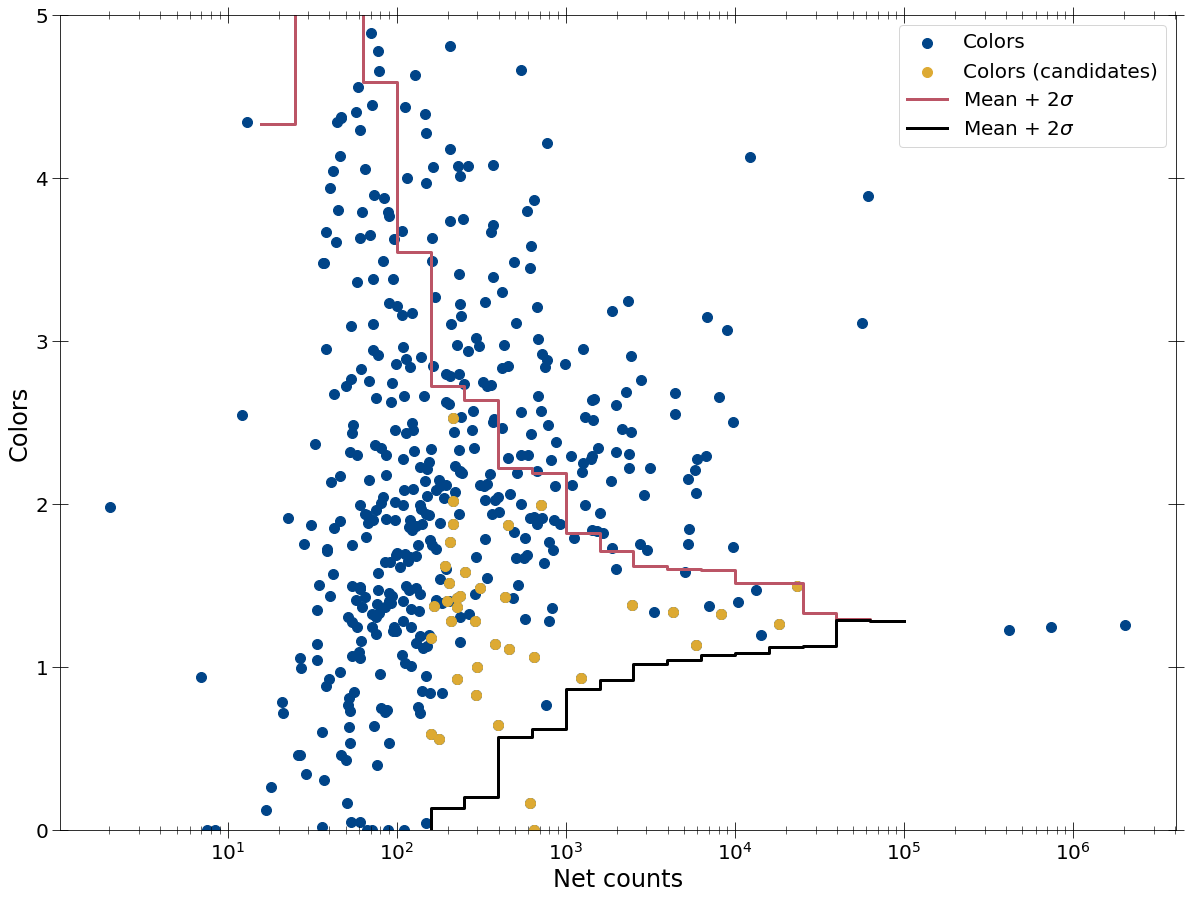

2:80: E501 line too long (83 > 79 characters)


In [64]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)

(array([ 14,  33,  55,  66,  84, 103, 117, 128, 137, 139, 183, 184, 199,
       201, 225, 226, 246, 260, 272, 273, 280]),)


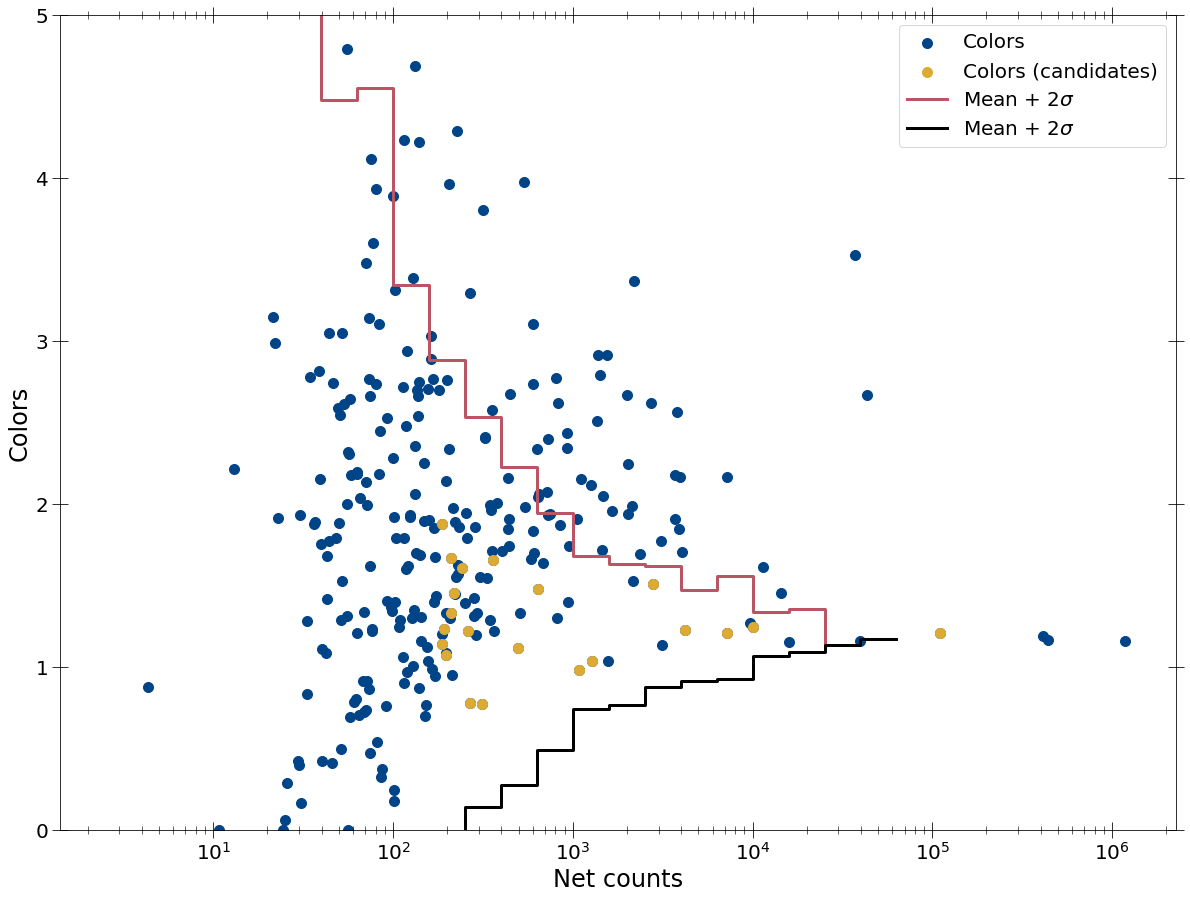

2:80: E501 line too long (83 > 79 characters)


In [65]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)

(array([   1,    2,   63,  115,  123,  137,  156,  162,  262,  349,  350,
        395,  396,  411,  419,  453,  454,  500,  543,  607,  616,  622,
        623,  674,  679,  685,  711,  719,  722,  737,  827,  831,  854,
        883,  900,  936,  945,  949,  982,  996,  997, 1006, 1037, 1051,
       1057, 1058, 1146, 1148, 1254, 1260, 1267, 1295, 1301, 1325, 1336,
       1353, 1382, 1391, 1394, 1416, 1424, 1471, 1501, 1507, 1524, 1527,
       1562, 1563, 1602, 1604, 1609, 1614, 1640, 1647, 1650, 1658, 1665,
       1686, 1734, 1735, 1737, 1767, 1786, 1816, 1820, 1833, 1863, 1885,
       1901, 1961, 1980, 2041]),)


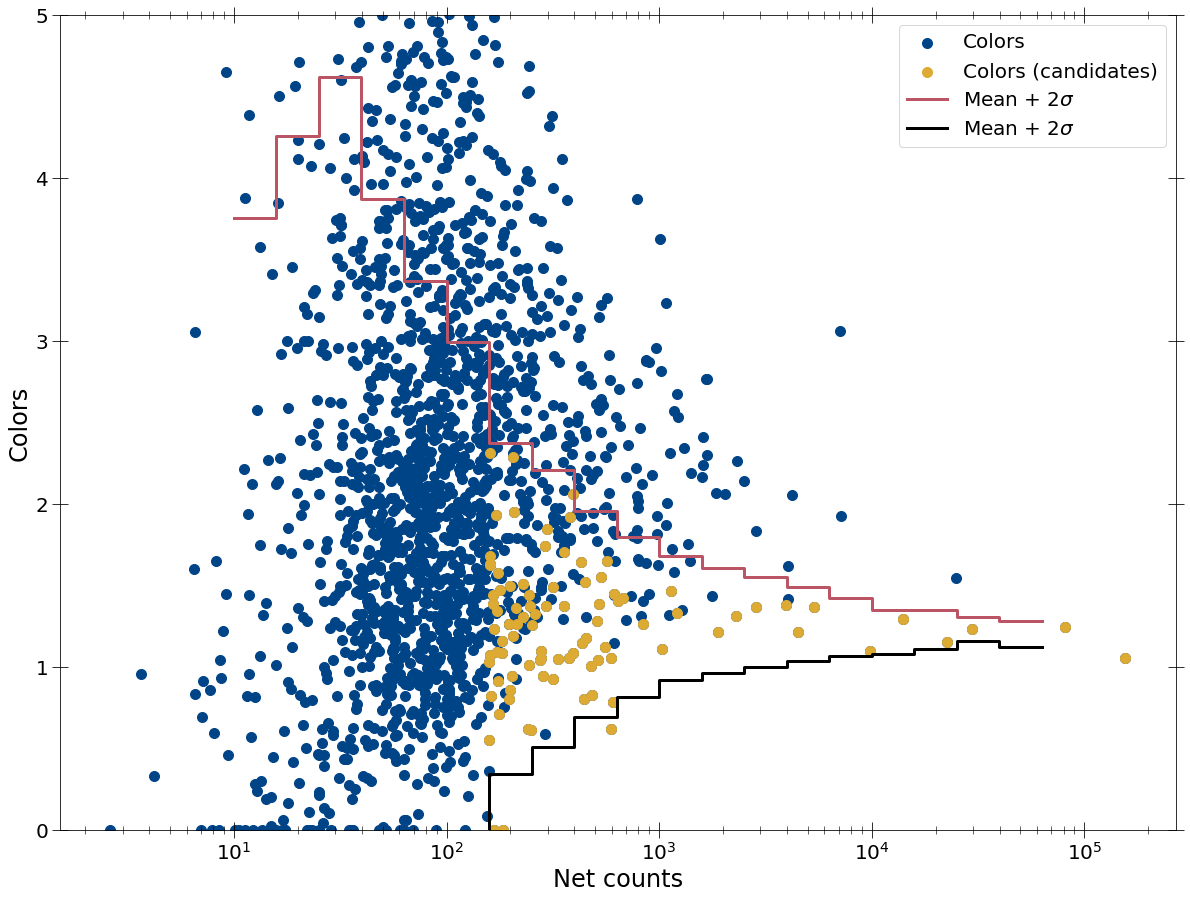

2:80: E501 line too long (83 > 79 characters)


In [66]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

(array([  0,   5,  19,  33,  40,  44,  50,  74,  75,  86,  91, 111, 137,
       144, 147, 152, 187, 198, 211, 213, 229, 231, 240, 260, 266, 283,
       304, 308, 309, 336, 374, 388, 412, 442, 443, 465, 467]),)
(array([ 14,  33,  55,  66,  84, 103, 117, 128, 137, 139, 183, 184, 199,
       201, 225, 226, 246, 260, 272, 273, 280]),)
(array([   1,    2,   63,  115,  123,  137,  156,  162,  262,  349,  350,
        395,  396,  411,  419,  453,  454,  500,  543,  607,  616,  622,
        623,  674,  679,  685,  711,  719,  722,  737,  827,  831,  854,
        883,  900,  936,  945,  949,  982,  996,  997, 1006, 1037, 1051,
       1057, 1058, 1146, 1148, 1254, 1260, 1267, 1295, 1301, 1325, 1336,
       1353, 1382, 1391, 1394, 1416, 1424, 1471, 1501, 1507, 1524, 1527,
       1562, 1563, 1602, 1604, 1609, 1614, 1640, 1647, 1650, 1658, 1665,
       1686, 1734, 1735, 1737, 1767, 1786, 1816, 1820, 1833, 1863, 1885,
       1901, 1961, 1980, 2041]),)


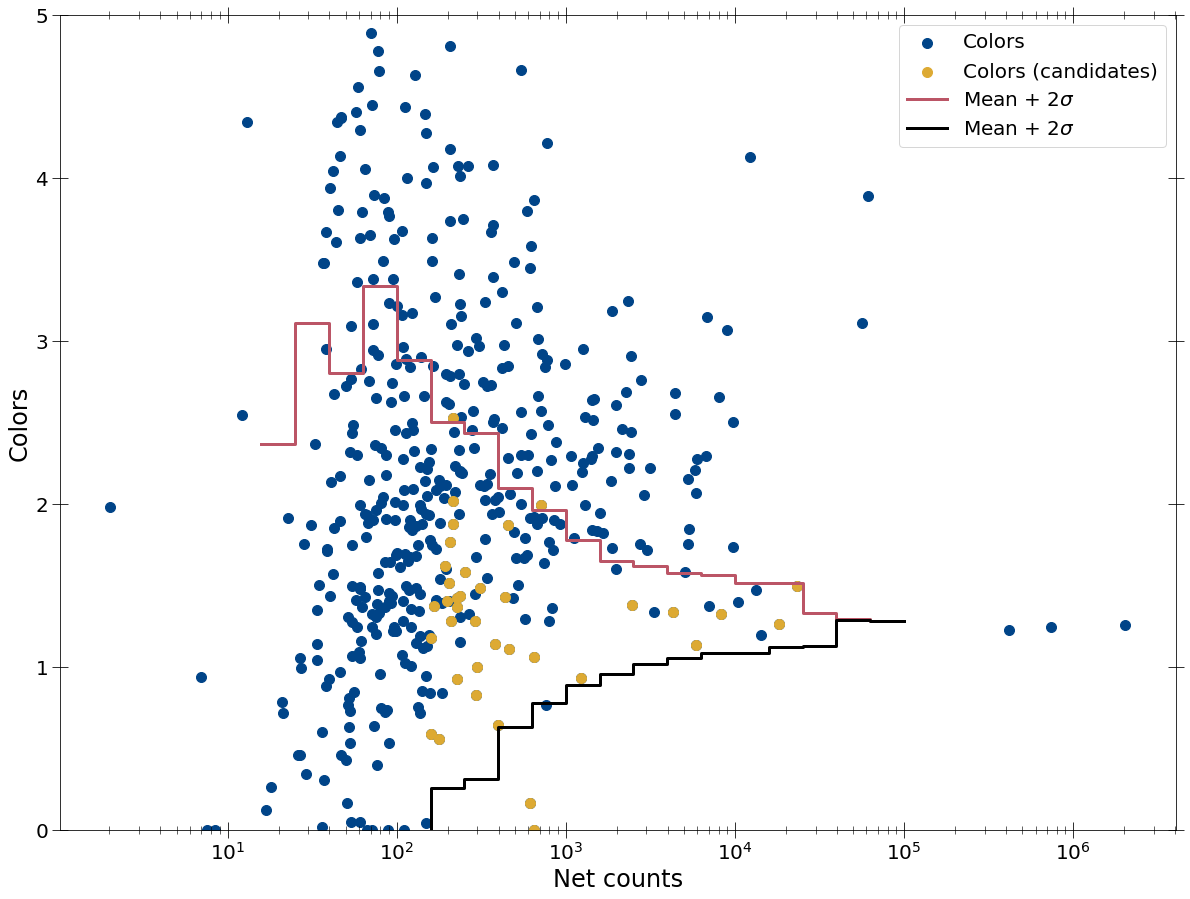

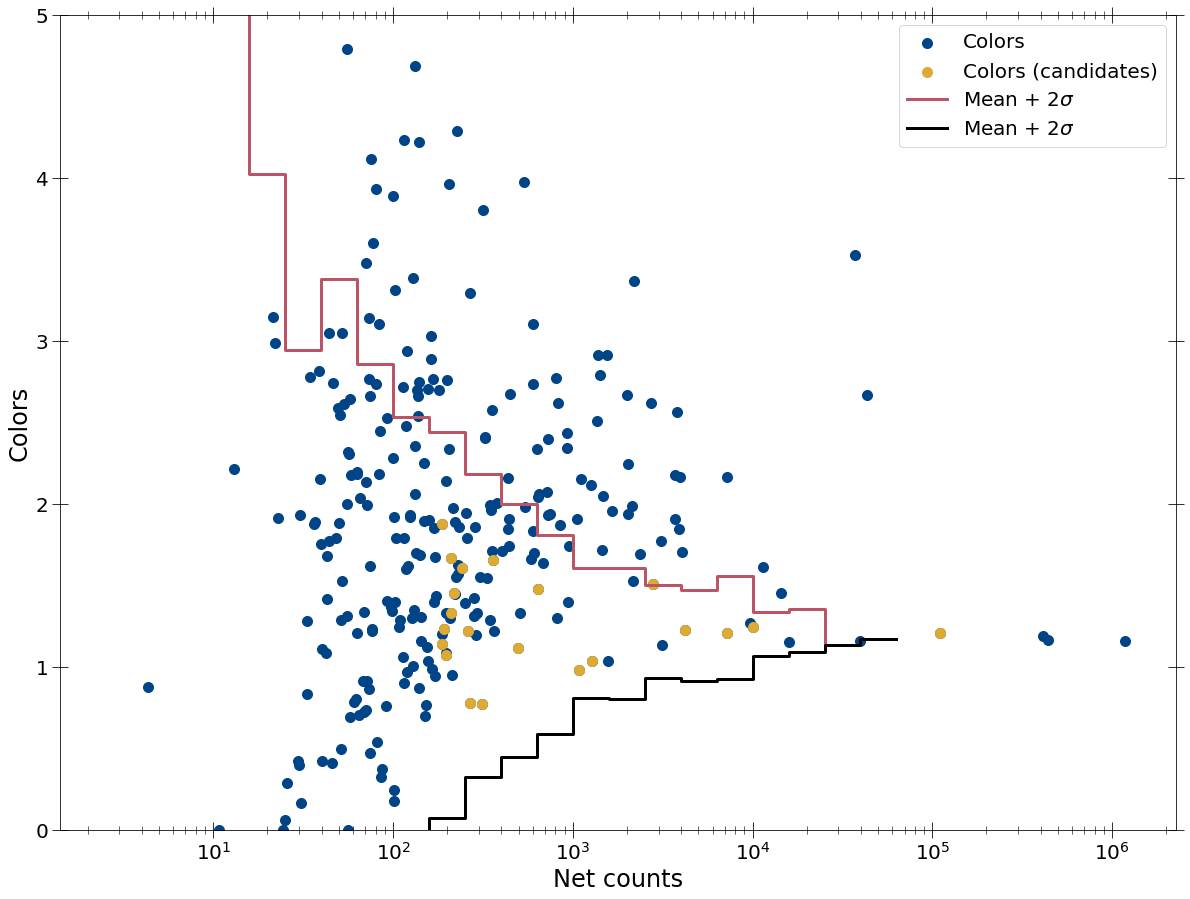

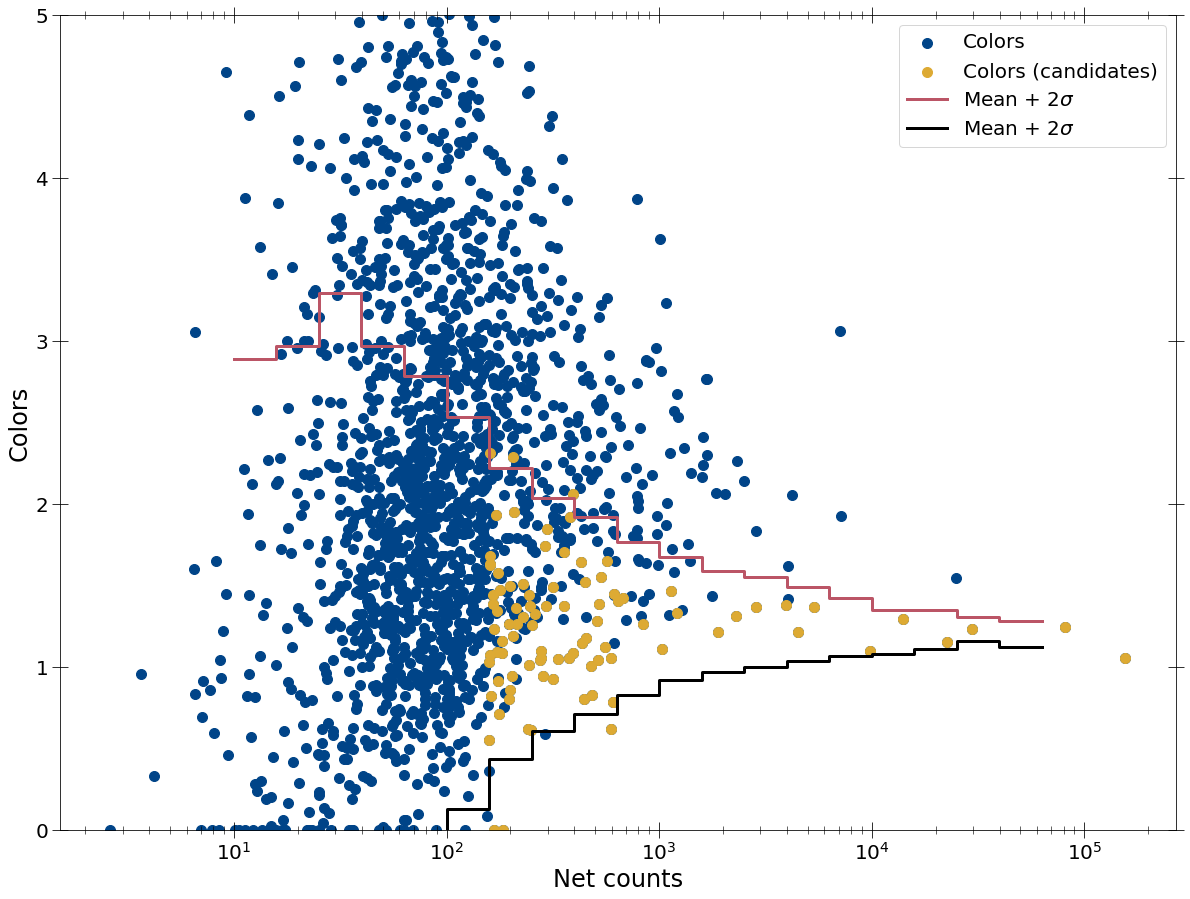

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [67]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [108]:
np.where(interested_srcs_alldet[2] == '2CXOJ174530.0-285943')

(array([177]),)

In [110]:
print(acis_fit_stats_table_pl[125])
print(acis_fit_stats_table_pl_g[125])
print(acis_fit_stats_table_pl_g2[125])
print()
print(acis_fit_stats_table_pl[208])
print(acis_fit_stats_table_pl_g[208])
print(acis_fit_stats_table_pl_g2[208])
print()
print(acis_fit_stats_table_pl[133])
print(acis_fit_stats_table_pl_g[133])
print(acis_fit_stats_table_pl_g2[133])

['2CXOJ174540.3-290049', 266.01879656001785, -7.589646752720701, 50.0, 299]
['2CXOJ174540.3-290049', 264.6833556689429, -7.805990677928118, 50.0, 297]
['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296]

['2CXOJ174536.9-290039', 344.5620739732016, -9.526574126034008, 50.0, 389]
['2CXOJ174536.9-290039', 341.77998992125424, -9.871299609625027, 50.0, 387]
['2CXOJ174536.9-290039', 340.80402348470886, -9.916018231068454, 50.0, 386]

['2CXOJ174535.7-290004', 219.3432290242929, -8.32886982476195, 50.0, 254]
['2CXOJ174535.7-290004', 216.10212421697082, -8.175803506918273, 50.0, 252]
['2CXOJ174535.7-290004', 216.40324068904283, -8.163633107538715, 50.0, 251]


In [106]:
print(acis_model_params_table_pl_g2[125])
print(acis_model_params_table_pl_g2[208])
print(acis_model_params_table_pl_g2[133])

['2CXOJ174540.3-290049', 14.747172266857492, 2.284559245444103, 0.014014393023623173, 3.157876082859608e-08, 1.936457506907927e-08, 4.298694332175304e-19, 0.0, 8.242343569531286e-08, 0.0, 7.391659902986237e-08, 0.0, 3.2311902308687976e-08]
['2CXOJ174536.9-290039', 32.91698126831548, 2.169538475539656, 0.13824128530453256, 5.4557158152566107e-14, 1.4314730567579634e-07, 7.4035496908206e-08, 0.0, 1.1265319696324751e-07, 0.0, 3.059586290967107e-07, 0.0, 2.3806088884467742e-07]
['2CXOJ174535.7-290004', 25.294693190701558, 1.6423470508550815, 0.040934446317875135, 8.531655806100725e-08, 3.5908650704885276e-08, 1.1327547386683504e-08, 0.0, 1.9846436077281447e-07, 0.0, 1.5934190141787257e-07, 0.0, 1.3669784512889456e-07]


(array([ 678,  840,  990, 1335, 1856]),)


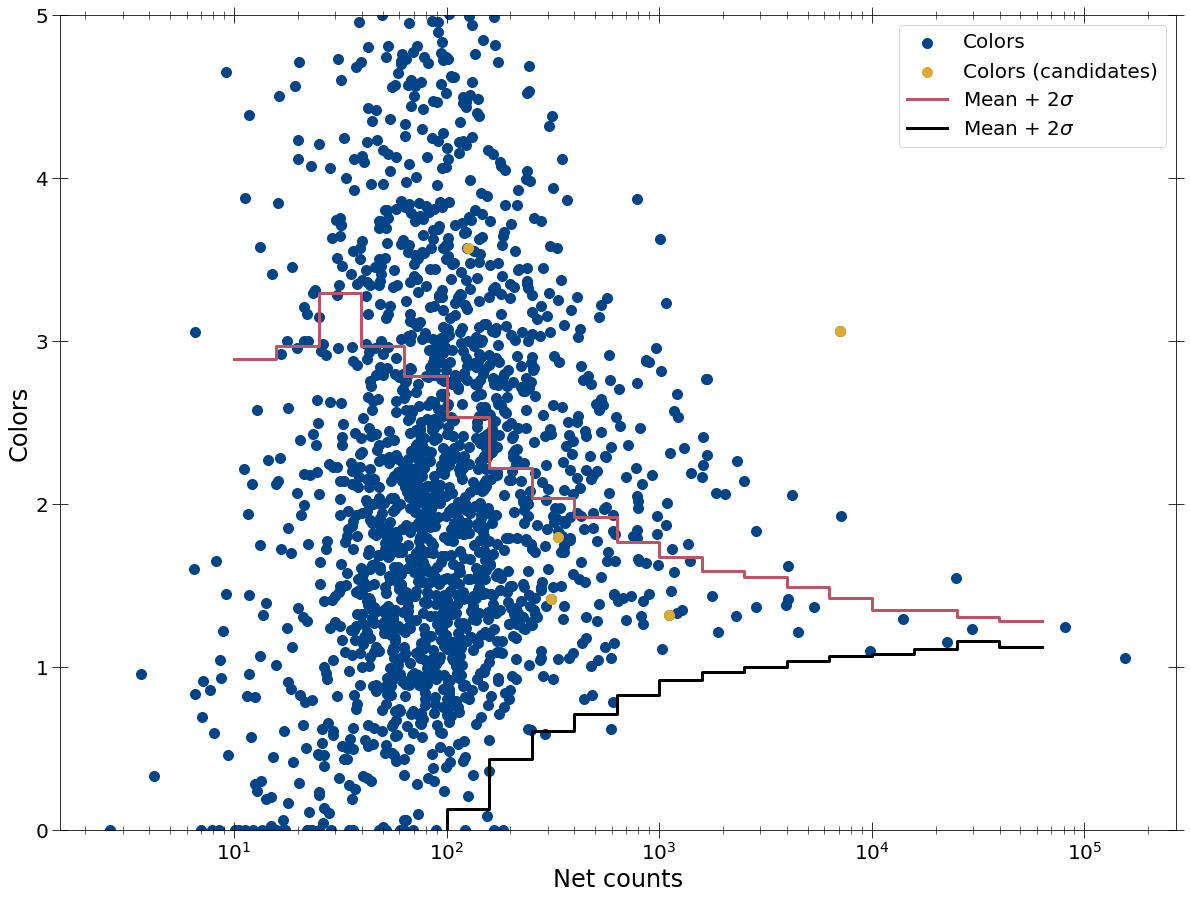

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)


In [114]:
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174540.3-290049', '2CXOJ174536.9-290039',
                      '2CXOJ174535.7-290004', '2CXOJ174536.1-285638',
                      '2CXOJ174528.8-285726'], 0)

In [ ]:

    candidate_args = interested_args_alldet[0][np.where(aic_pl > aic_pl_gauss)]
    candidate_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][candidate_args]
    interested_netcounts = spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][3]][interested_args_alldet[0]]

    candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])
    interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[0]['prop_bins'][0])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


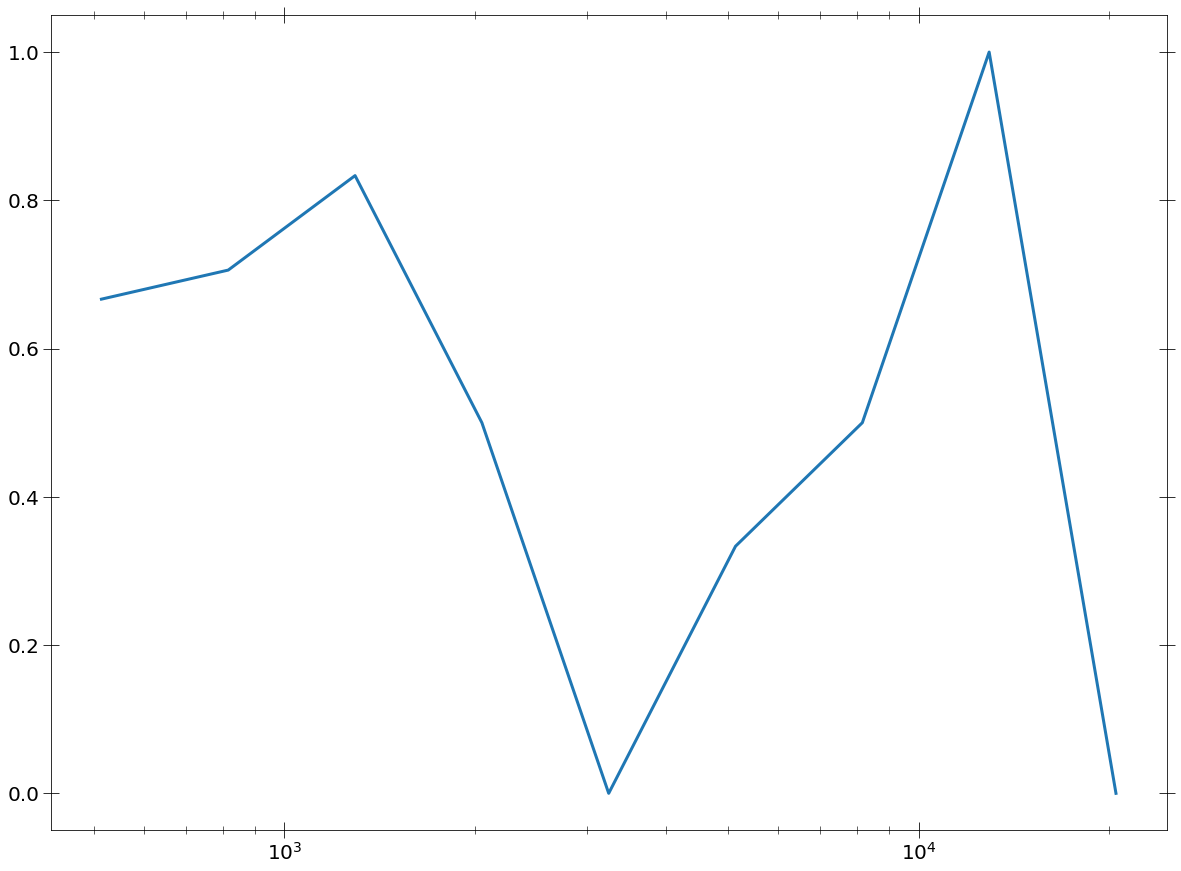

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [33]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    if telescope == 'XMM':
        spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                 str(source_num) + '_PN_combined_src_grp1*')
        spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                  str(source_num) + '_MOS_combined_src_grp1*')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        os.chdir(src_folder + '/' + source_num)
        spec_file = str(source_num) + '_combined_src_grp1.pi'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    xspec.Xset.addModelString('LINECRITLEVEL', '1.0E-11')
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('1.0 8')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 11')
    xspec.Fit.perform()
    xspec.Fit.error('1.0 14')
    # xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + source_num +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + source_num + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


25:1: W293 blank line contains whitespace
41:1: W293 blank line contains whitespace
53:5: E265 block comment should start with '# '
74:80: E501 line too long (80 > 79 characters)


In [34]:
fit_src_pl_gauss2(interested_srcs_alldet[0][11])

Model params for 201129704010033: NH =  37.58376688435754  Gamma:  1.1153459504252852  norm:  0.24856734403946862  Fe_norms: 4.4429896275210224e-08 0.0 3.104073504837616e-07 3.1297496002610865e-07 4.0809581276505986e-08 6.149906689177296e-07 7.983042507277889e-13 0.0 2.710601220051383e-07
Fit stats for 201129704010033:  666.2322426833637 -7.151577104041813 50.0 756




(['201129704010033', 666.2322426833637, -7.151577104041813, 50.0, 756],
 ['201129704010033',
  37.58376688435754,
  1.1153459504252852,
  0.24856734403946862,
  4.4429896275210224e-08,
  3.1297496002610865e-07,
  7.983042507277889e-13,
  0.0,
  3.104073504837616e-07,
  4.0809581276505986e-08,
  6.149906689177296e-07,
  0.0,
  2.710601220051383e-07])

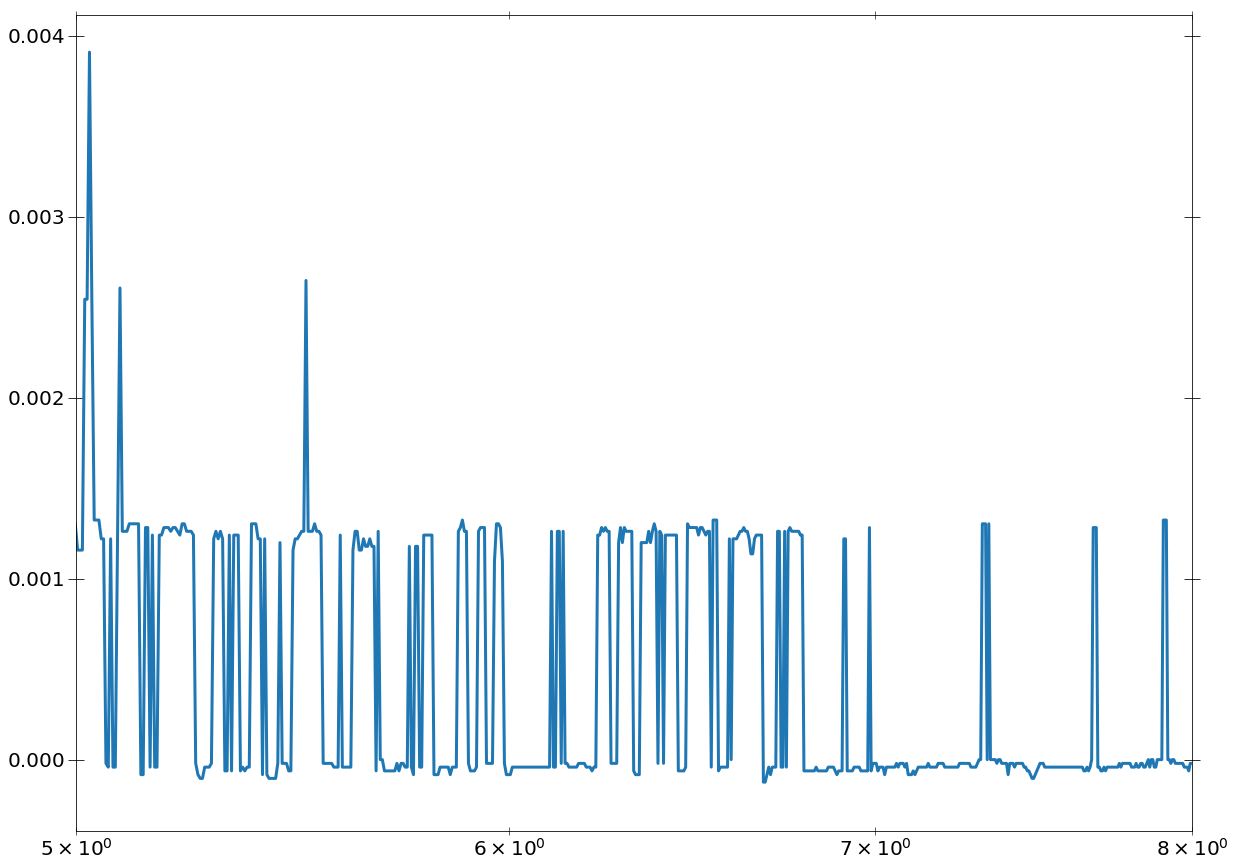

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-